In [35]:
#Load in all funcions and modules
#staples just in case 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as mt

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.graphics.tsaplots import plot_pacf

#Data Prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score

In [36]:
#Load in data
df = pd.read_csv(r'C:\Users\Monado\Documents\Data_Portfolio\Projects\VGChartz\vgchartz_data.csv')

# Look at properties of data 

In [37]:
df.head()

Rank                                Name Publisher     Developer Platform  \
0     1                          Wii Sports  Nintendo  Nintendo EAD      Wii   
1     2                   Super Mario Bros.  Nintendo  Nintendo EAD      NES   
2     3                      Mario Kart Wii  Nintendo  Nintendo EAD      Wii   
3     4                   Wii Sports Resort  Nintendo  Nintendo EAD      Wii   
4     5  Pokémon Red / Green / Blue Version  Nintendo    Game Freak       GB   

   Release_date         Genre  Sales_NA  Sales_PAL  Sales_JP  Sales_Other  \
0        2006.0        Sports     41.36      29.02      3.77         8.51   
1        1985.0      Platform     29.08       3.58      6.81         0.77   
2        2008.0        Racing     15.91      12.92      3.80         3.35   
3        2009.0        Sports     15.61      10.99      3.29         3.02   
4        1998.0  Role-Playing     11.27       8.89     10.22         1.00   

   Sales_Globe  
0        82.65  
1        40.24  
2        35.98  
3        32.90  
4        31.37

In [38]:
print("Data Shape :",df.shape)

Data Shape : (19000, 12)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          19000 non-null  int64  
 1   Name          19000 non-null  object 
 2   Publisher     19000 non-null  object 
 3   Developer     18998 non-null  object 
 4   Platform      19000 non-null  object 
 5   Release_date  18942 non-null  float64
 6   Genre         19000 non-null  object 
 7   Sales_NA      13484 non-null  float64
 8   Sales_PAL     12982 non-null  float64
 9   Sales_JP      7464 non-null   float64
 10  Sales_Other   15390 non-null  float64
 11  Sales_Globe   19000 non-null  float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.7+ MB


In [40]:
df.nunique()

Rank            19000
Name            13111
Publisher         701
Developer        2746
Platform           39
Release_date       44
Genre              20
Sales_NA          421
Sales_PAL         324
Sales_JP          245
Sales_Other       163
Sales_Globe       656
dtype: int64

In [41]:
# Look at columns with only null values
data_nan = pd.DataFrame({'Count': df.isna().sum()[df.isna().sum() != 0]})

data_nan['% of total'] = round((data_nan['Count'] * 100)/ df.shape[0], 2)
print(data_nan.sort_values('Count', ascending = False))
print('\n')
print('of the %d columns in the data, %d columns contain null values' %(df.shape[1], len(data_nan)))

              Count  % of total
Sales_JP      11536       60.72
Sales_PAL      6018       31.67
Sales_NA       5516       29.03
Sales_Other    3610       19.00
Release_date     58        0.31
Developer         2        0.01


of the 12 columns in the data, 6 columns contain null values


A majority of our missing data comes from regional sales data, with Japanese sales missing over half of our data set. For now we will leave this unadressed as we coninue to explore the data set.

In [42]:
round(df.describe(include='all'), 2)

Rank     Name   Publisher Developer Platform  Release_date  \
count   19000.00    19000       19000     18998    19000      18942.00   
unique       NaN    13111         701      2746       39           NaN   
top          NaN  FIFA 14  Activision   Unknown       DS           NaN   
freq         NaN        9        1021       419     2277           NaN   
mean     9500.50      NaN         NaN       NaN      NaN       2007.58   
std      5484.97      NaN         NaN       NaN      NaN          6.28   
min         1.00      NaN         NaN       NaN      NaN       1977.00   
25%      4750.75      NaN         NaN       NaN      NaN       2004.00   
50%      9500.50      NaN         NaN       NaN      NaN       2008.00   
75%     14250.25      NaN         NaN       NaN      NaN       2011.00   
max     19000.00      NaN         NaN       NaN      NaN       2020.00   

         Genre  Sales_NA  Sales_PAL  Sales_JP  Sales_Other  Sales_Globe  
count    19000  13484.00   12982.00   7464.00     15390.00     19000.00  
unique      20       NaN        NaN       NaN          NaN          NaN  
top     Action       NaN        NaN       NaN          NaN          NaN  
freq      2848       NaN        NaN       NaN          NaN          NaN  
mean       NaN      0.35       0.21      0.19         0.06         0.51  
std        NaN      0.91       0.60      0.45         0.20         1.51  
min        NaN      0.00       0.00      0.00         0.00         0.00  
25%        NaN      0.05       0.02      0.02         0.00         0.05  
50%        NaN      0.13       0.05      0.06         0.01         0.15  
75%        NaN      0.33       0.18      0.16         0.04         0.44  
max        NaN     41.36      29.02     10.22        10.57        82.65

# EDA

We start by examining overall release and sales trends over time

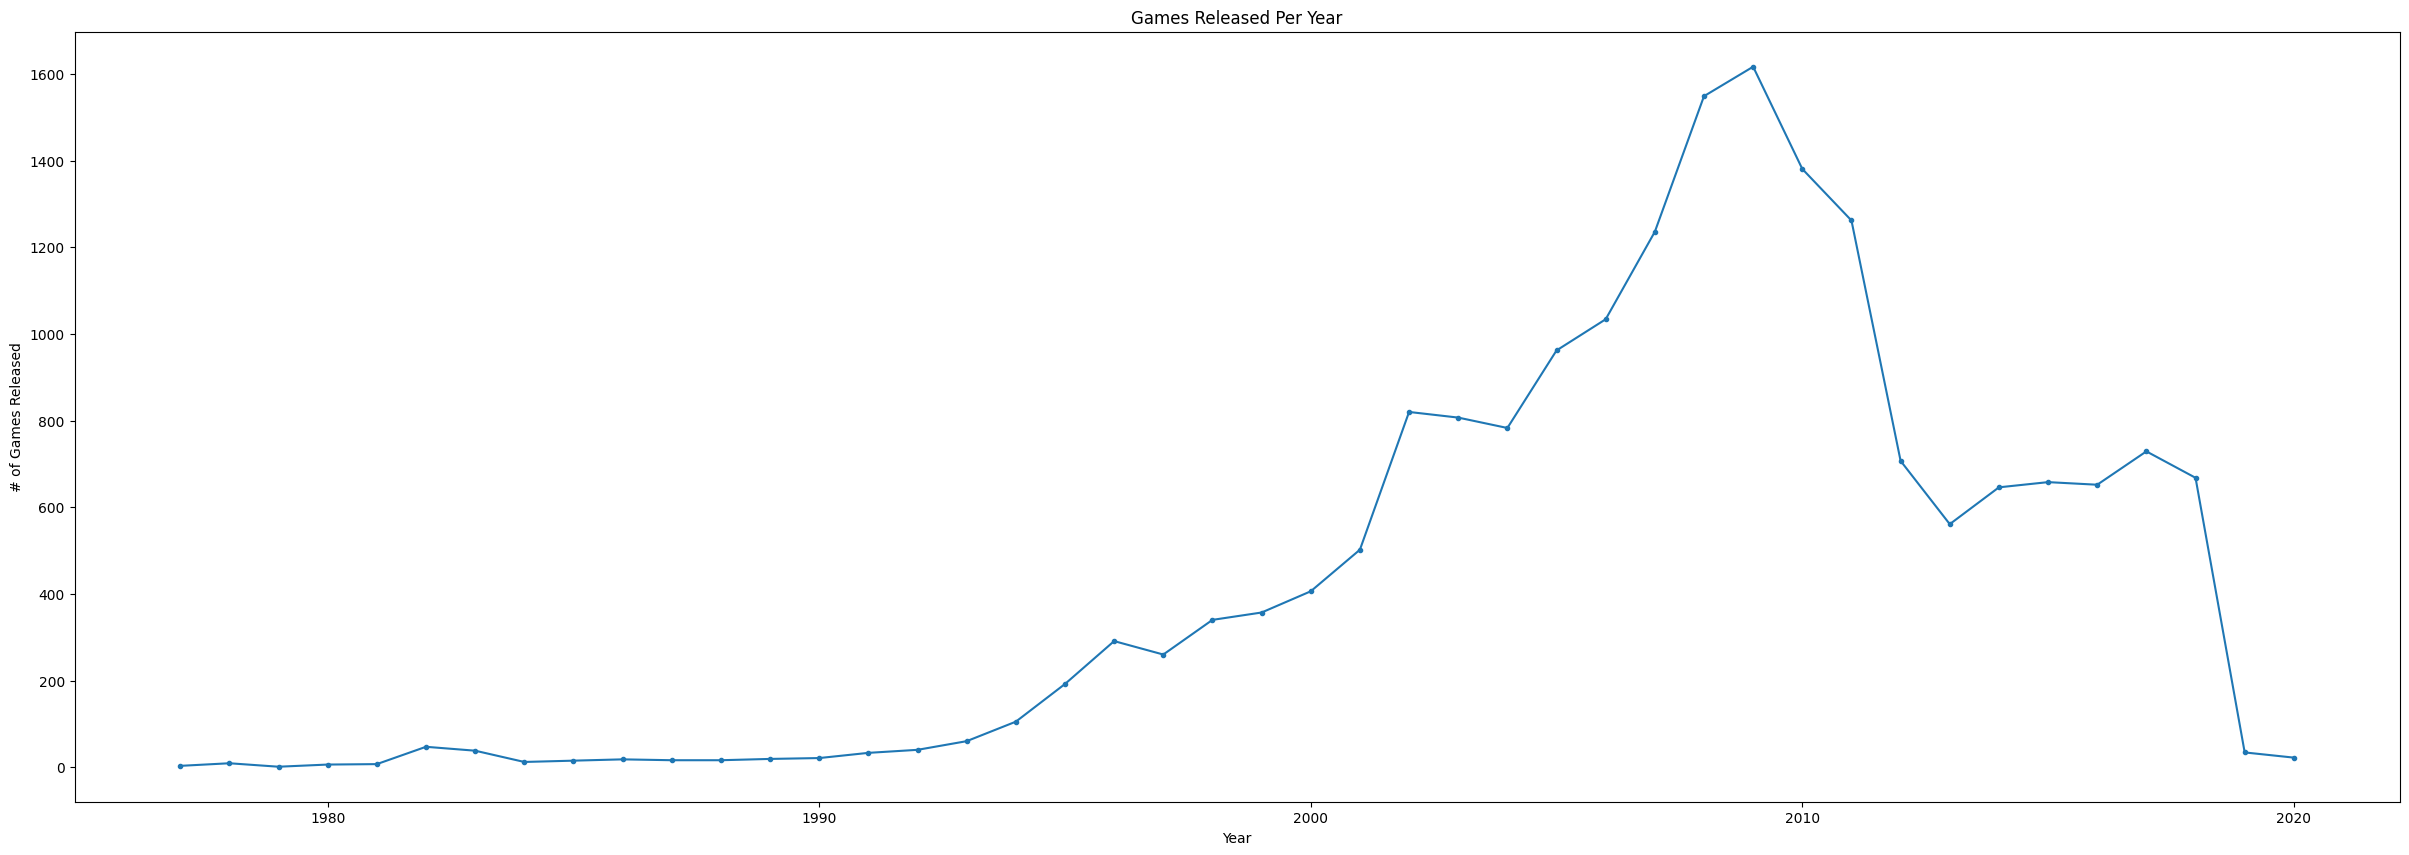

In [43]:
yearly_total_release = df.groupby(['Release_date'],as_index=False)['Sales_Globe'].count()

plt.figure(figsize = (30,10))
plt.plot(yearly_total_release['Release_date'],yearly_total_release['Sales_Globe'],marker='.')
plt.title('Games Released Per Year')
plt.ylabel('# of Games Released')
plt.xlabel('Year')
plt.show()

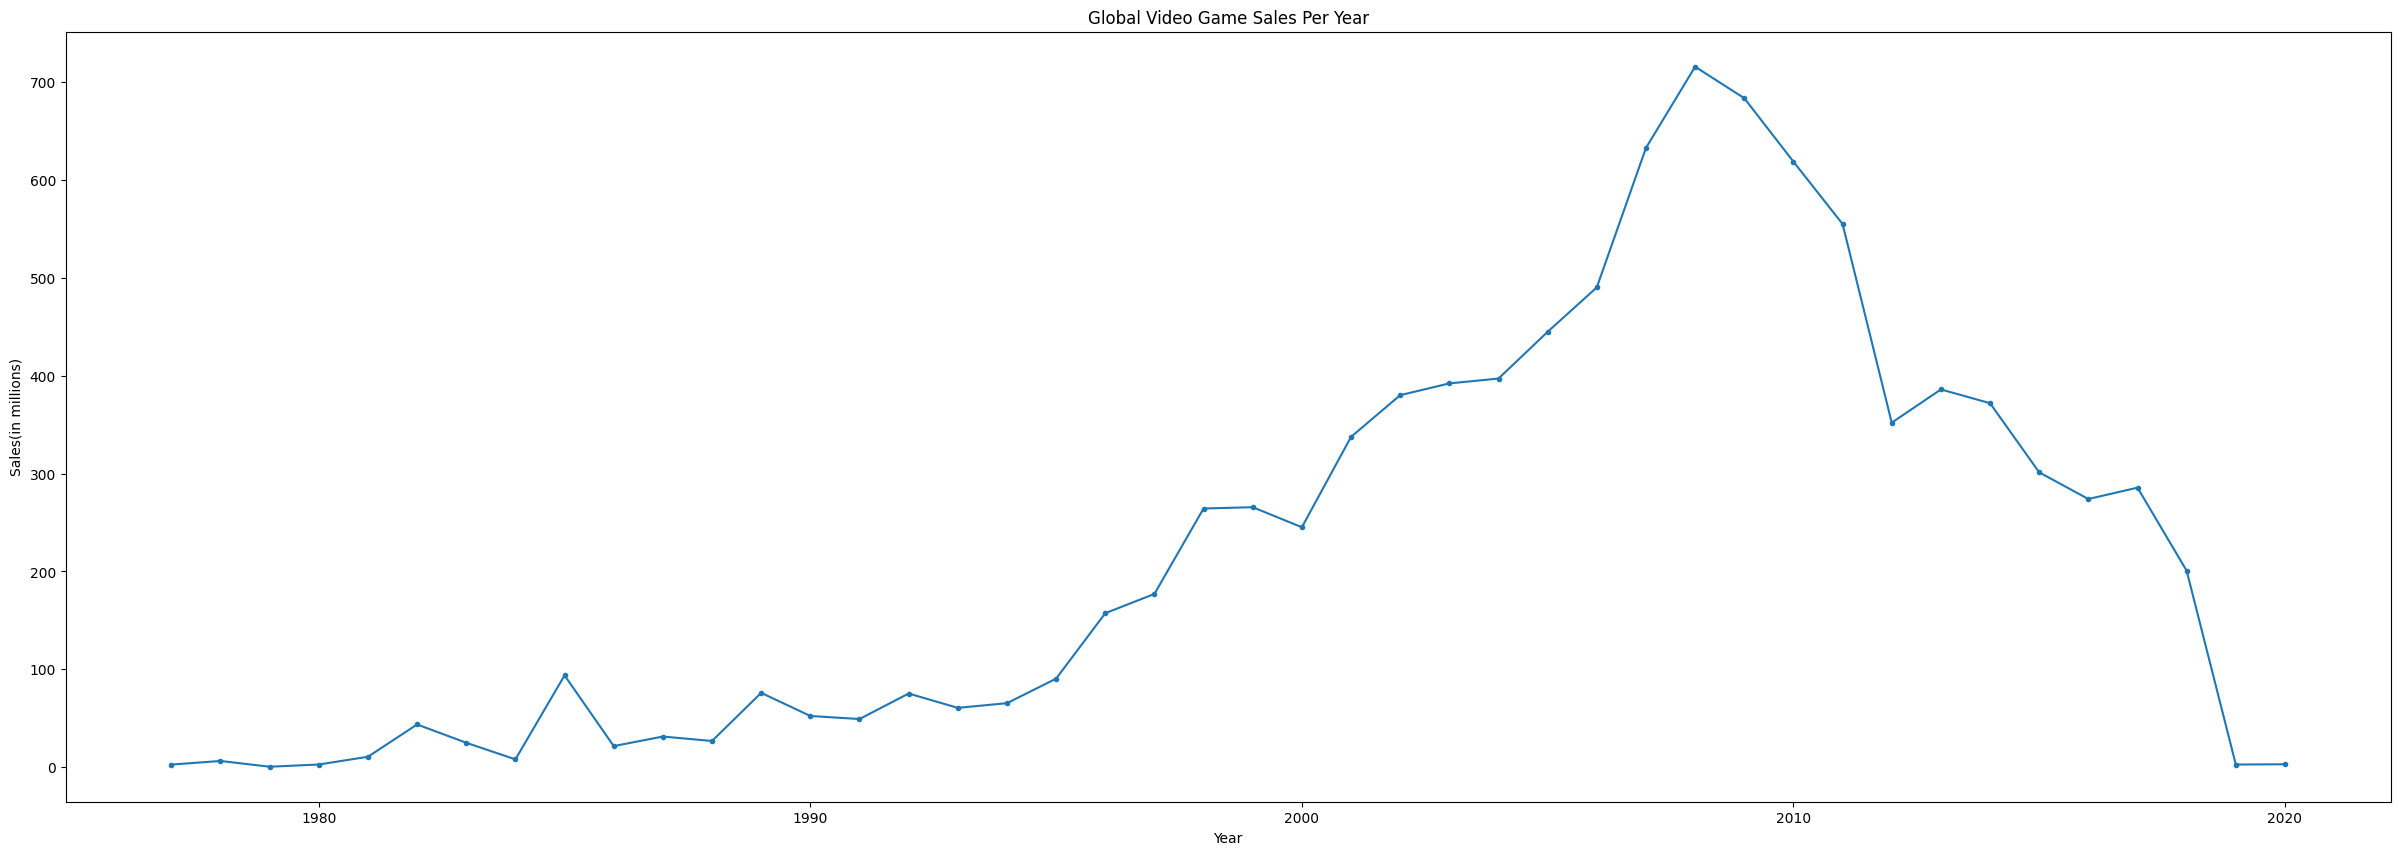

In [44]:
yearly_total_sales = df.groupby(['Release_date'],as_index=False)['Sales_Globe'].sum()


plt.figure(figsize = (30,10))
plt.plot(yearly_total_sales['Release_date'],yearly_total_sales['Sales_Globe'],marker='.')
plt.title('Global Video Game Sales Per Year')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.show()

This graph shows steady increase in video games sales and releases until around 2008 where we seem to take a steep dive. After 2008 the amount of titles in our data base and overall sales per year starts to decrease. This major drop is likely tied to the Great Recession, at least in North Amercia, as many would had to cut back on luxury purchases like video games during these financially difficult times. The after affects of this linger until about 2012 where we see an increase in releases and sales. This increase is short lived as we quickly see another dramatic drop at after 2017. This drop off is a little more difficult to determine. It is unclear how much of this drop is caused by an acutal trend in our data and how much is caused by our dataset not being as complete for years pst this. I would be interested to see if in the future this database is updated to include more data from more recent years and how that might affect trends in our data. This would allows us to investigate further into more recent trends and allow us to see how other major events like Covid-19 might have affected the video game market.

For the purproses of this anaylsis we will assume this trend to be true, up until 2018 where we start to see a much larger drop off in data points that is likely coming from our dataset being incomplete. 

**Genre Data**

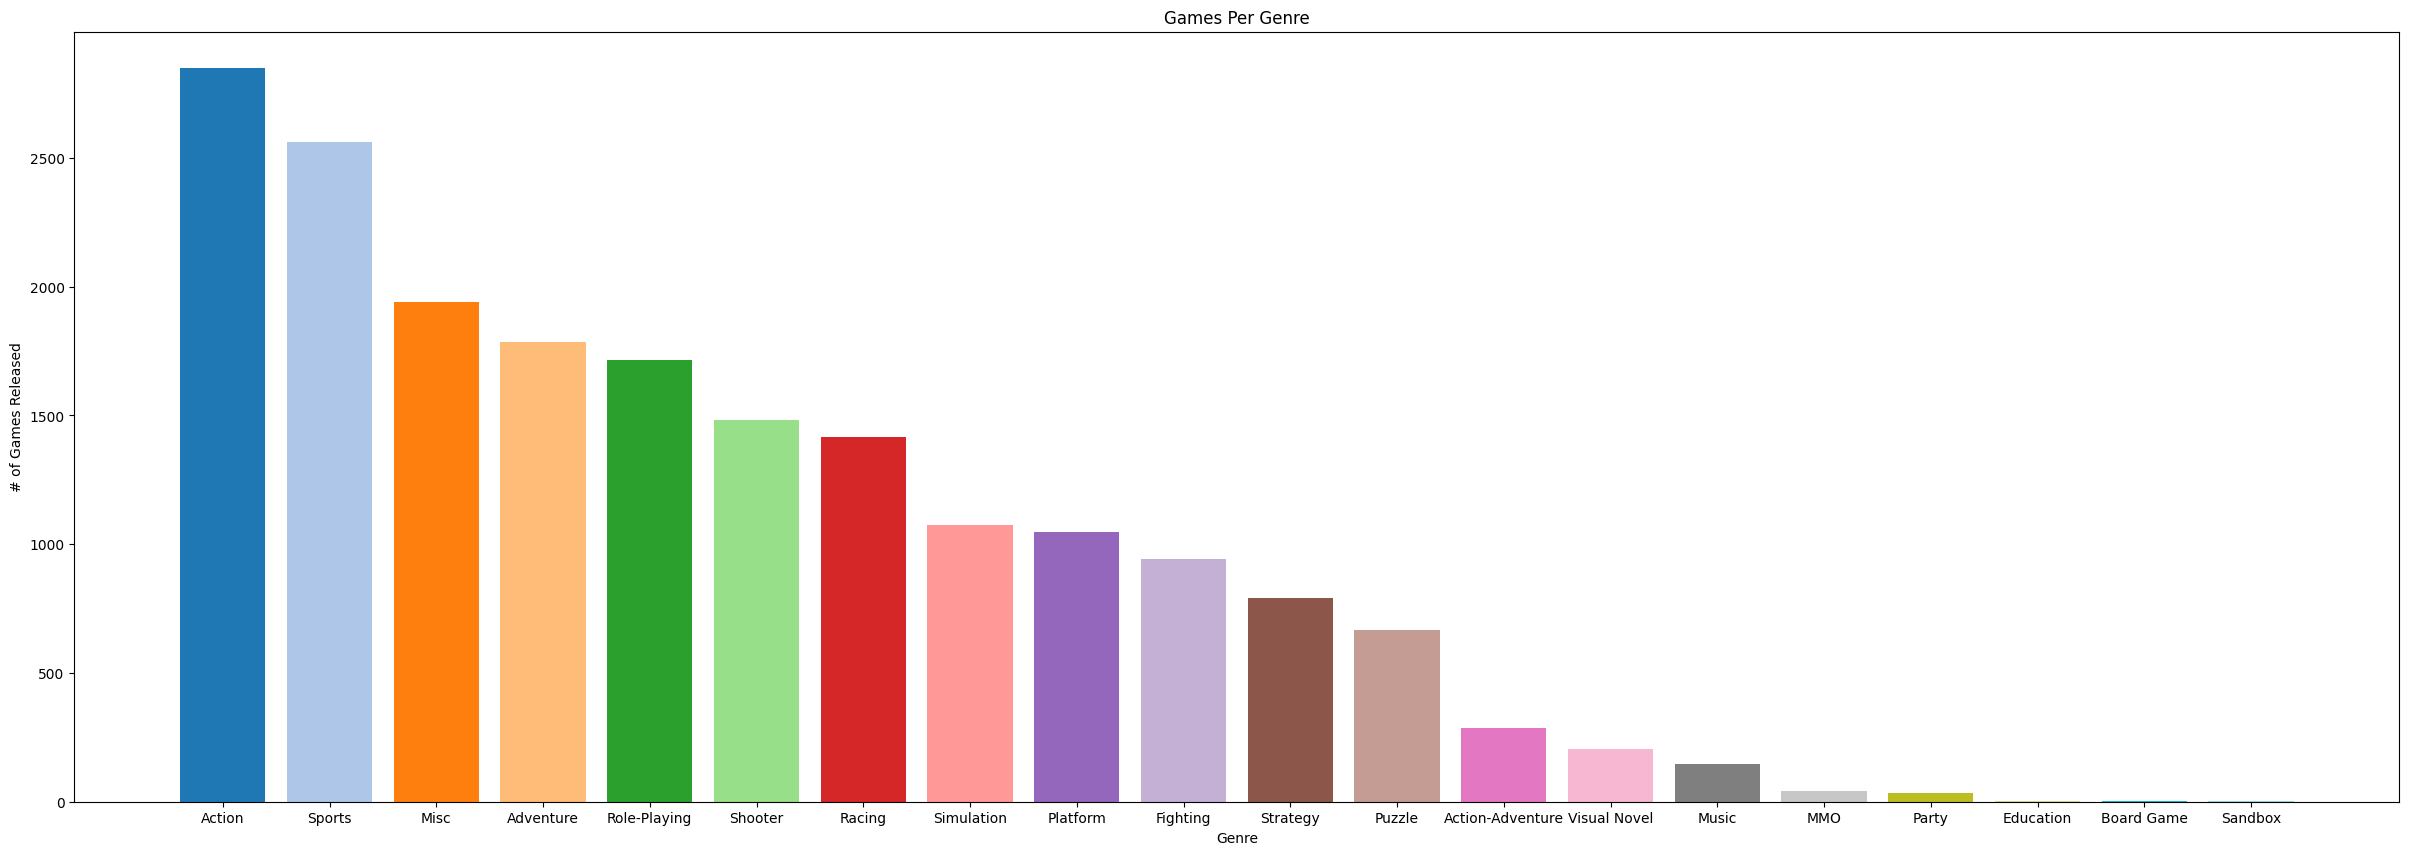

In [45]:
genre_total_releases = df.groupby(['Genre'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df['Genre'].unique()))/(len(df['Genre'].unique())))

plt.figure(figsize = (30,10))
plt.bar(genre_total_releases['Genre'],genre_total_releases['Sales_Globe'],color=cs)
plt.title('Games Per Genre')
plt.xlabel('Genre')
plt.ylabel('# of Games Released')
plt.show()

The action genre has the most games, with sports coming at second. Education, boardgame and sandbox games come in at last. The data seems to suggest that there are many more titles in genres with faster pace game play and less for slower paced games based around tactics and problem solving. This is not an indictiation of which genres are most successful or have performed better, but it does indicate which genres tend to be more popular.

Sports high count is likely tied into the yearly release cycle of many games in the genre such as Madden, NBA 2K, FIFA, etc. These games release a new version for each new season of their respective sport causing an inflation in the number of titles in this genre.

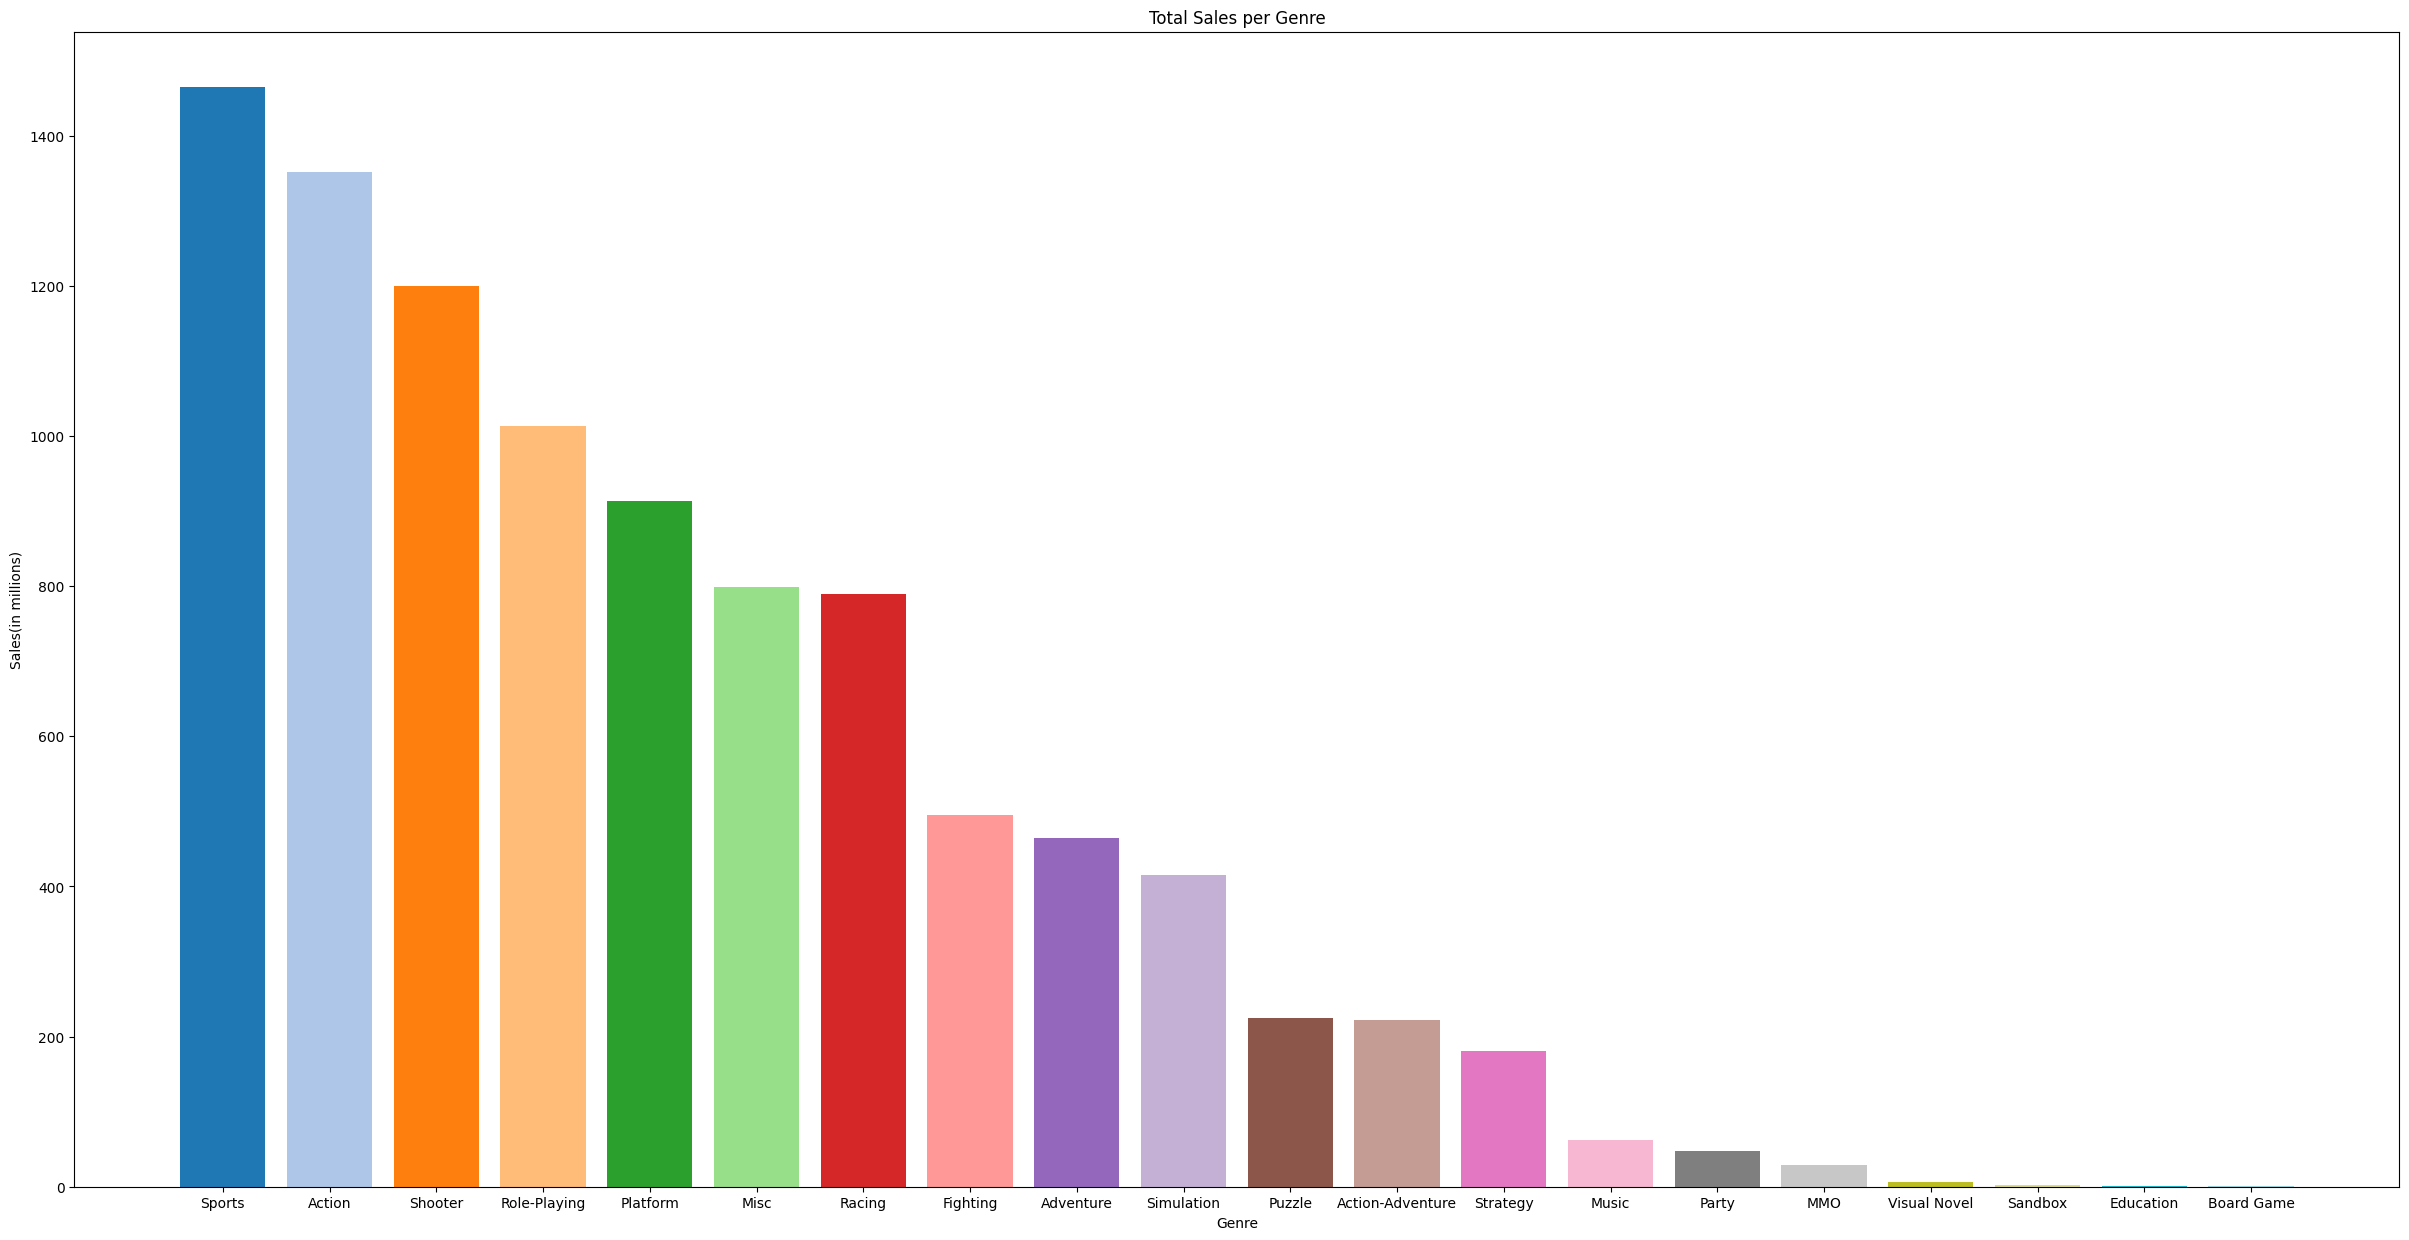

In [46]:
genre_total_sales = df.groupby(['Genre'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df['Genre'].unique()))/(len(df['Genre'].unique())))

plt.figure(figsize =(30,15))
plt.bar(genre_total_sales['Genre'],genre_total_sales['Sales_Globe'],color=cs)
plt.title('Total Sales per Genre')
plt.xlabel('Genre')
plt.ylabel('Sales(in millions)')
plt.show()

Once again we see action and sports as our top performing genres and education, boardgame and sandbox games as our bottom performer. Some of this trend is a reflection of the total games we have per genre but there are still some differences. For example we see that shooters ranks 3rd in overall sales but is 5th in total releases. This is a strong indication that shooting games tend to perform strong as they are out selling other genres with larger catelogs. Most of the other data matches similarly with our games per genre graph with slight shifts in placement. Once again this seems to indicate that games with more fast-paces gameplay seem to sell the better.

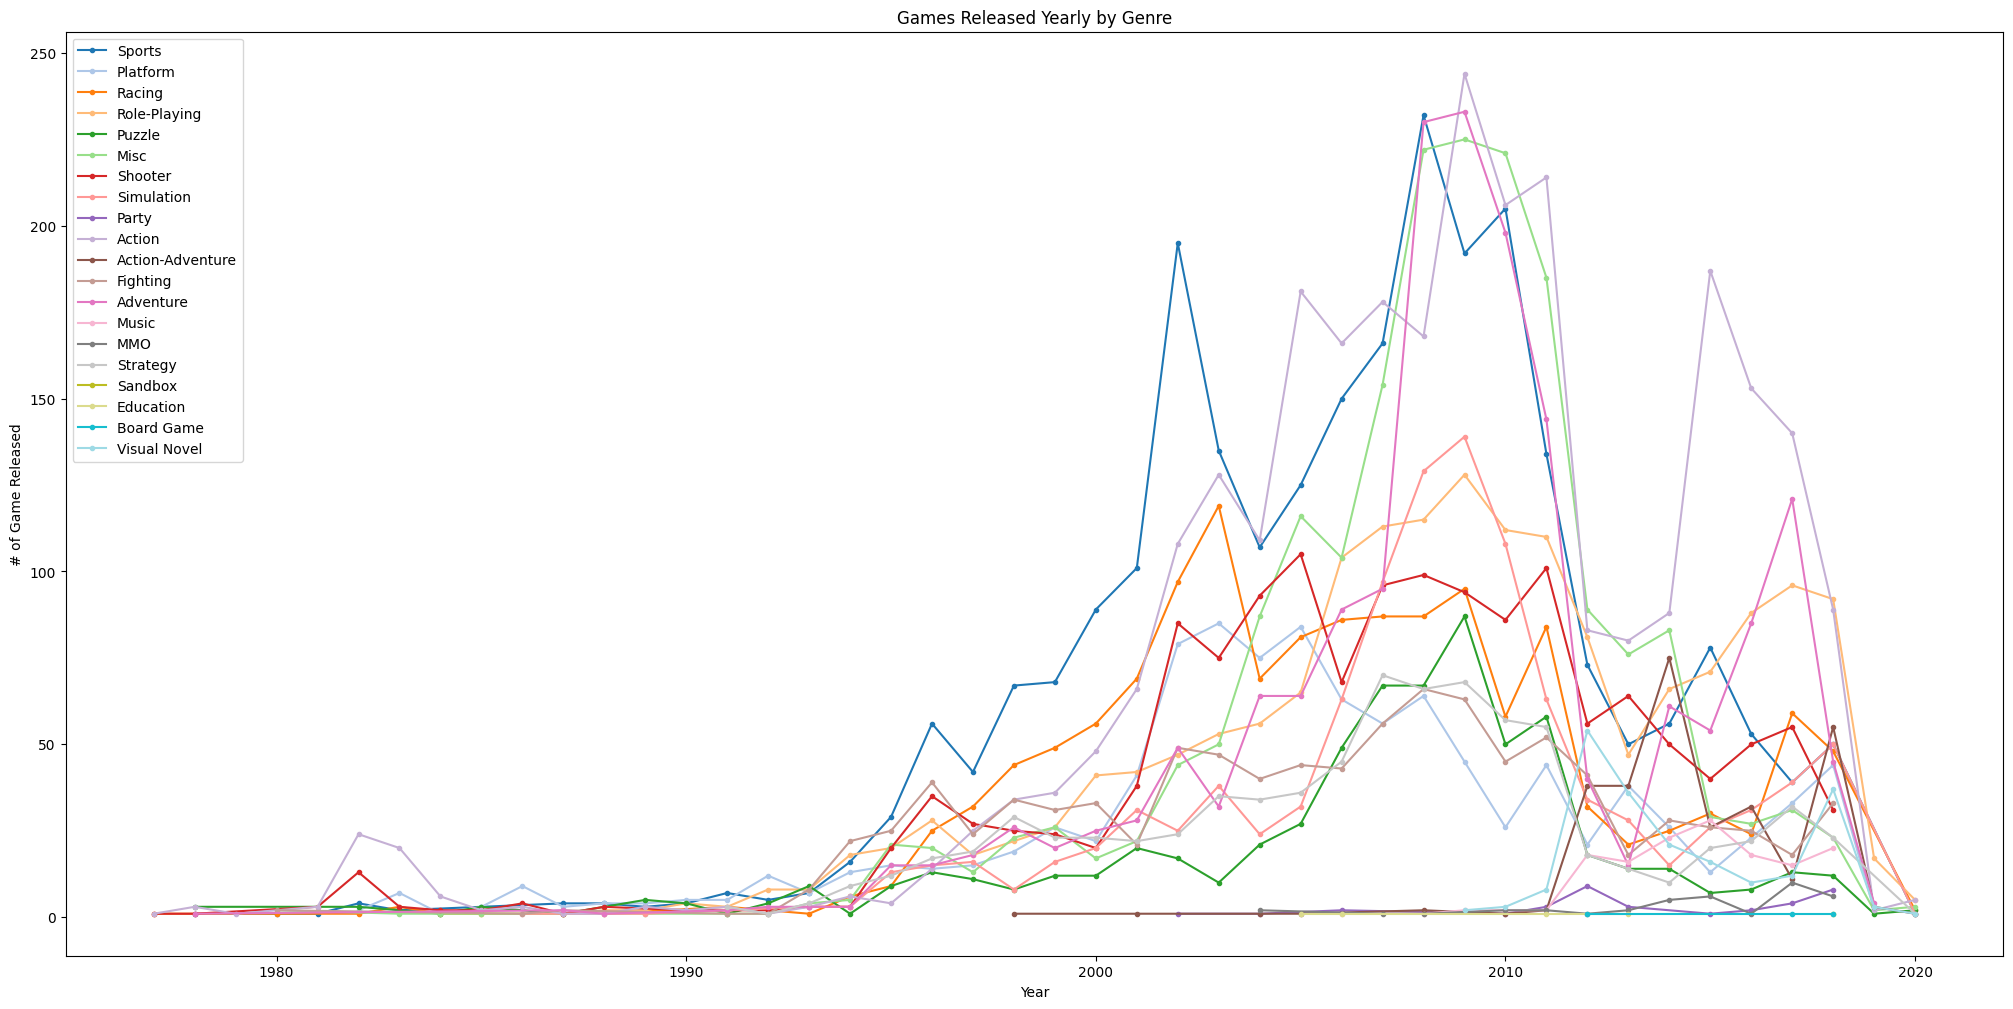

In [47]:
genre_list = df['Genre'].unique()

genre_yearly_releases = df.groupby(['Genre','Release_date'],as_index=False,sort=True)['Genre'].size()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for genre in genre_list:
    genre_release = genre_yearly_releases[genre_yearly_releases['Genre'] == genre]
    plt.plot(genre_release['Release_date'], genre_release['size'], label = genre,marker='.', color = cmap(i))
    i = i+1

plt.title('Games Released Yearly by Genre')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend(loc='upper left')
plt.show()

Most of genres of games seem to follow patters similar to what can be seen in overall game releaes. More intrestingly we see a much larger spike in sports game released between 2002-2004. Similarly we see that the action genre has the largest bounce back in releases after the large drop in all genre releases around 2008.

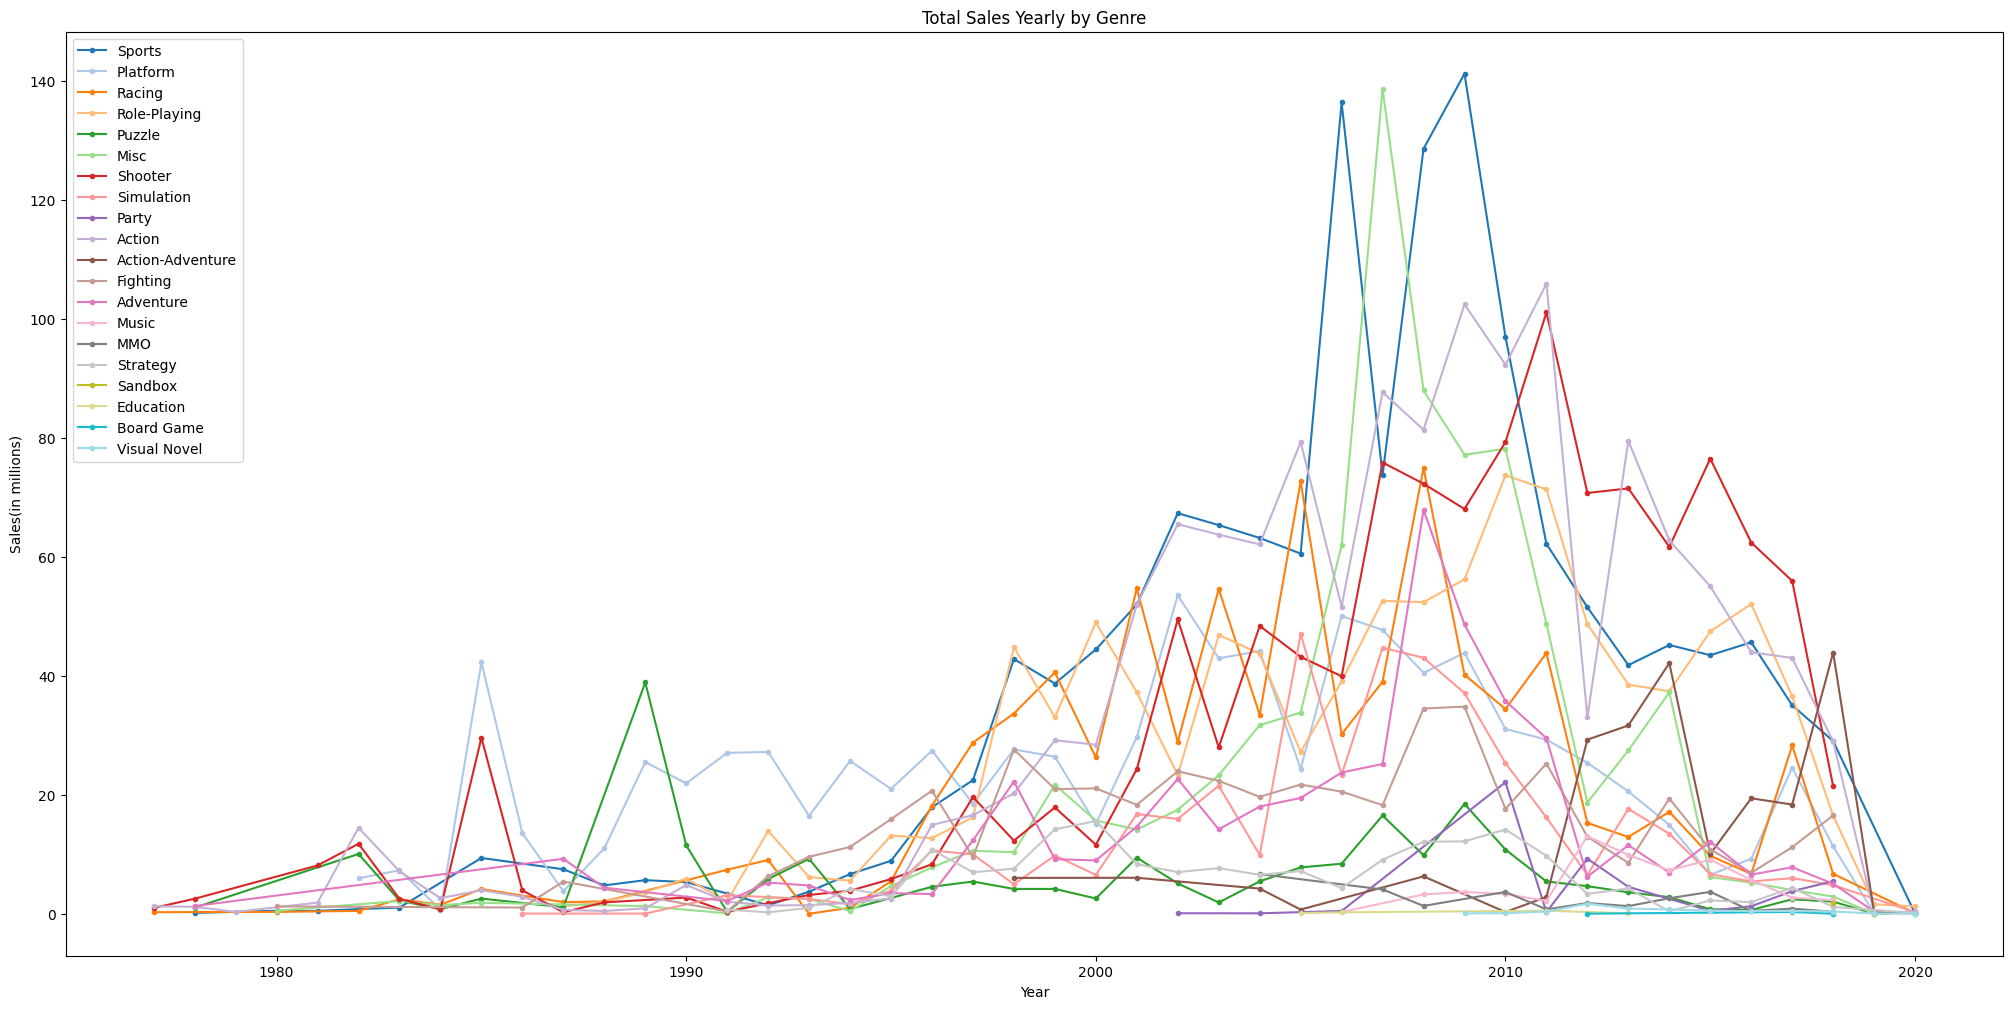

In [48]:
genre_yearly_sales = df.groupby(['Genre','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for genre in genre_list:
    genre_sales = genre_yearly_sales[genre_yearly_sales['Genre'] == genre]
    plt.plot(genre_sales['Release_date'], genre_sales['Sales_Globe'], label = genre,marker='.',color = cmap(i))
    i = i+1


plt.title('Total Sales Yearly by Genre')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend(loc='upper left')
plt.show()

This shows that there is much more fluctuation in the year to year sales for many genres. We see that many genres seem to sell good one year, decreace the next year before increasing again. The most extreme of these jumps is seen in the sports genre  between the years 2006-2008. We see sports games fall a large amount in 2007. We also see that action games have a large spike in sales around 2013 that matches the increase in games released. In general we see pattersn very similar to our overall sales, an increase until around 2008-2010 before a large drop off.

In [49]:
#Best selling game per genre

idx_genre = df.groupby(['Genre'])['Sales_Globe'].idxmax()
max_sales_genre = df.loc[idx_genre][['Genre','Name','Sales_Globe']]

max_sales_genre

Genre                                  Name  Sales_Globe
16              Action         Grand Theft Auto: San Andreas        20.81
37    Action-Adventure                 Red Dead Redemption 2        13.94
109          Adventure  The Legend of Zelda: Ocarina of Time         7.60
6241        Board Game          Monopoly for Nintendo Switch         0.30
4085         Education    Sesame Street: Once Upon A Monster         0.52
45            Fighting               Super Smash Bros. Brawl        12.91
151                MMO                     World of Warcraft         6.35
7                 Misc                              Wii Play        28.92
129              Music                          Just Dance 4         6.89
14               Party                    Kinect Adventures!        22.10
1             Platform                     Super Mario Bros.        40.24
5               Puzzle                                Tetris        30.26
2               Racing                        Mario Kart Wii        35.98
4         Role-Playing    Pokémon Red / Green / Blue Version        31.37
1003           Sandbox                             Minecraft         1.89
9              Shooter                             Duck Hunt        28.31
10          Simulation                            Nintendogs        24.68
0               Sports                            Wii Sports        82.65
192           Strategy                       Pokémon Stadium         5.45
8253      Visual Novel                           Steins;Gate         0.19

**Platform Data**

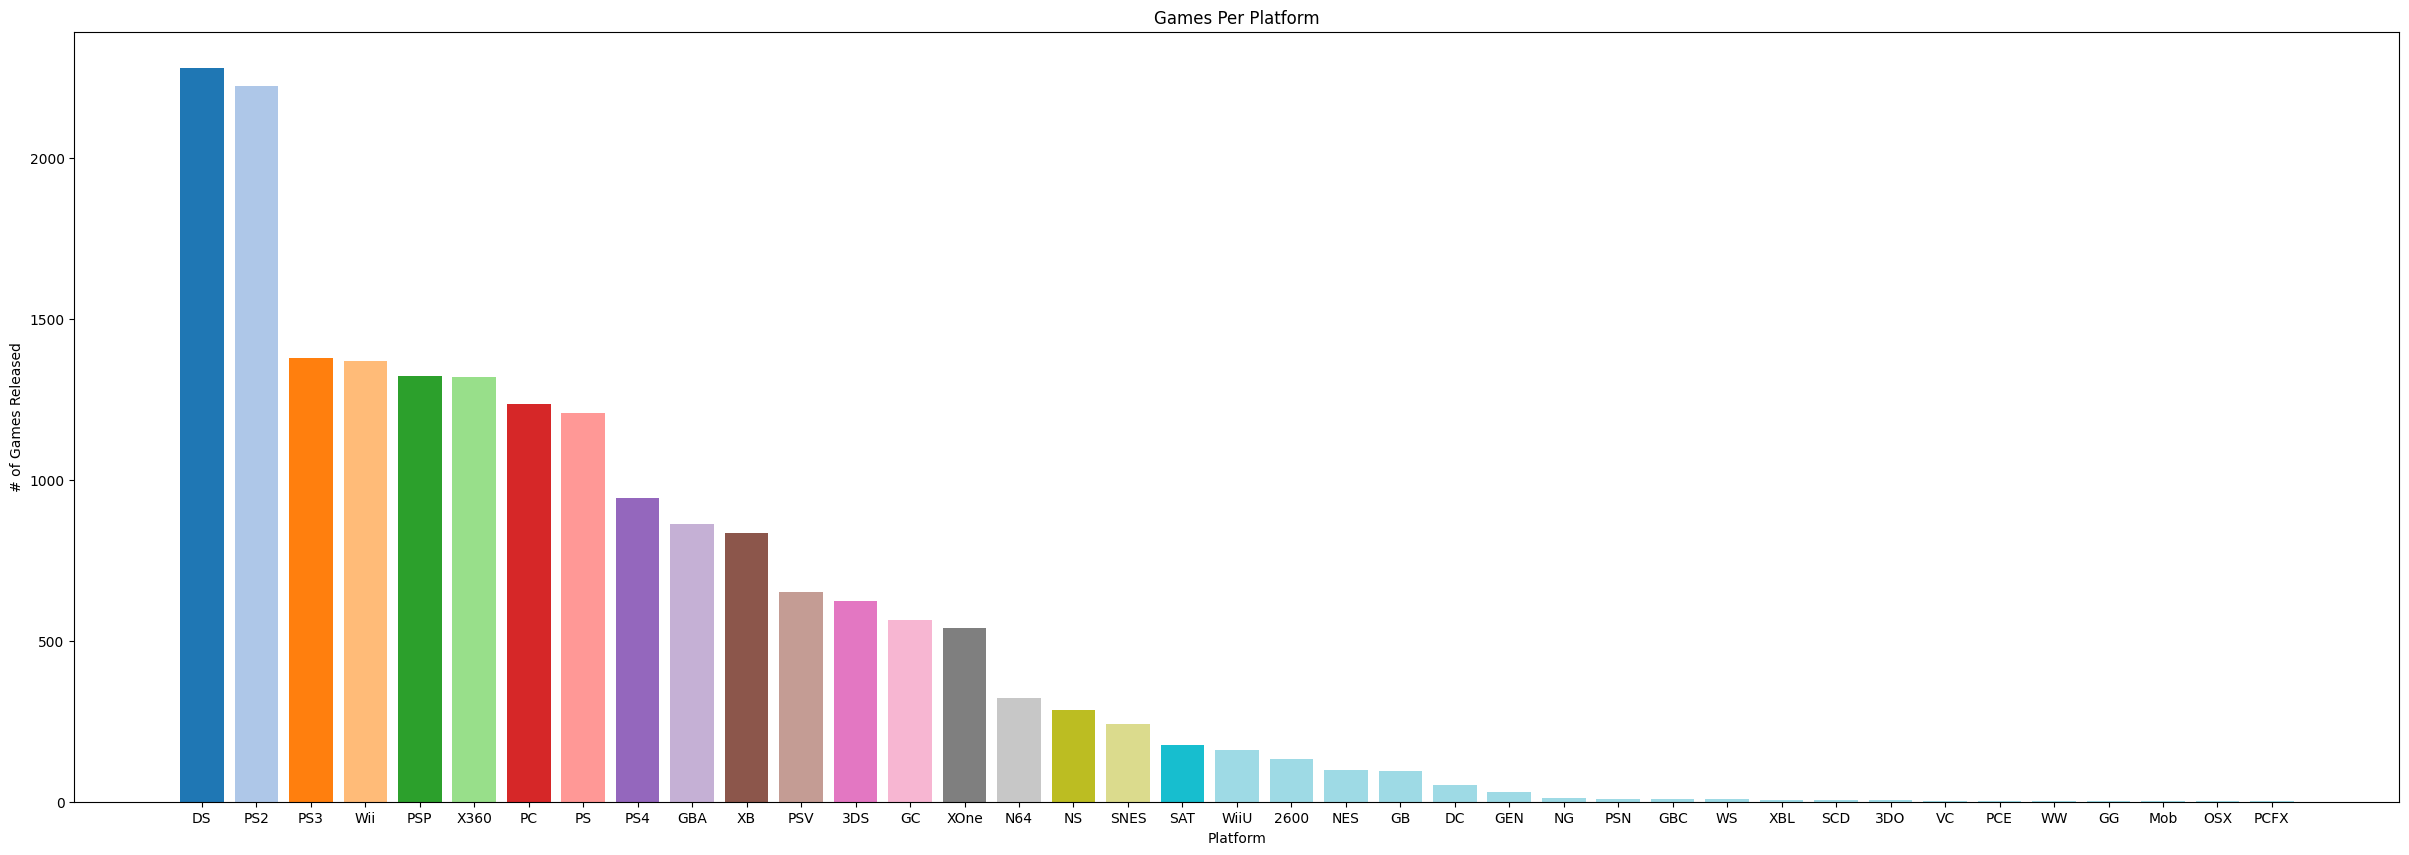

In [50]:
platform_total_releases = df.groupby(['Platform'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df['Platform'].unique()))/(0.5*len(df['Platform'].unique())))

plt.figure(figsize = (30,10))
plt.bar(platform_total_releases['Platform'],platform_total_releases['Sales_Globe'],color=cs)
plt.title('Games Per Platform')
plt.ylabel('# of Games Released')
plt.xlabel('Platform')
plt.show()

DS and PS2 have the most titles compared to all other consoles. PS3, Wii, PSP, XBox360, PC and PS come in behind afte a large drop in catelog size. Aftre the PS we begin to see a large drop in game catelogs for platforms again. Some of this can be explaned by the age of consoles. Older consoles like the NES came out at a time where less games were coming out and newer ones like the XBox One and PS5 have only been out for a couple of years and their catalogs will continue to expand. 

The DS came out in 2004 and was supported by Nintendo across several iterations, before the 3DS came out. This console was at its most popular during the peak years we see that games where released. This is reflected by the overwhelming amount of titles that are supported by the DS.

The PS2 is a little more surprising to see come in at second at first but there a few factors that can explain why the PS2 has so many more titles than the PS3 even though we see that the PS3 was the newer console around the 2008/2009 spike we see in games released. One reason is the PS2 came out 6 years earlier giving it a head start to grow its catalog size. The second reason is that even though the PS3 was released in 2006, many of the titles that came out on PS3 also came out on PS2 until about 2013. Even though the PS2 may not have been the main platform of focus it remained relavent long into the PS3's life cycle. 

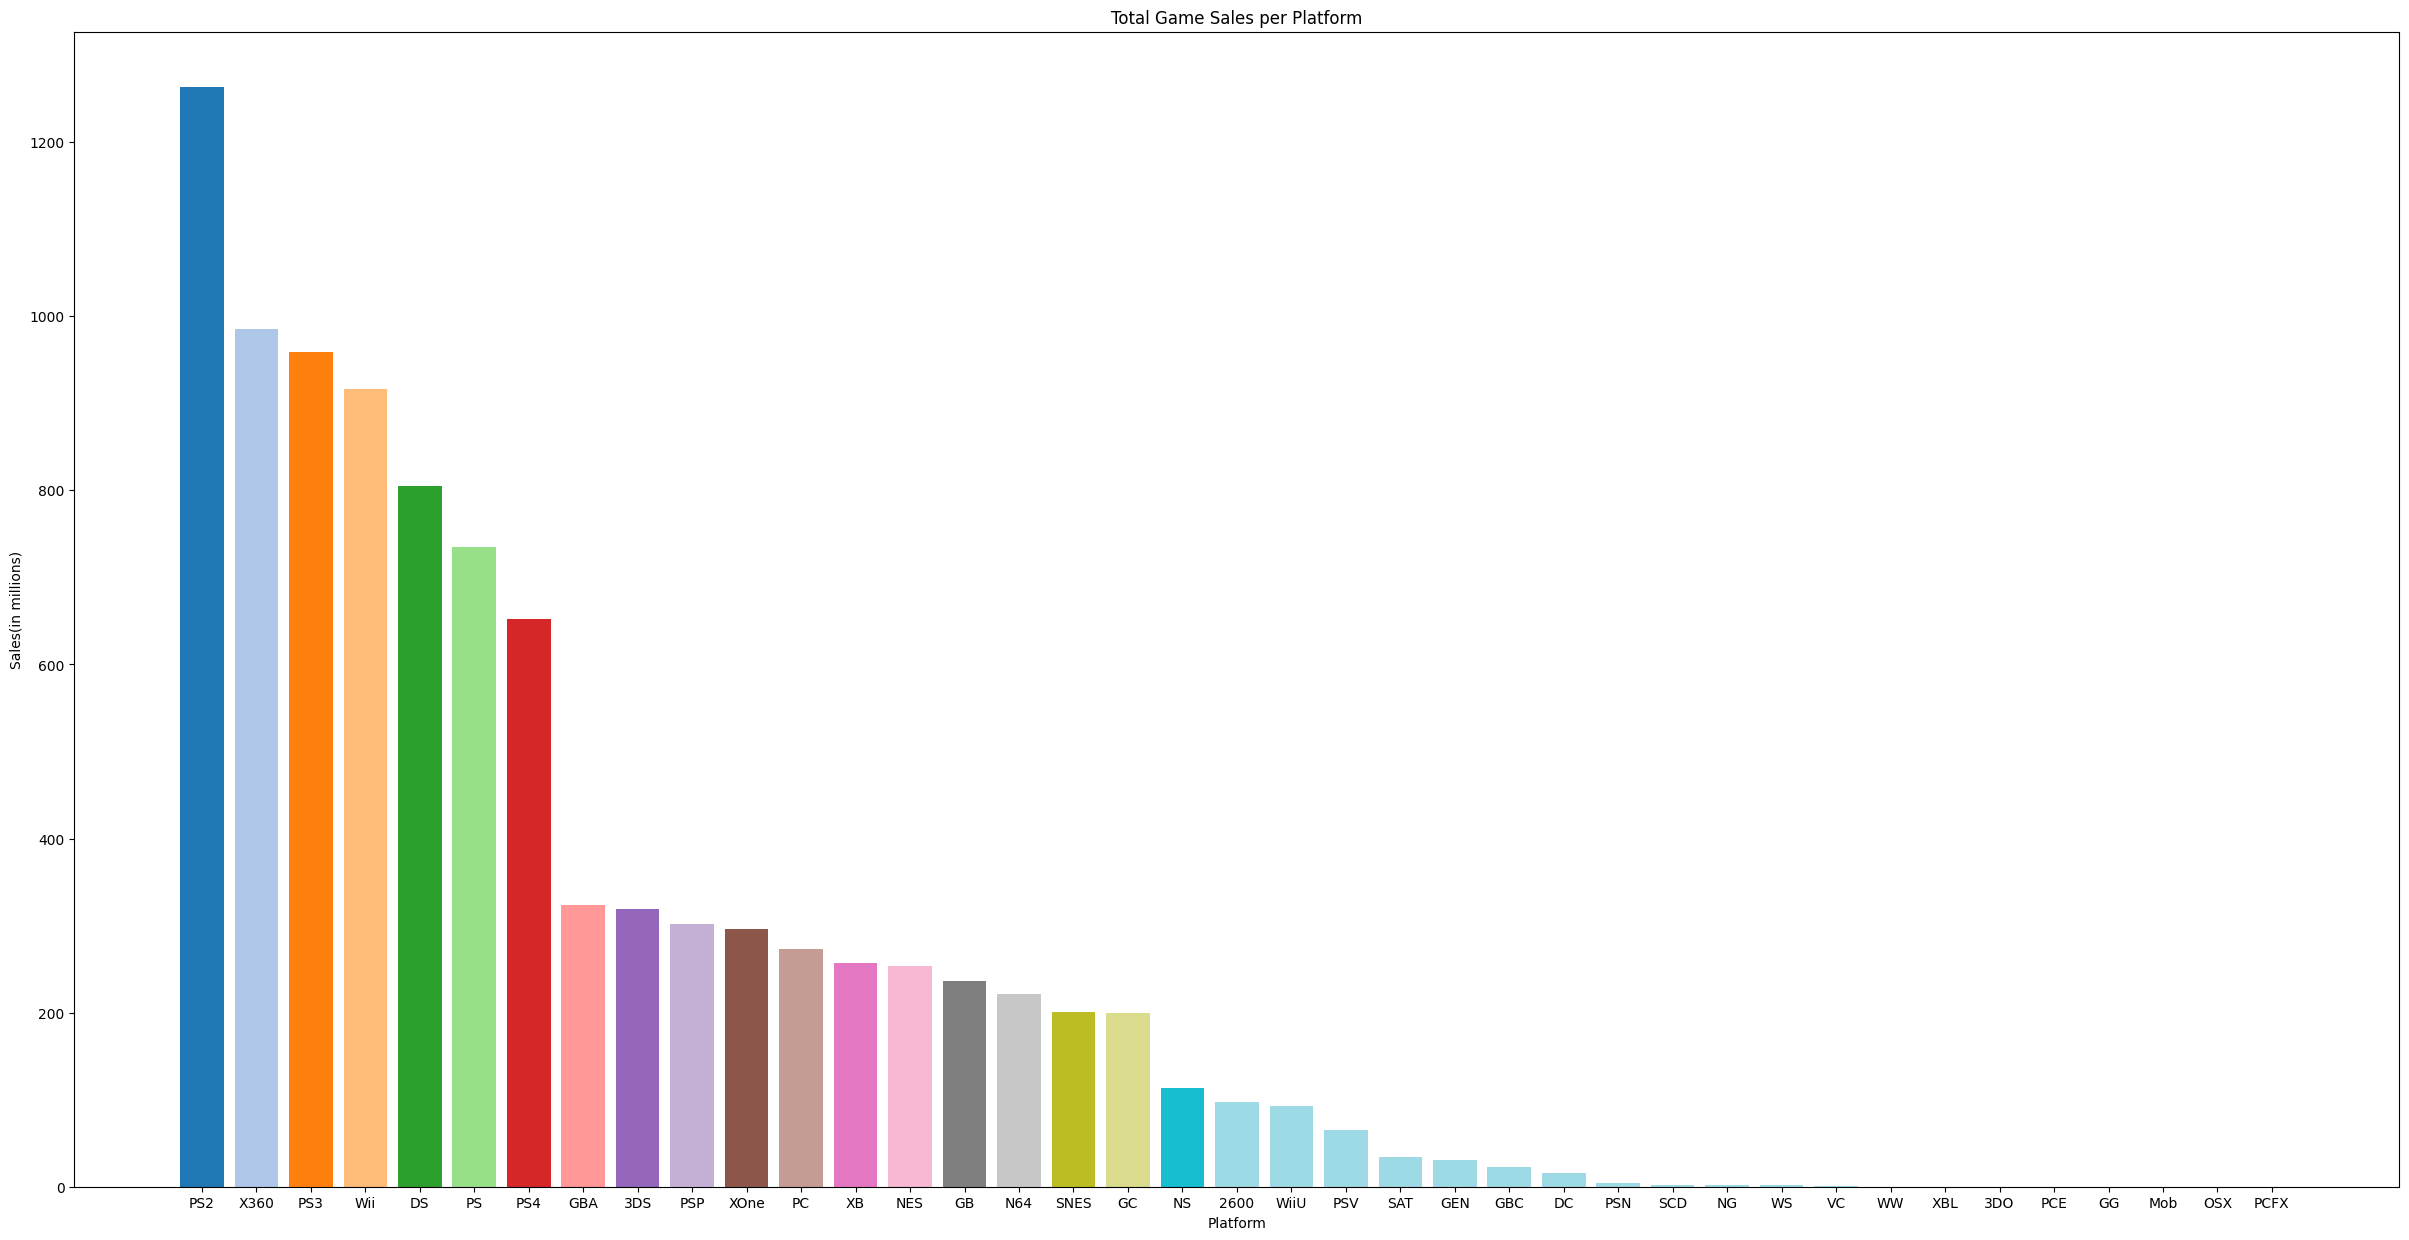

In [51]:
platform_total_sales = df.groupby(['Platform'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df['Platform'].unique()))/(0.5*len(df['Platform'].unique())))

plt.figure(figsize =(30,15))
plt.bar(platform_total_sales['Platform'],platform_total_sales['Sales_Globe'],color=cs)
plt.title('Total Game Sales per Platform')
plt.xlabel('Platform')
plt.ylabel('Sales(in millions)')
plt.show()

DS falls to 5th in total sales, behind PS2, XBox360, PS3 and Wii, despite beings ranked 1st in catalog size. One large contributing factor is the price points for games on these platforms. Games on the PS2, X360, PS3 and Wii all cost on average $50-$60 when released while the average DS game was $40. This fall in rank is not necessarily indicating that DS games are performing worse than these others but is instead caused by the discrepancy in game prices for platforms.

Our data contains 39 different platforms that games were released on. To simplify this I will focus on the 10 platforms. We will include the top 7 best selling platfomrs and the 3 newest platforms(PS4, XBox One and Nintendo Switch) from the 3 major plaform developers(Sony, Microsoft and Nintendo). This will cover the platforms with the most data while also giving us representation for more recent data.

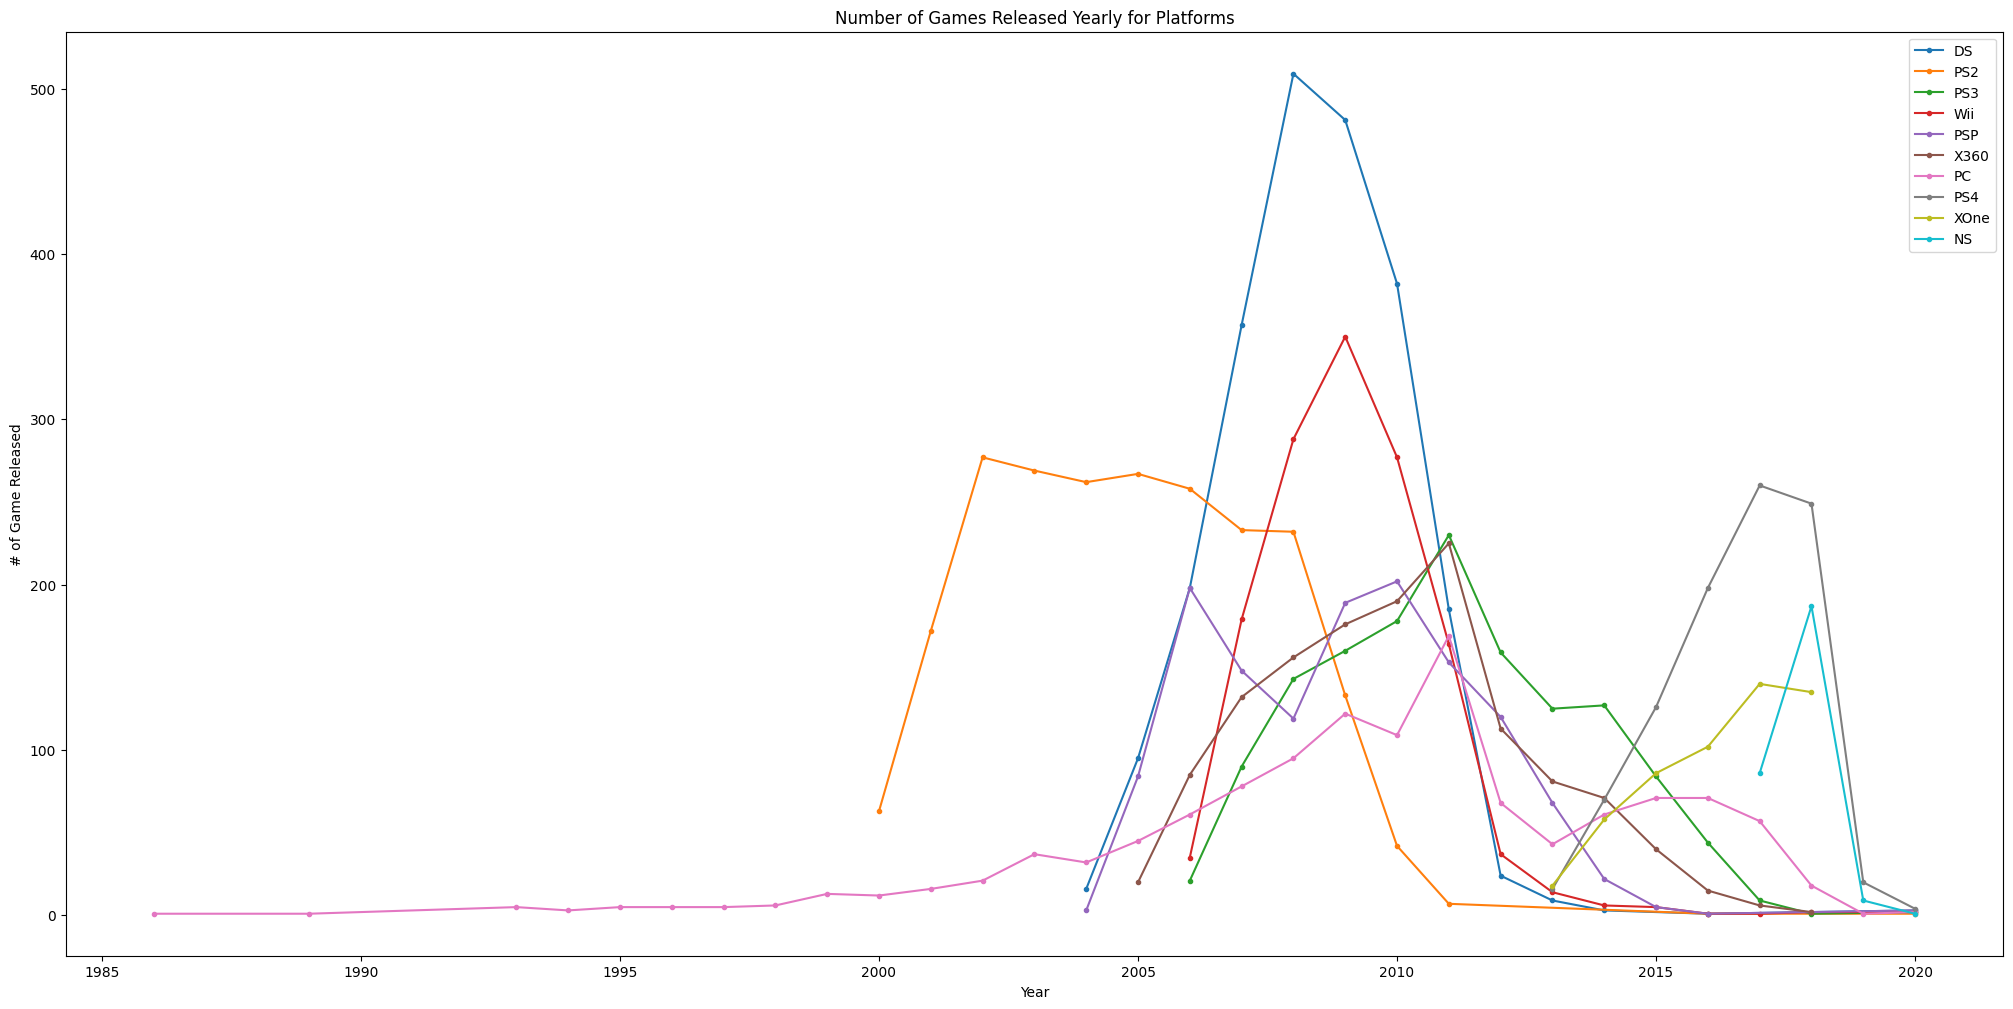

In [52]:
#look at console information
console_list = ['DS','PS2','PS3','Wii','PSP','X360','PC','PS4','XOne','NS']

console_yearly_releases = df.groupby(['Platform','Release_date'],as_index=False,sort=True)['Platform'].size()

plt.figure(figsize=(25,12))

for console in console_list:
    console_release = console_yearly_releases[console_yearly_releases['Platform'] == console]
    plt.plot(console_release['Release_date'], console_release['size'], label = console,marker='.')


plt.title('Number of Games Released Yearly for Platforms')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend()
plt.show()

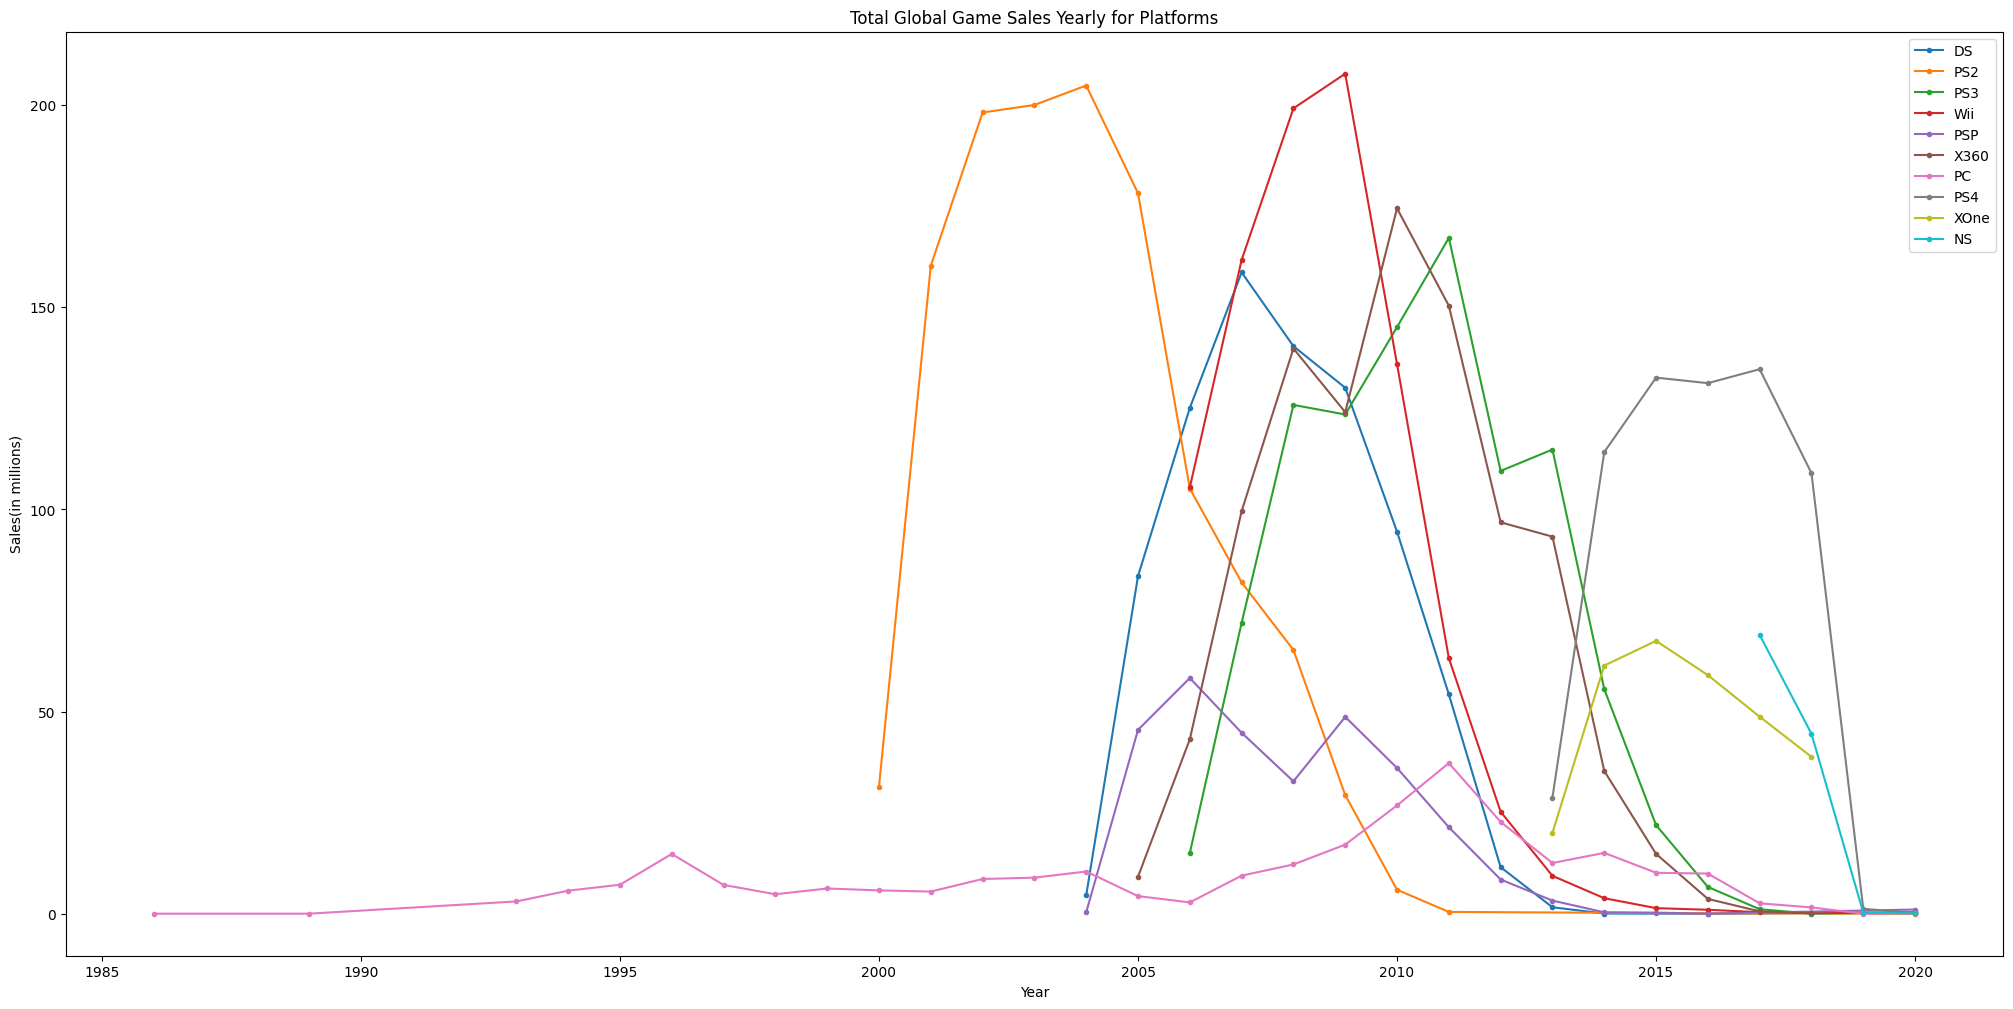

In [53]:
console_yearly_sales = df.groupby(['Platform','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

plt.figure(figsize=(25,12))

for console in console_list:
    console_sales = console_yearly_sales[console_yearly_sales['Platform'] == console]
    plt.plot(console_sales['Release_date'], console_sales['Sales_Globe'], label = console,marker='.')

plt.title('Total Global Game Sales Yearly for Platforms')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

XBox360 and PS3 are the only 2 platforms that have have positive growth in total game sales after 2009, when all sales fall. This positive growth is relatively short lived as we see another large drop off around 2013. This drop off was largely affected by the release of both the PS4 and XBox One. The newer versions of both consoles being released meant more people were moving on to the next platform.

In [54]:
#Genre with most releases per Platform for Top 7 platforms
df_top_7_platforms = df.loc[df['Platform' ].isin(console_list)]

game_release_per_console_per_genre = df_top_7_platforms.groupby(['Platform','Genre'])['Genre'].count().sort_values().groupby(level=0).tail(1)

game_release_per_console_per_genre

Platform  Genre    
NS        Action        48
XOne      Action       106
PS4       Action       191
PSP       Adventure    224
PC        Strategy     231
X360      Sports       239
PS3       Action       276
Wii       Misc         284
PS2       Sports       408
DS        Misc         410
Name: Genre, dtype: int64

In [55]:
#Genre with most sales per Platform
#Output for this is the total sales of games in that genre in millions
game_sales_per_console_per_genre = df_top_7_platforms.groupby(['Platform','Genre'])['Sales_Globe'].sum().sort_values().groupby(level=0).tail(1)

game_sales_per_console_per_genre

Platform  Genre     
NS        Platform       20.91
PSP       Action         52.60
PC        Simulation     57.61
XOne      Shooter        98.86
DS        Misc          147.90
PS4       Shooter       148.21
PS3       Action        217.75
PS2       Sports        276.79
X360      Shooter       284.40
Wii       Sports        291.38
Name: Sales_Globe, dtype: float64

In [56]:
#best selling games for 10 platforms
game_sales_per_console_id = df.groupby(df['Platform'],as_index=False,sort=True)['Sales_Globe'].idxmax()

max_game_DS = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'DS']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PS2 = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PS2']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PS3 = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PS3']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_Wii = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'Wii']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PSP = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PSP']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_X360 = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'X360']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PC = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PC']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PSP = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PSP']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_X360 = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'X360']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PC = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PC']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PS4 = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'PS4']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_XOne = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'XOne']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_NS = np.array(df.loc[game_sales_per_console_id[game_sales_per_console_id['Platform'] == 'NS']['Sales_Globe']][['Name','Genre','Sales_Globe']])


max_games_name = [max_game_DS[0][0],max_game_PS2[0][0],max_game_PS3[0][0],max_game_Wii[0][0],max_game_PSP[0][0],max_game_X360[0][0],max_game_PC[0][0],max_game_PS4[0][0],max_game_XOne[0][0],max_game_NS[0][0]]
max_games_genre = [max_game_DS[0][1],max_game_PS2[0][1],max_game_PS3[0][1],max_game_Wii[0][1],max_game_PSP[0][1],max_game_X360[0][1],max_game_PC[0][1],max_game_PS4[0][1],max_game_XOne[0][1],max_game_NS[0][1]]
max_games_sales = [max_game_DS[0][2],max_game_PS2[0][2],max_game_PS3[0][2],max_game_Wii[0][2],max_game_PSP[0][2],max_game_X360[0][2],max_game_PC[0][2],max_game_PS4[0][2],max_game_XOne[0][2],max_game_NS[0][2]]

#set up dataframe
most_sales_per_console = pd.DataFrame(data = {
    'Console' : console_list,
    'Name' : max_games_name,
    'Genre' : max_games_genre,
    'Sales(million)' : max_games_sales
})

most_sales_per_console

Console                                    Name       Genre  Sales(million)
0      DS                   New Super Mario Bros.    Platform           29.85
1     PS2           Grand Theft Auto: San Andreas      Action           20.81
2     PS3                      Grand Theft Auto V      Action           20.32
3     Wii                              Wii Sports      Sports           82.65
4     PSP  Grand Theft Auto: Liberty City Stories      Action            7.72
5    X360                      Kinect Adventures!       Party           22.10
6      PC                              The Sims 3  Simulation            7.96
7     PS4                      Grand Theft Auto V      Action           19.39
8    XOne                      Grand Theft Auto V      Action            8.72
9      NS                     Mario Kart 8 Deluxe      Racing           13.05

Many of the best performing genres per console all into a faster-pace gameplay and are from genres we expect them to. We also see that the best selling games per console also fall into this trend. One thing to take note of is that games like Wii sports and Kinect Adventures are both games that were sold as a bundle with their respective consoles which largely contributes to why their sales seem to be so successful for those platforms.

**Publisher Data**

We have a lot of different publishers and trying to fit them all on one graph would be unreadable and not useful. Instead we will focus on the top 10 publishers in terms of catalog size and overall sales, and group the rest into a single entry 'Other'.

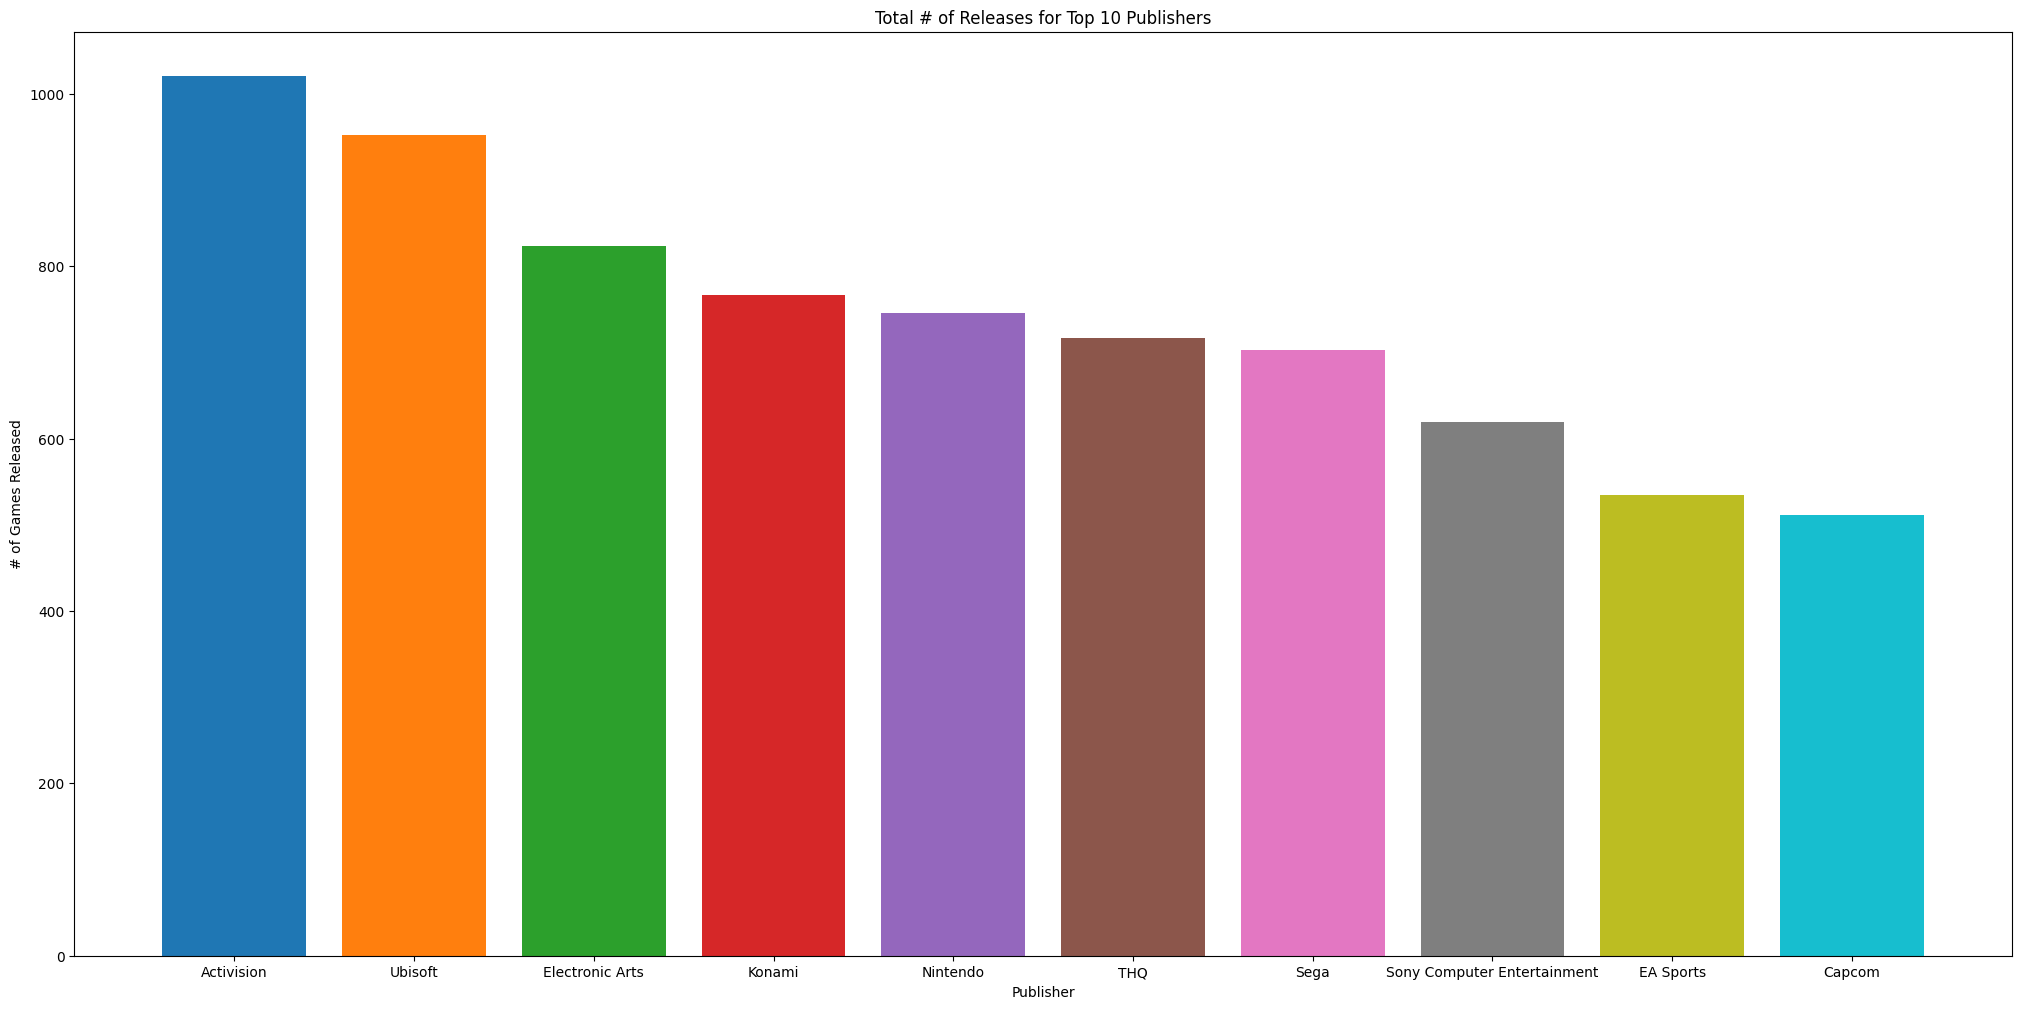

In [57]:
publisher_total_releases = df.groupby(['Publisher'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 publishers
top_10_publishers_releases = pd.DataFrame(publisher_total_releases[:10])

#The rest of the publishers
other_publishers_releases = pd.DataFrame(publisher_total_releases[10:])

#Add all other publisher info together and put under name 'Other'
top_10_publishers_others_releases = top_10_publishers_releases.copy()
top_10_publishers_others_releases.loc[len(top_10_publishers_others_releases.index)] = ['Others',other_publishers_releases['Sales_Globe'].count()]

cs = plt.cm.tab20(np.arange(len(top_10_publishers_releases['Publisher'].unique()))/(len(top_10_publishers_releases['Publisher'].unique())))

plt.figure(figsize =(25,12))
plt.bar(top_10_publishers_releases['Publisher'],top_10_publishers_releases['Sales_Globe'],color=cs)
plt.title('Total # of Releases for Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('# of Games Released')
plt.show()

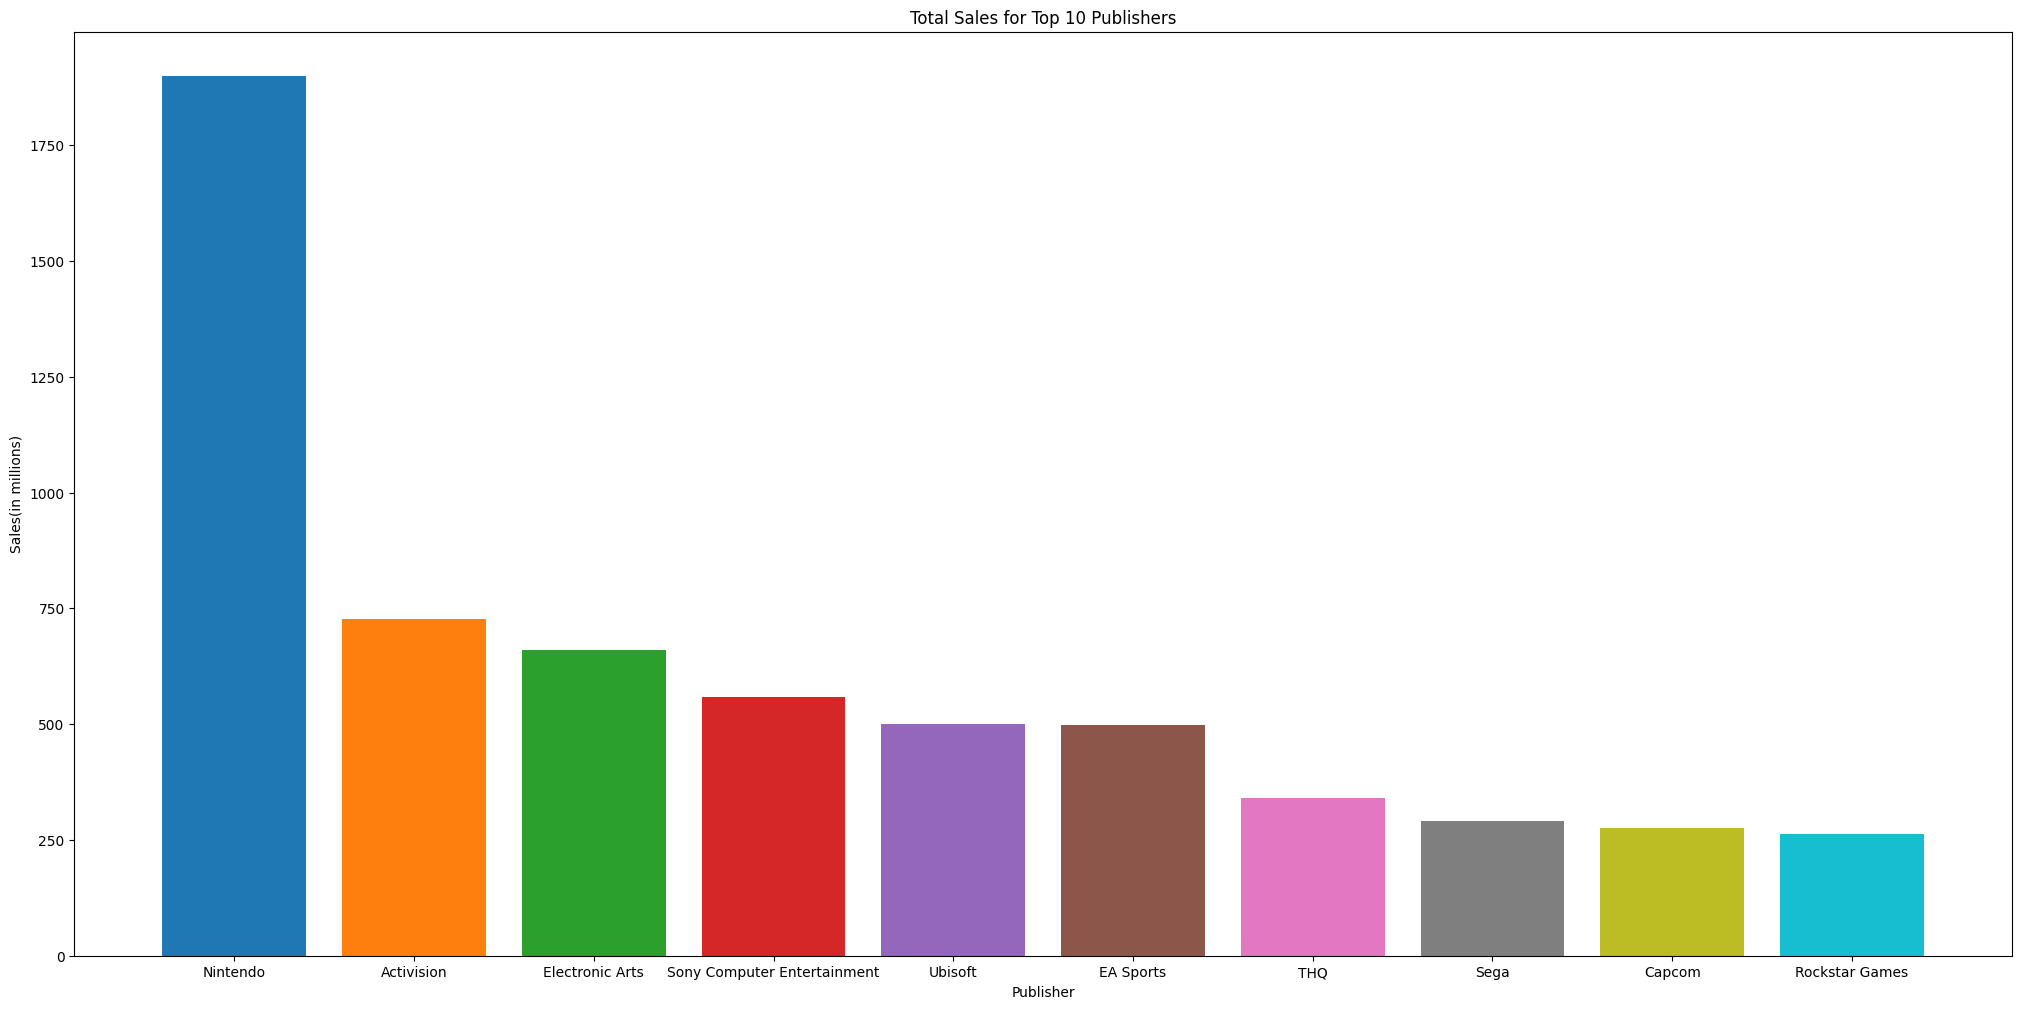

In [58]:
publisher_total_sales = df.groupby(['Publisher'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 publishers
top_10_publishers_sales = pd.DataFrame(publisher_total_sales[:10])

#The rest of the publishers
other_publishers_sales = pd.DataFrame(publisher_total_sales[10:])

#Add all other publisher info together and put under name 'Other'
top_10_publishers_others_sales = top_10_publishers_sales.copy()
top_10_publishers_others_sales.loc[len(top_10_publishers_others_sales.index)] = ['Others',other_publishers_sales['Sales_Globe'].sum()]

cs = plt.cm.tab20(np.arange(len(top_10_publishers_sales['Publisher'].unique()))/(len(top_10_publishers_sales['Publisher'].unique())))

plt.figure(figsize =(25,12))
plt.bar(top_10_publishers_sales['Publisher'],top_10_publishers_sales['Sales_Globe'],color=cs)
plt.title('Total Sales for Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Sales(in millions)')
plt.show()

We see that there is a lot of overlap in top 10 publishers that released the most games and the top 10 in terms of sales, but there are differences between where some publishers rankes in terms of releases vs sales. For example Nintendo is only ranked 5th for catalog size but is ranked 1 in total global sales. This indicates that on average Nintendo games sell better than any other publisher per title.

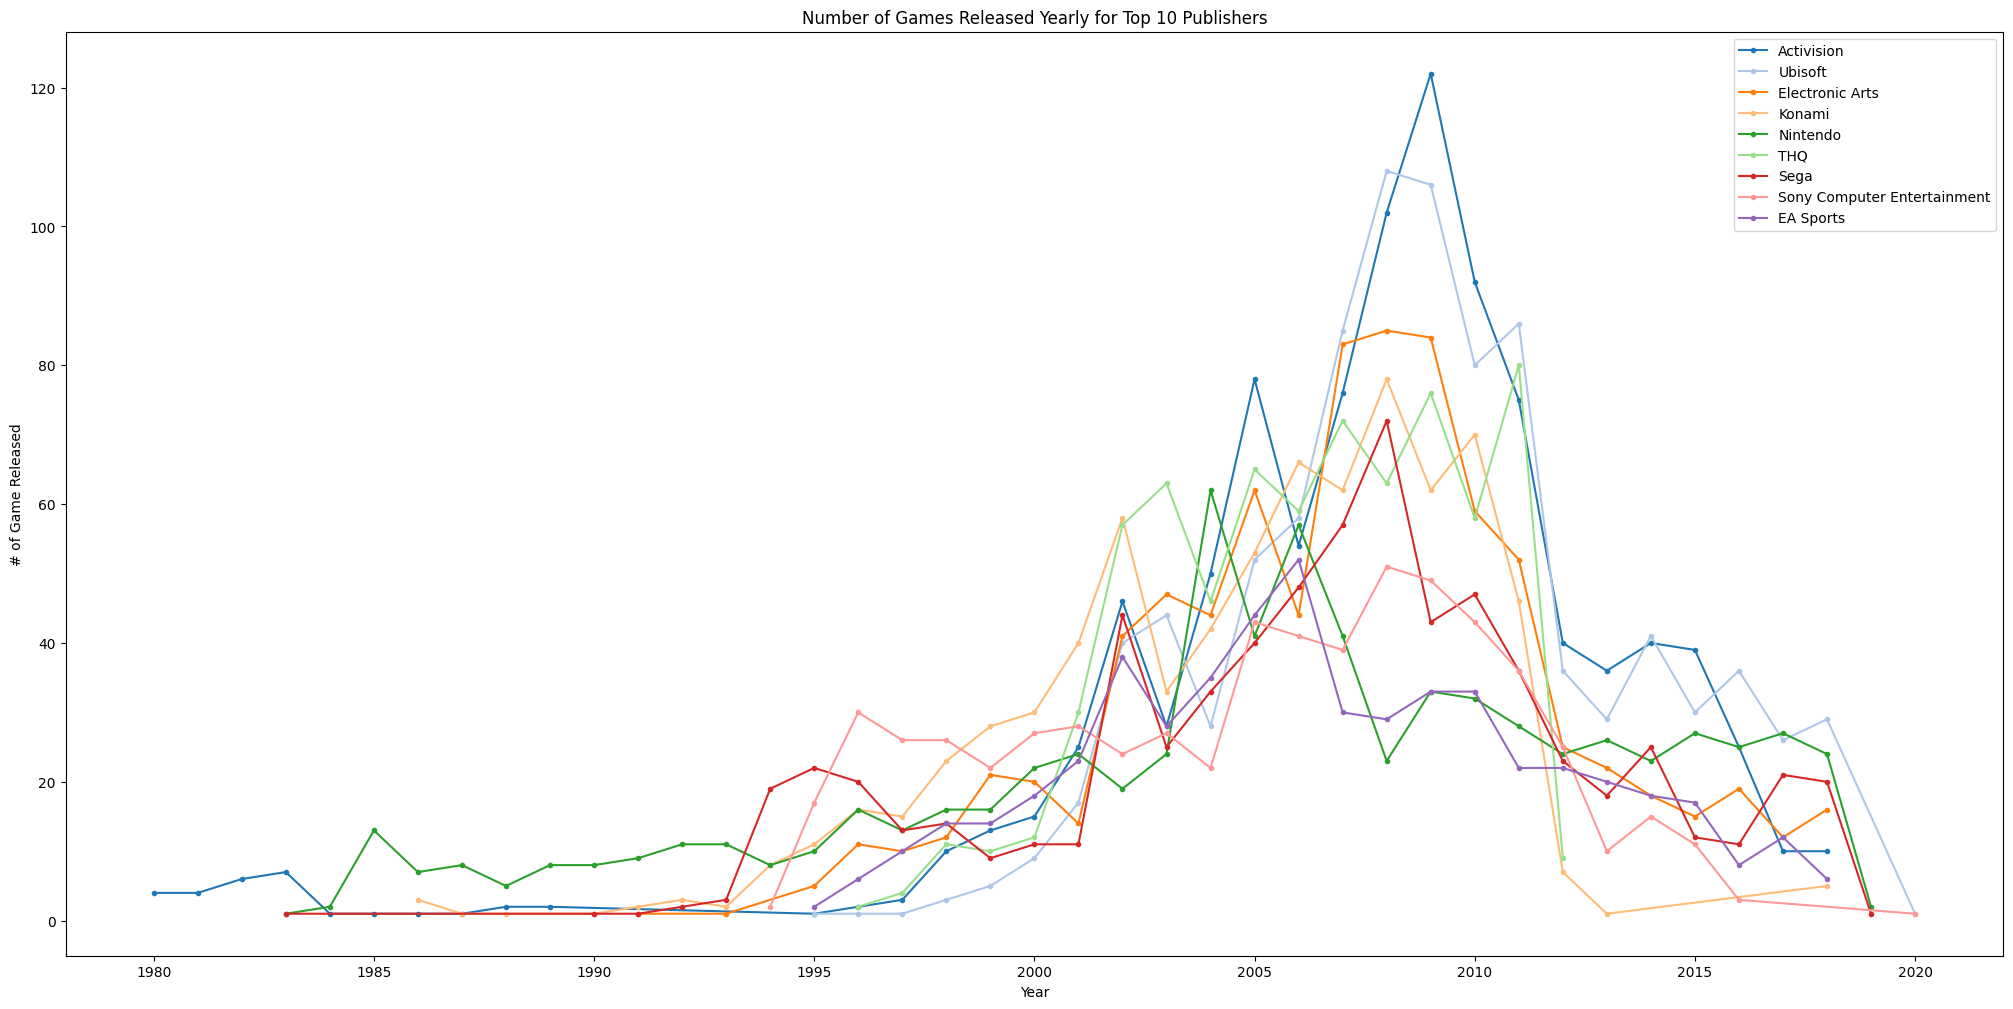

In [59]:
publisher_list_releases = top_10_publishers_releases['Publisher'].unique()[:-1]

publisher_yearly_releases = df.groupby(['Publisher','Release_date'],as_index=False,sort=True)['Publisher'].size()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for publisher in publisher_list_releases:
    publisher_release = publisher_yearly_releases[publisher_yearly_releases['Publisher'] == publisher]
    plt.plot(publisher_release['Release_date'], publisher_release['size'], label = publisher,marker='.',color = cmap(i))
    i = i+1


plt.title('Number of Games Released Yearly for Top 10 Publishers')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend()
plt.show()

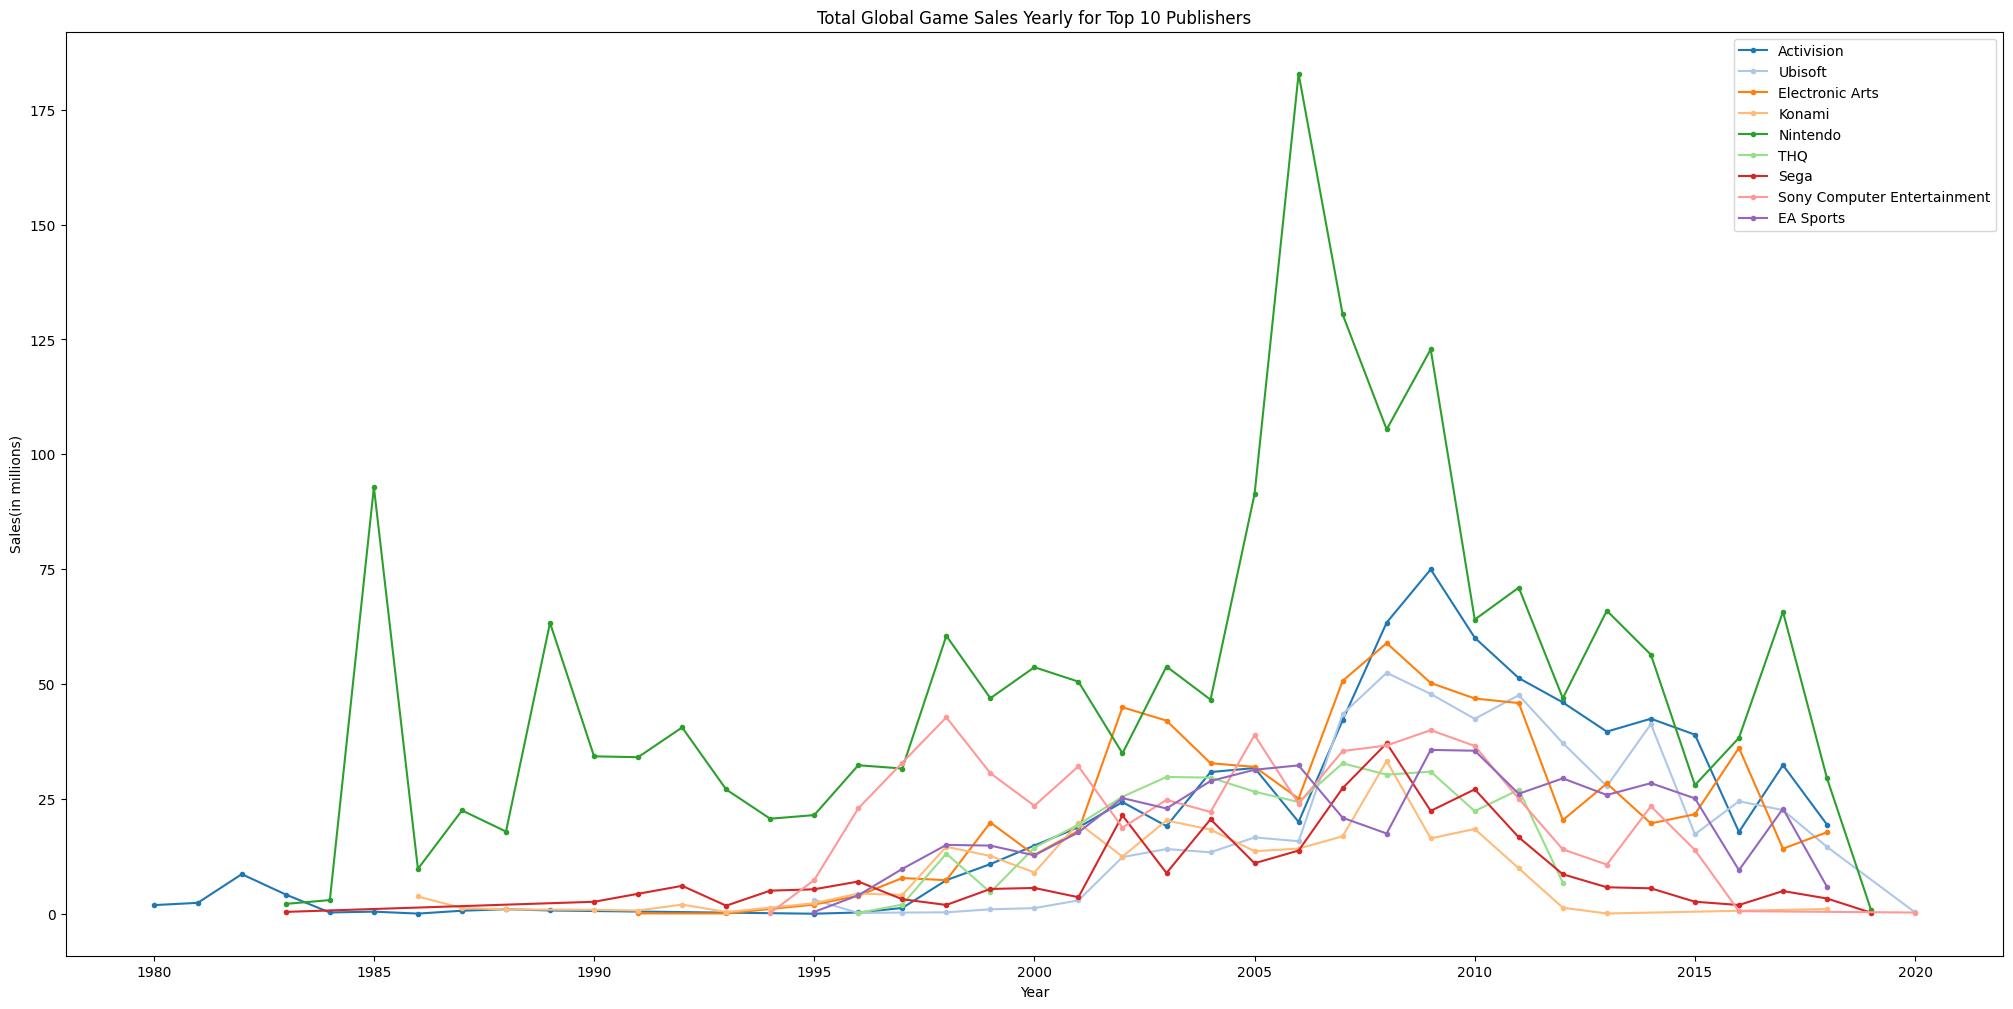

In [60]:
publisher_list_sales = top_10_publishers_sales['Publisher'].unique()[:-1]

publisher_yearly_sales = df.groupby(['Publisher','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

plt.figure(figsize=(25,12))

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

for publisher in publisher_list_releases:
    publisher_sales = publisher_yearly_sales[publisher_yearly_sales['Publisher'] == publisher]
    plt.plot(publisher_sales['Release_date'], publisher_sales['Sales_Globe'], label = publisher,marker='.',color = cmap(i))
    i = i + 1

plt.title('Total Global Game Sales Yearly for Top 10 Publishers')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

Nintendo consistently outsells all other publishers and at times completely dominates the market. 

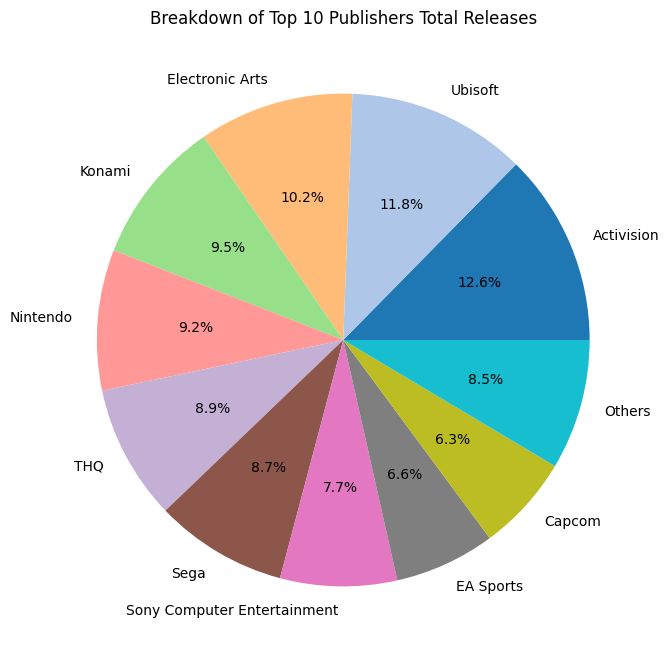

In [61]:
#Breakdown of average contributions of different publishers for releases pie graph

#Set color for graphing
cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(8,8))
plt.title('Breakdown of Top 10 Publishers Total Releases')
plt.pie(top_10_publishers_others_releases['Sales_Globe'],labels = top_10_publishers_others_releases['Publisher'],autopct='%1.1f%%',colors = cs)
plt.show()

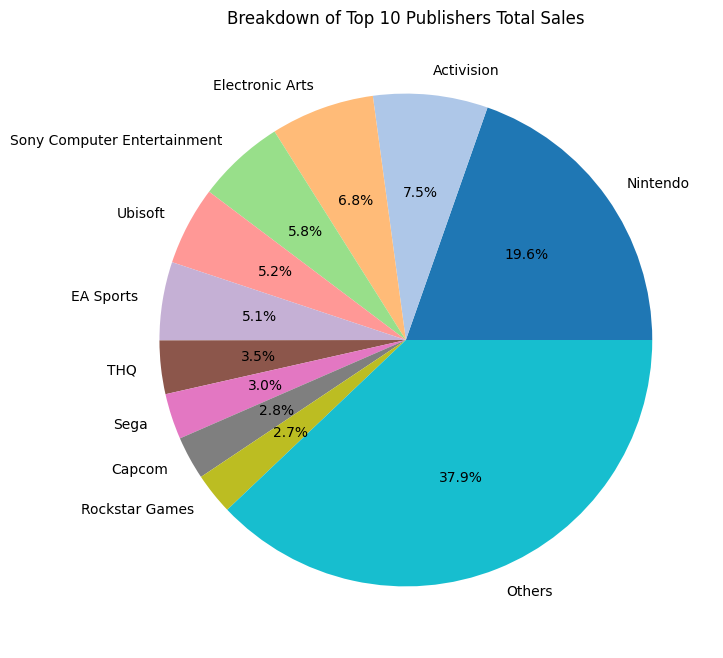

In [62]:
#Breakdown of average contributions of different publishers for sales pie graph

cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(8,8))
plt.title('Breakdown of Top 10 Publishers Total Sales')
plt.pie(top_10_publishers_others_sales['Sales_Globe'],labels = top_10_publishers_others_sales['Publisher'],autopct='%1.1f%%', colors = cs)
plt.show()

Nintendo by far out performas all other publisher in sales, especially compared to the amount of games they release.

**Developer Data**

Similarly to Publishers we have a lot od developers and will focus on the top 10 developers while putting the rest in a single entry 'Other'.

In [63]:
developer_total_releases = df.groupby(['Developer'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 developer
top_10_developer_releases = pd.DataFrame(developer_total_releases[1:11])

#The rest of the developer
other_developer_releases = pd.DataFrame(developer_total_releases[11:])

#We have 'Unknown' entry for Developer which means this database did not know the developer so we will not include it in our top 10 developer
other_developer_releases.loc[len(other_developer_releases.index)] = [developer_total_releases['Developer'].iloc[0],developer_total_releases['Sales_Globe'].iloc[0]]

#Add all other developer info together and put under name 'Other'
top_10_developer_releases.loc[len(top_10_developer_releases.index)] = ['Others',other_developer_releases['Sales_Globe'].sum()]

In [64]:
developer_total_sales = df.groupby(['Developer'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 developer
top_10_developer_sales = pd.DataFrame(developer_total_sales[:10])

#The rest of the developer
other_developer_sales = pd.DataFrame(developer_total_sales[10:])

# Add all other developer info together and put under name 'Other'
top_10_developer_sales.loc[len(top_10_developer_sales.index)] = ['Others',other_developer_sales['Sales_Globe'].sum()]

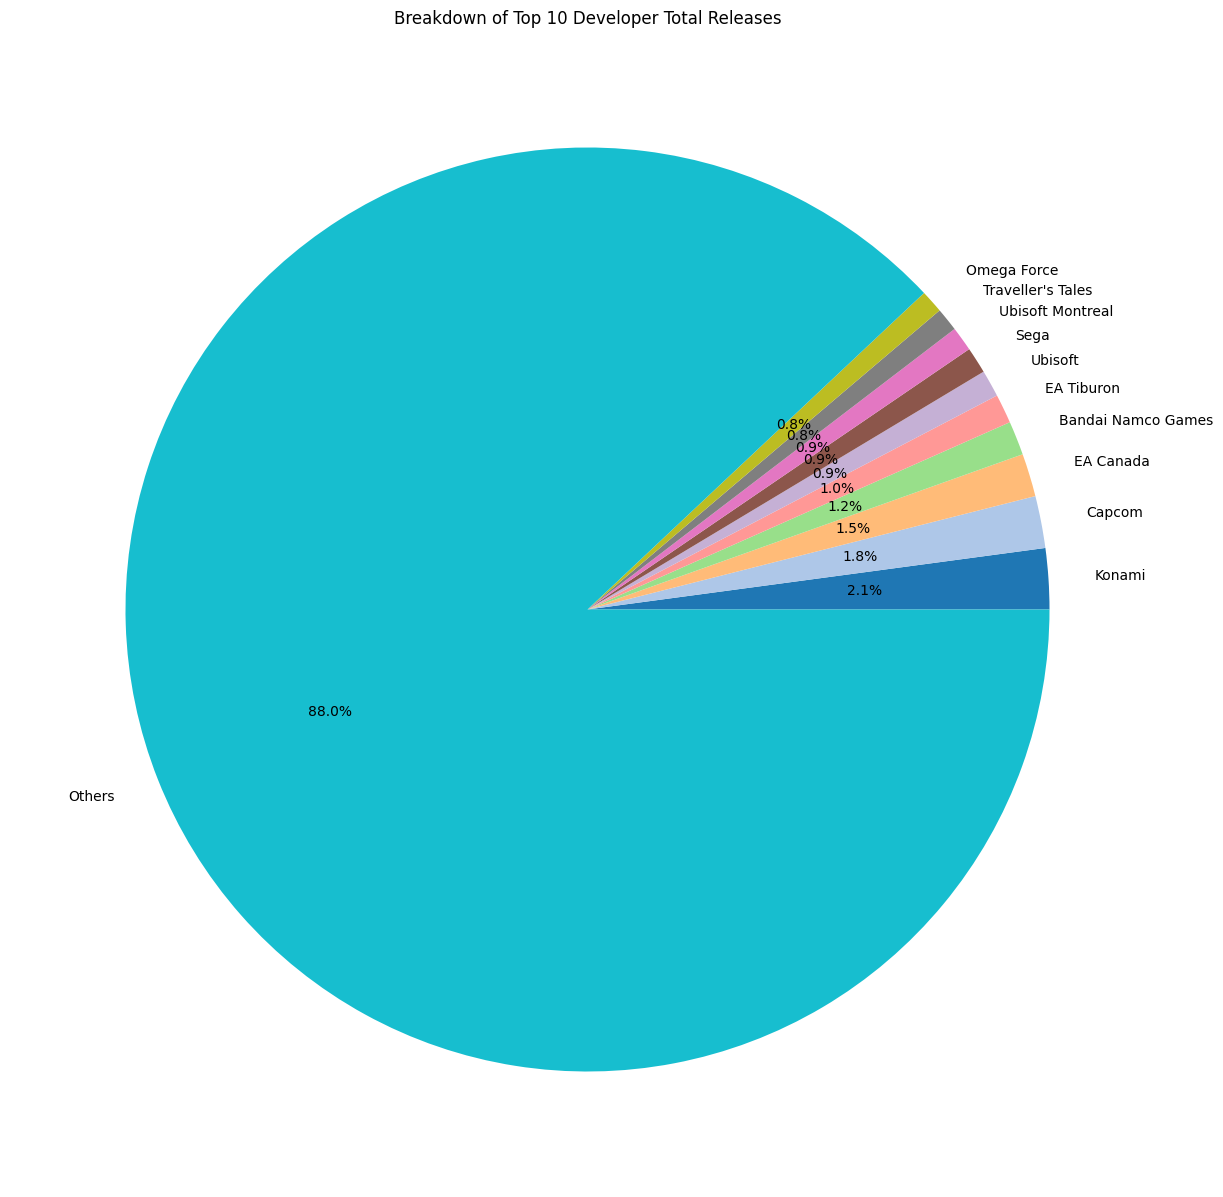

In [65]:
#Breakdown of average contributions of different developer for releases pie graph

#Set color for graphing
cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(15,15))
plt.title('Breakdown of Top 10 Developer Total Releases')
plt.pie(top_10_developer_releases['Sales_Globe'],labels = top_10_developer_releases['Developer'],autopct='%1.1f%%',colors = cs)
plt.show()

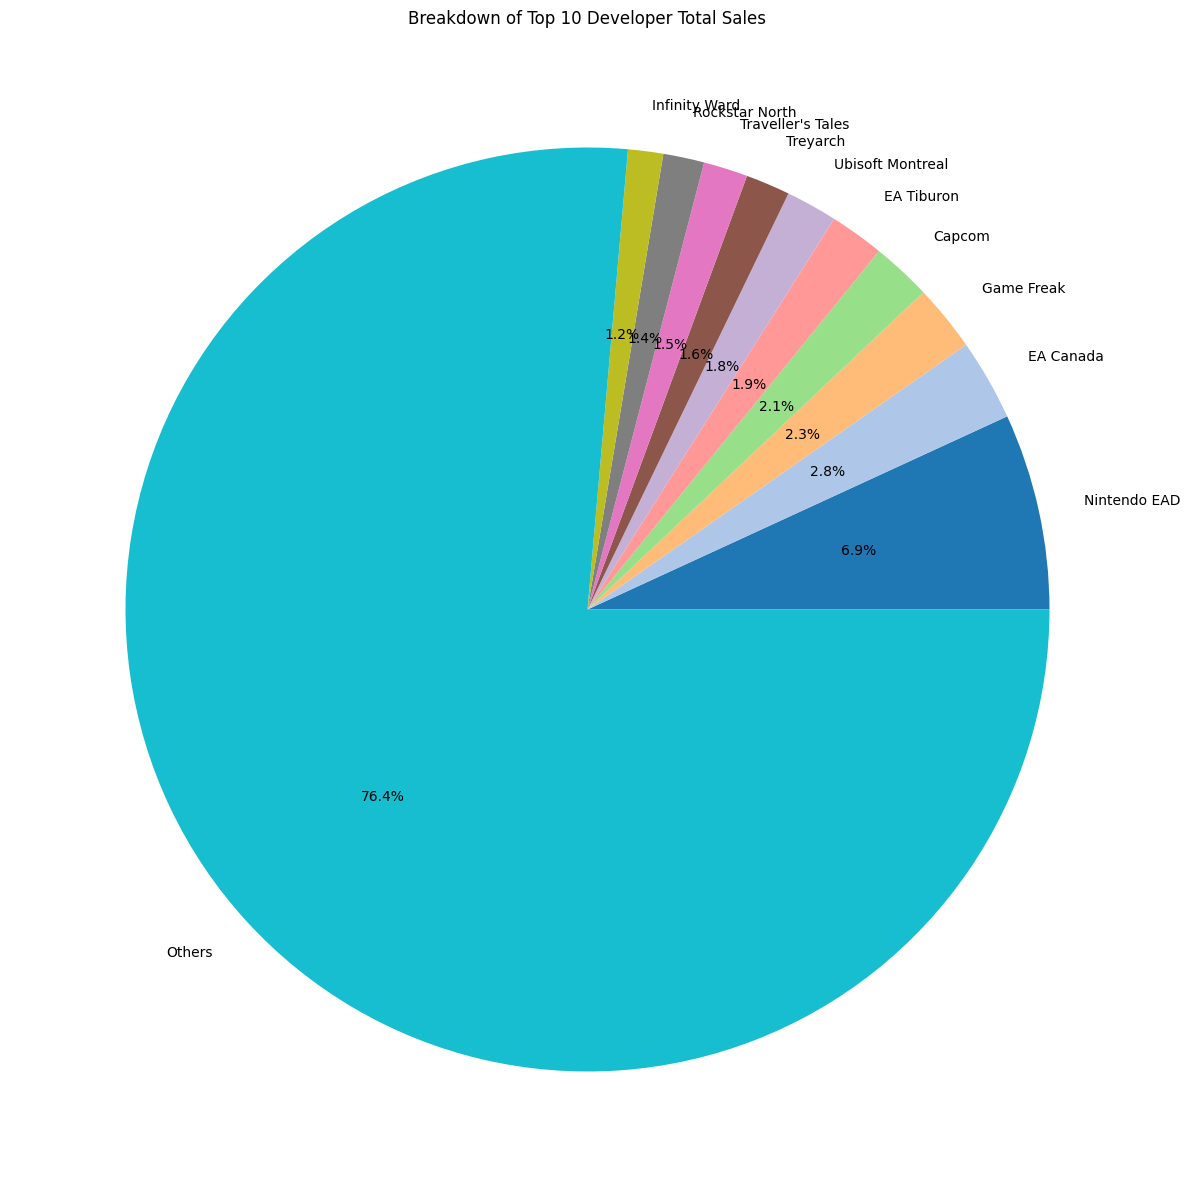

In [66]:
#Breakdown of average contributions of different developer for sales pie graph

cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(15,15))
plt.title('Breakdown of Top 10 Developer Total Sales')
plt.pie(top_10_developer_sales['Sales_Globe'],labels = top_10_developer_sales['Developer'],autopct='%1.1f%%', colors = cs)
plt.show()

Due to the large number of developers, extracting meaningful insights from this data is challenging. Additionally, there is significant overlap between publishers and developers, as many smaller development teams operate under larger publishing entities. For instance, games developed by EA Canada and EA Tiburon are exclusively published by EA, while Nintendo EAD and Game Freak titles are solely published by Nintendo. These factors make the developer data less useful and more difficult to incorporate effectively into a machine learning model so we will leave it out from further analysis.

**Regional Data**

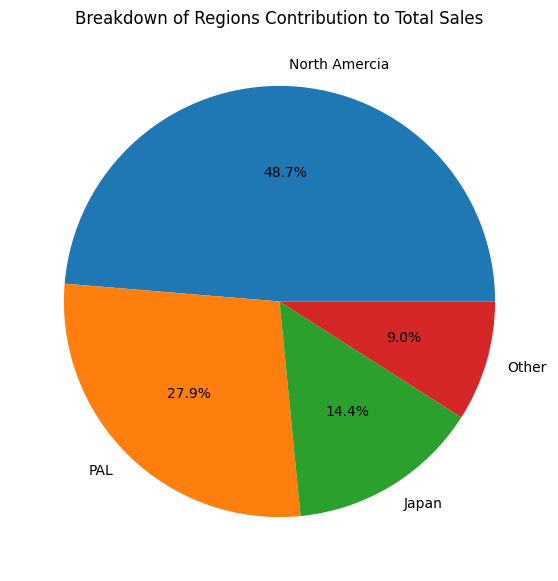

In [67]:
#look at regional information
#Breakdown of contributions of different markets
tot_sales = [np.sum(df['Sales_NA']),np.sum(df['Sales_PAL']),np.sum(df['Sales_JP']),np.sum(df['Sales_Other'])]
tot_labels = ['North Amercia','PAL','Japan','Other']

plt.figure(figsize=(7,7))
plt.title('Breakdown of Regions Contribution to Total Sales')
plt.pie(tot_sales,labels = tot_labels,autopct='%1.1f%%')
plt.show()

North America is largest market at least in terms of sales contributions with PAL coming in 2nd and Japan close behind. Something to consider is that we are missing a large amount of regional sales data, especially for Japan and PAL. This may have an impact on our regional distribution and leaves the possiblity that the North American market does not represent as much of our global sales as we see here.

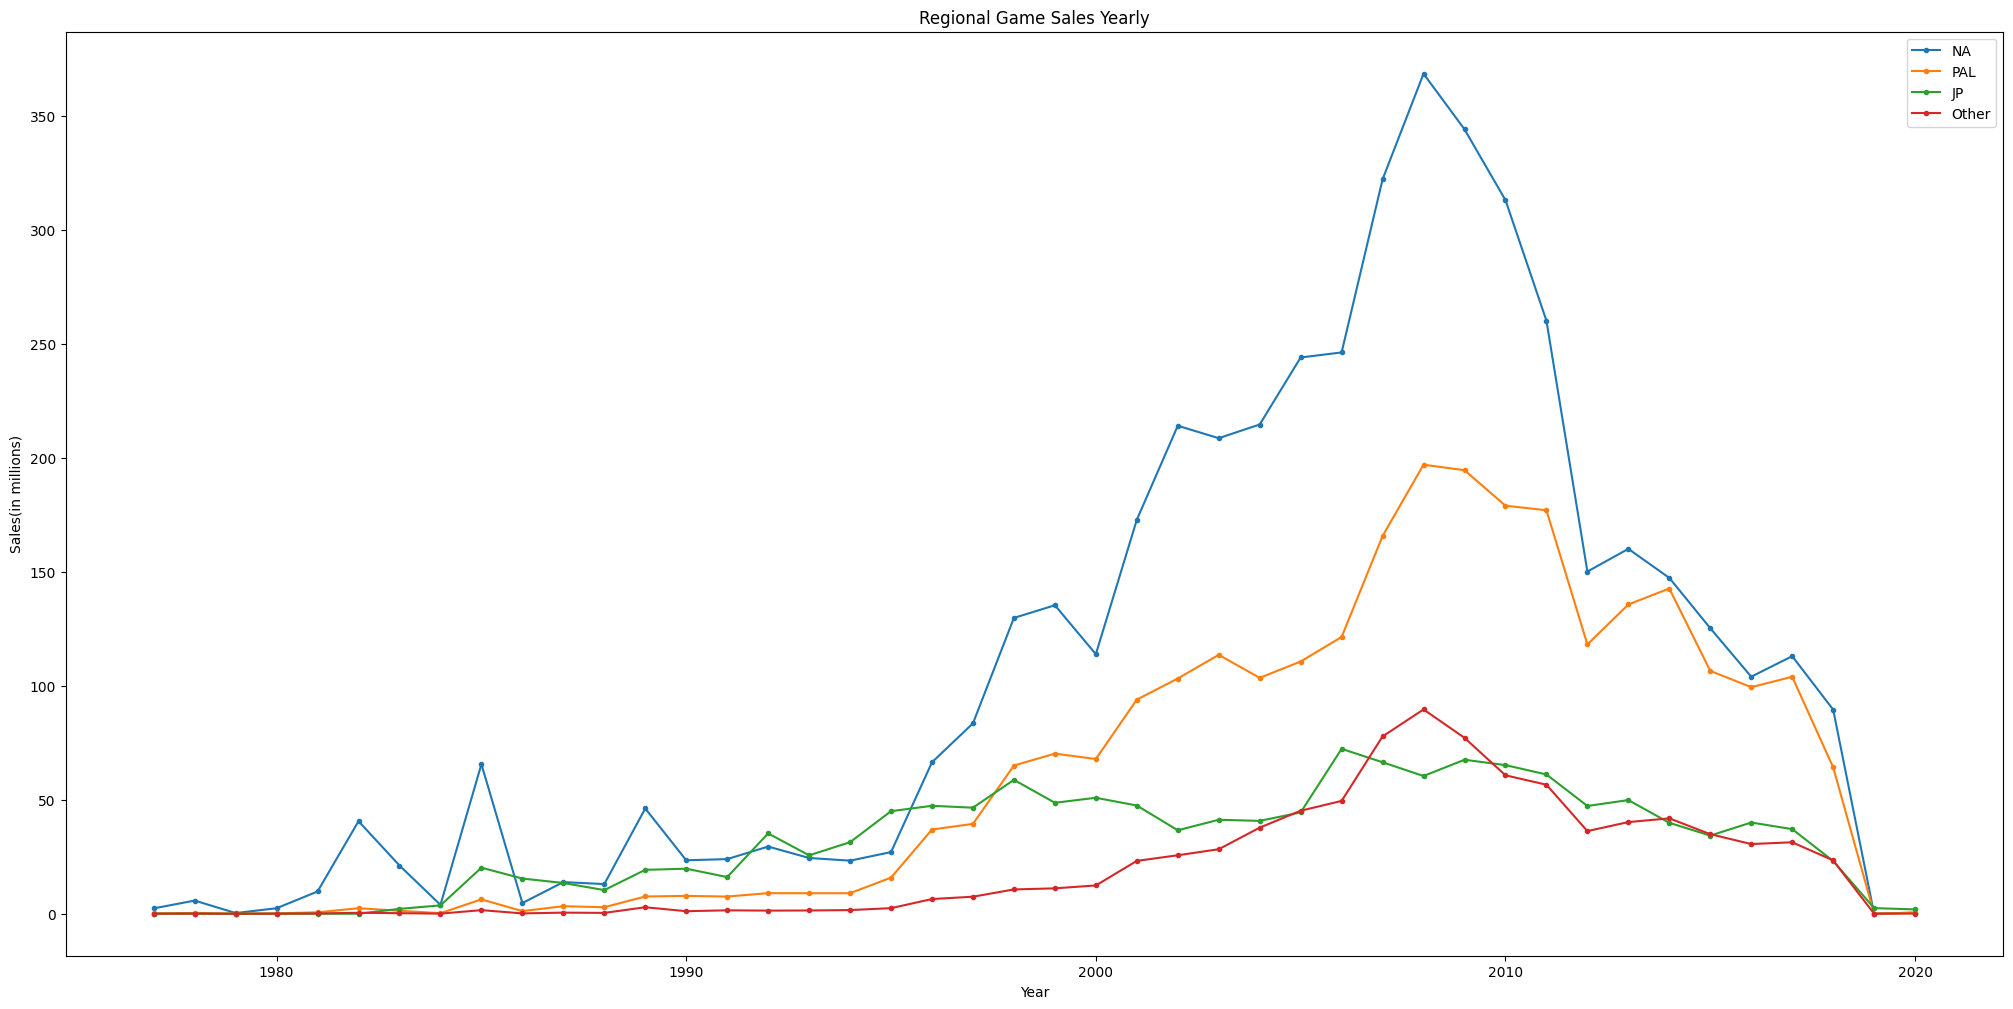

In [68]:
#yearly sales per region
NA_yearly_sales = df.groupby(['Release_date'],as_index=False,sort=True)['Sales_NA'].sum().sort_values('Release_date')
PAL_yearly_sales = df.groupby(['Release_date'],as_index=False,sort=True)['Sales_PAL'].sum().sort_values('Release_date')
JP_yearly_sales = df.groupby(['Release_date'],as_index=False,sort=True)['Sales_JP'].sum().sort_values('Release_date')
Ot_yearly_sales = df.groupby(['Release_date'],as_index=False,sort=True)['Sales_Other'].sum().sort_values('Release_date')

plt.figure(figsize=(25,12))

plt.title('Regional Game Sales Yearly')
plt.plot(NA_yearly_sales['Release_date'],NA_yearly_sales['Sales_NA'], label = 'NA', marker='.')
plt.plot(PAL_yearly_sales['Release_date'],PAL_yearly_sales['Sales_PAL'], label = 'PAL', marker='.')
plt.plot(JP_yearly_sales['Release_date'],JP_yearly_sales['Sales_JP'], label = 'JP', marker='.')
plt.plot(Ot_yearly_sales['Release_date'],Ot_yearly_sales['Sales_Other'], label = 'Other', marker='.')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

In [69]:
#Best selling game per region

best_NA_id = df['Sales_NA'].idxmax()
max_sales_NA = df.loc[best_NA_id][['Sales_NA','Name','Genre']]
best_EU_id = df['Sales_PAL'].idxmax()
max_sales_EU = df.loc[best_EU_id][['Sales_PAL','Name','Genre']]
best_JP_id = df['Sales_JP'].idxmax()
max_sales_JP = df.loc[best_JP_id][['Sales_JP','Name','Genre']]
best_Other_id = df['Sales_Other'].idxmax()
max_sales_other = df.loc[best_Other_id][['Sales_Other','Name','Genre']]

#set up data
max_regions = ['North America','PAL','Japan','Other']
max_names = [max_sales_NA[1],max_sales_EU[1],max_sales_JP[1],max_sales_other[1]]
max_genre = [max_sales_NA[2],max_sales_EU[2],max_sales_JP[2],max_sales_other[2]]
max_sales = [max_sales_NA[0],max_sales_EU[0],max_sales_JP[0],max_sales_other[0]]

#set up dataframe
most_sales_per_region = pd.DataFrame(data = {
    'Region' : max_regions,
    'Name' : max_names,
    'Genre' : max_genre,
    'Sales(millions)' : max_sales
})

most_sales_per_region

C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\4258143333.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_names = [max_sales_NA[1],max_sales_EU[1],max_sales_JP[1],max_sales_other[1]]
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\4258143333.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_genre = [max_sales_NA[2],max_sales_EU[2],max_sales_JP[2],max_sales_other[2]]
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\4258143333.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

Region                                Name         Genre  \
0  North America                          Wii Sports        Sports   
1            PAL                          Wii Sports        Sports   
2          Japan  Pokémon Red / Green / Blue Version  Role-Playing   
3          Other       Grand Theft Auto: San Andreas        Action   

   Sales(millions)  
0            41.36  
1            29.02  
2            10.22  
3            10.57

# Focus on the last 5 years of most complete data to more closley analyze modern trends and repeat anaylsis

In [70]:
#repeat most of my analysis above for data from the last 5 years
#pull data from last 5 years 
df_newer = df[df['Release_date'] > 2012]
df_5_years = df_newer[df_newer['Release_date'] < 2018]

In [71]:
#shape
print("Data Shape :",df_5_years.shape)

Data Shape : (3246, 12)


In [72]:
df_5_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3246 entries, 18 to 18991
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          3246 non-null   int64  
 1   Name          3246 non-null   object 
 2   Publisher     3246 non-null   object 
 3   Developer     3246 non-null   object 
 4   Platform      3246 non-null   object 
 5   Release_date  3246 non-null   float64
 6   Genre         3246 non-null   object 
 7   Sales_NA      1905 non-null   float64
 8   Sales_PAL     1970 non-null   float64
 9   Sales_JP      1728 non-null   float64
 10  Sales_Other   2347 non-null   float64
 11  Sales_Globe   3246 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 329.7+ KB


In [73]:
df_5_years.nunique()

Rank            3246
Name            1943
Publisher        247
Developer        618
Platform          14
Release_date       5
Genre             19
Sales_NA         208
Sales_PAL        191
Sales_JP          95
Sales_Other       96
Sales_Globe      333
dtype: int64

In [74]:
#check null values
print("data :\n")
print(df_5_years.isnull().sum())
print('Total null values : ',df_5_years.isnull().sum().sum())

data :

Rank               0
Name               0
Publisher          0
Developer          0
Platform           0
Release_date       0
Genre              0
Sales_NA        1341
Sales_PAL       1276
Sales_JP        1518
Sales_Other      899
Sales_Globe        0
dtype: int64
Total null values :  5034


In [75]:
# Look at columns with only null values
df_nan_5y = pd.DataFrame({'Count': df_5_years.isna().sum()[df_5_years.isna().sum() != 0]})

df_nan_5y['% of total'] = round((df_nan_5y['Count'] * 100)/df_5_years.shape[0], 2)
print(df_nan_5y.sort_values('Count', ascending = False))
print('\n')
print('of the %d columns in the training data, %d columns contain null values' %(df_5_years.shape[1], len(df_nan_5y)))

             Count  % of total
Sales_JP      1518       46.77
Sales_NA      1341       41.31
Sales_PAL     1276       39.31
Sales_Other    899       27.70


of the 12 columns in the training data, 4 columns contain null values


In [76]:
round(df_5_years.describe(), 2)

Rank  Release_date  Sales_NA  Sales_PAL  Sales_JP  Sales_Other  \
count   3246.00       3246.00   1905.00    1970.00   1728.00      2347.00   
mean   10491.66       2015.11      0.34       0.30      0.12         0.08   
std     5801.13          1.41      0.70       0.71      0.33         0.19   
min       19.00       2013.00      0.00       0.00      0.00         0.00   
25%     5324.25       2014.00      0.05       0.03      0.02         0.01   
50%    11386.00       2015.00      0.11       0.08      0.04         0.02   
75%    15691.00       2016.00      0.32       0.27      0.10         0.06   
max    18992.00       2017.00      9.06       9.85      4.90         3.12   

       Sales_Globe  
count      3246.00  
mean          0.50  
std           1.34  
min           0.00  
25%           0.03  
50%           0.10  
75%           0.38  
max          20.32

#### EDA Last 5 years of data

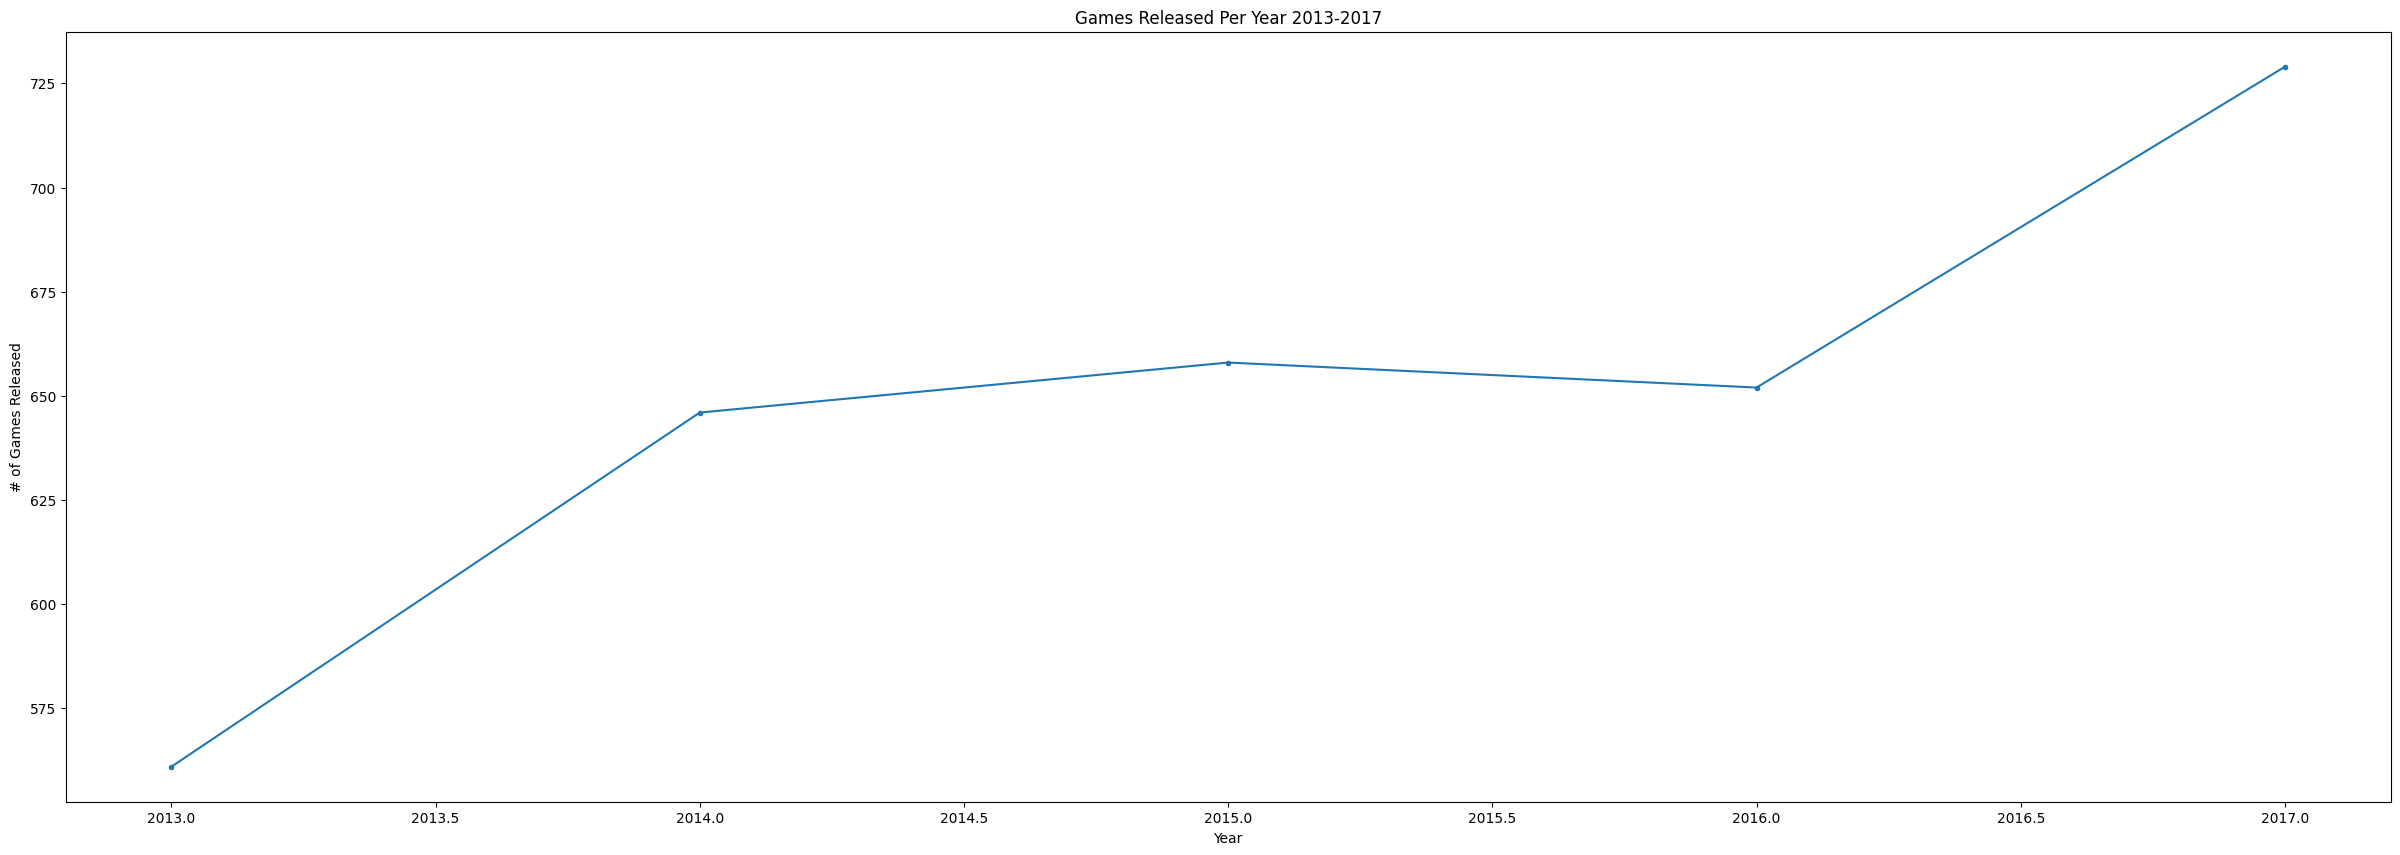

In [77]:
yearly_total_release_5y = df_5_years.groupby(['Release_date'],as_index=False)['Sales_Globe'].count()

plt.figure(figsize = (30,10))
plt.plot(yearly_total_release_5y['Release_date'],yearly_total_release_5y['Sales_Globe'],marker='.')
plt.title('Games Released Per Year 2013-2017')
plt.ylabel('# of Games Released')
plt.xlabel('Year')
plt.show()

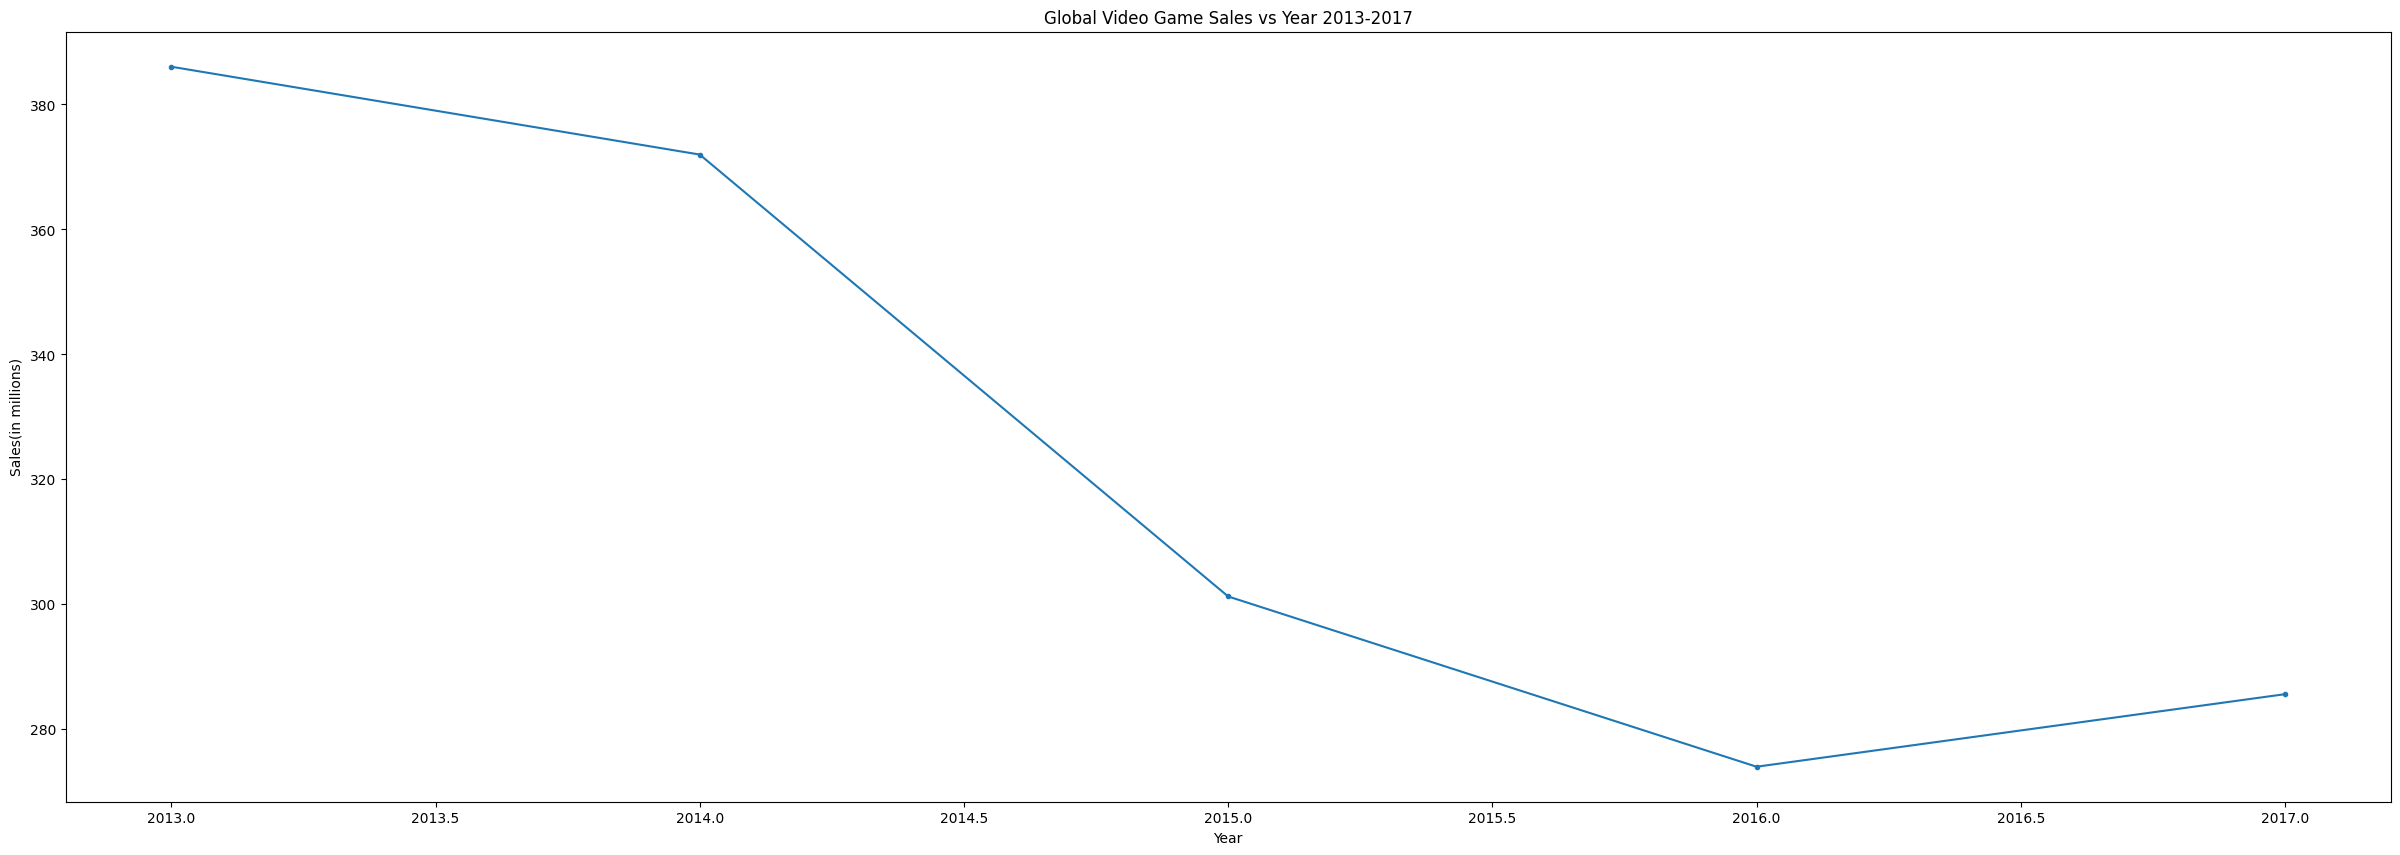

In [78]:
yearly_total_sales_5y = df_5_years.groupby(['Release_date'],as_index=False)['Sales_Globe'].sum()

plt.figure(figsize = (30,10))
plt.plot(yearly_total_sales_5y['Release_date'],yearly_total_sales_5y['Sales_Globe'],marker='.')
plt.title('Global Video Game Sales vs Year 2013-2017')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.show()

Though the amount of games being released increases over these 5 years, total sales have decreased over this 5 years window. Even with the large amount of games released in 2017 we only see a marginal imporvement in that years sales.

**Genre Data**

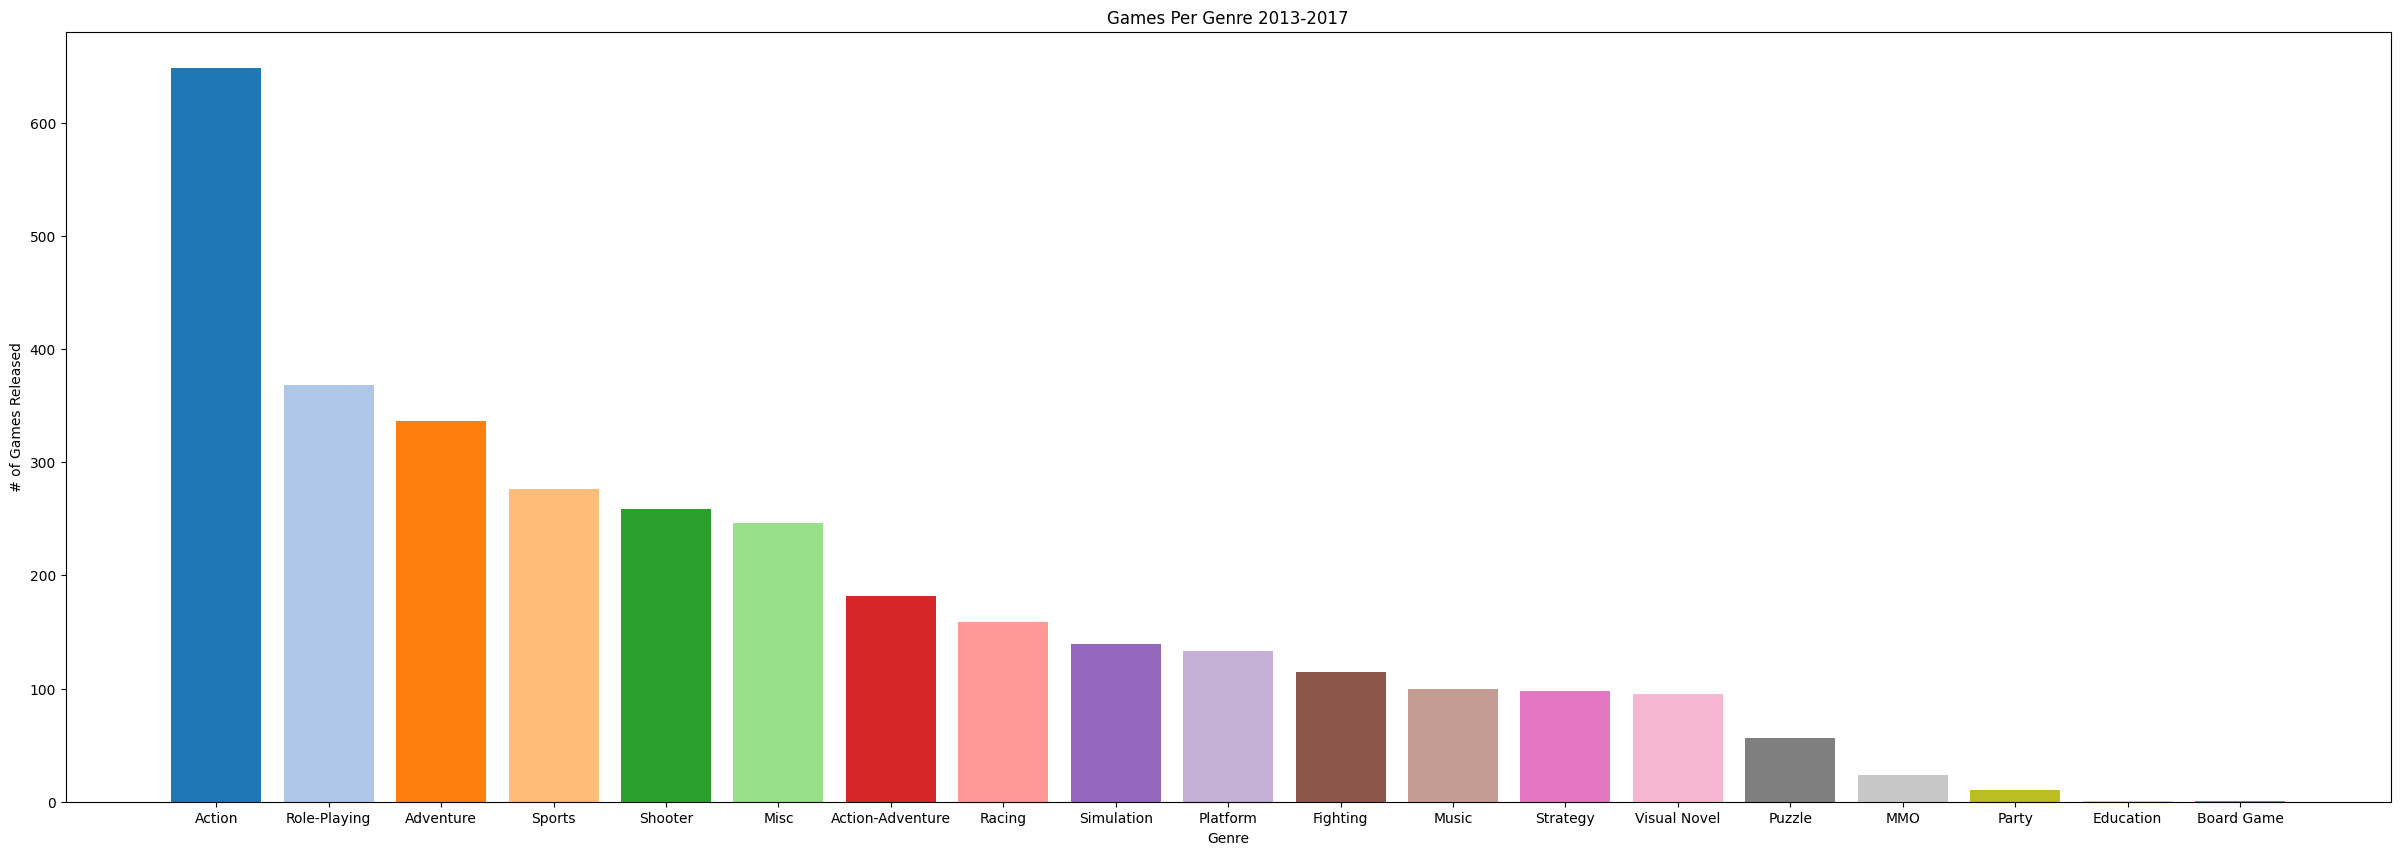

In [79]:
genre_total_releases_5y = df_5_years.groupby(['Genre'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df_5_years['Genre'].unique()))/(len(df_5_years['Genre'].unique())))

plt.figure(figsize = (30,10))
plt.bar(genre_total_releases_5y['Genre'],genre_total_releases_5y['Sales_Globe'],color=cs)
plt.title('Games Per Genre 2013-2017')
plt.xlabel('Genre')
plt.ylabel('# of Games Released')
plt.show()

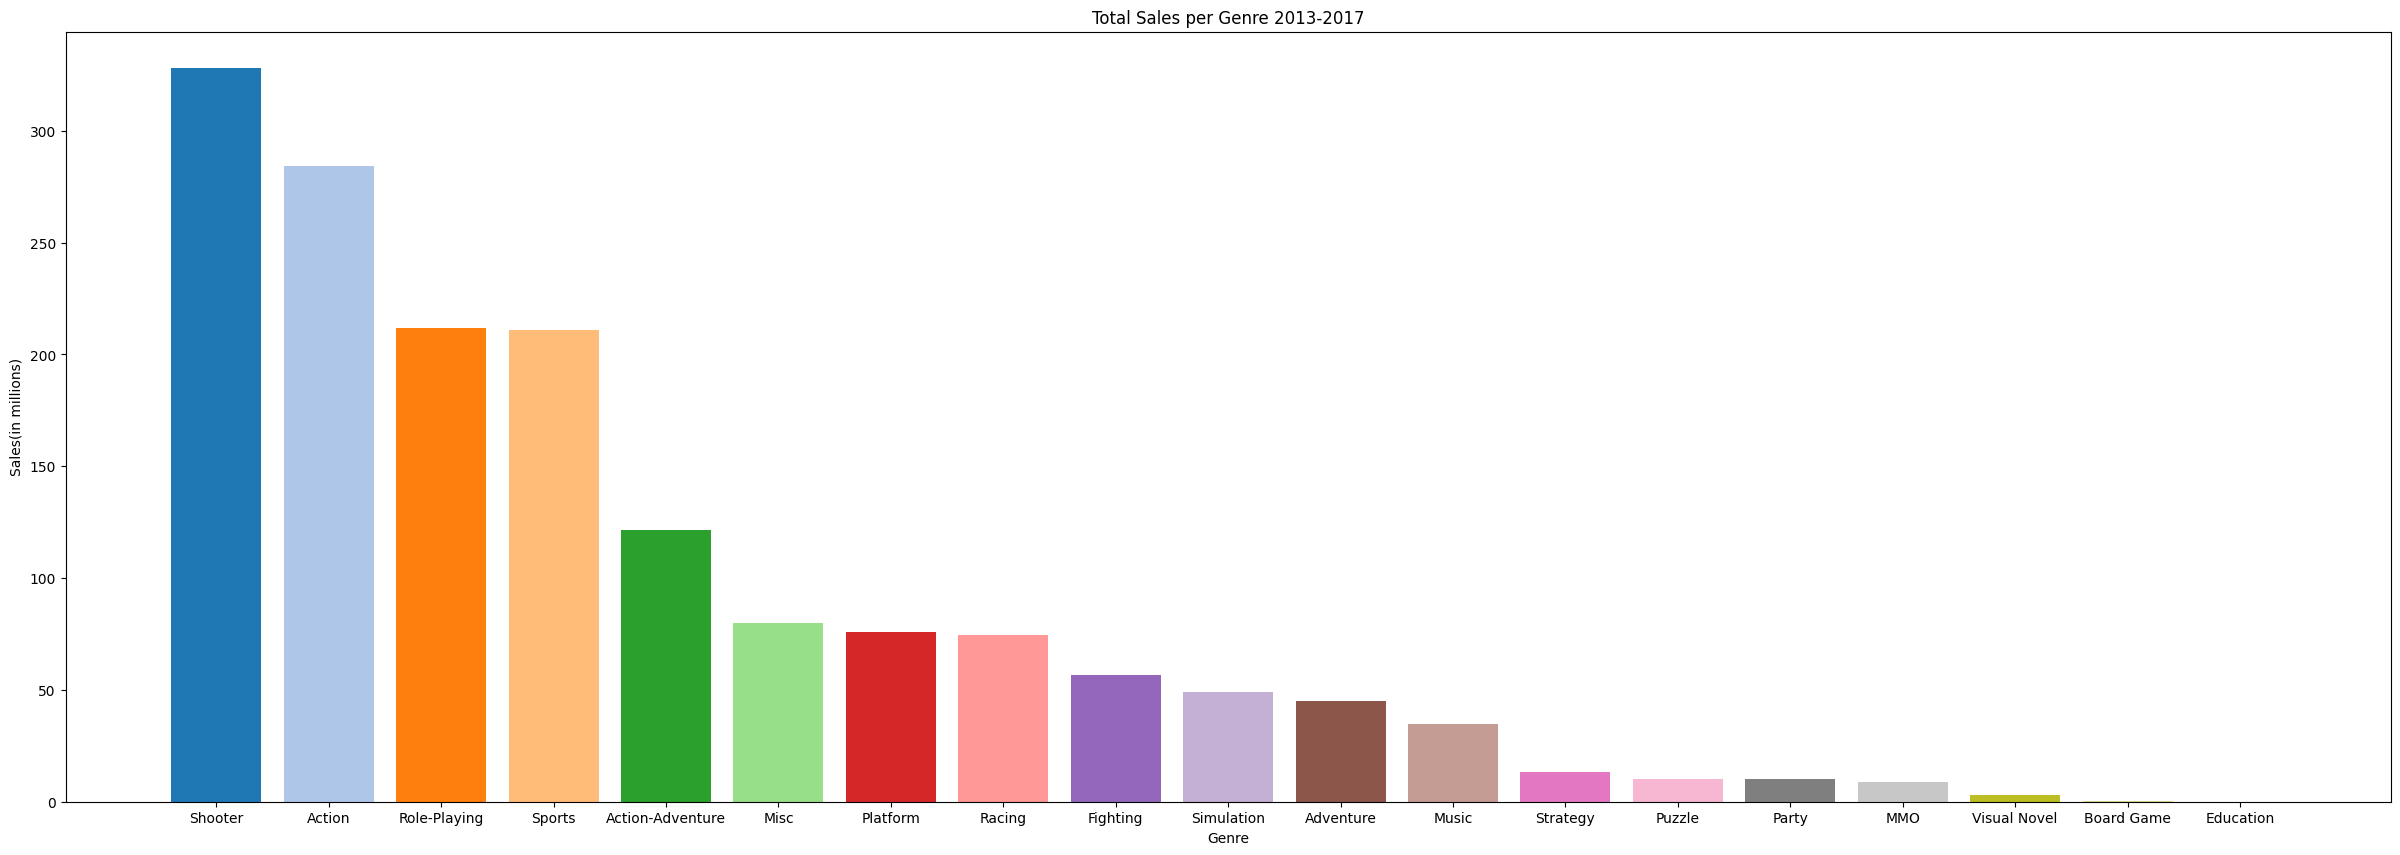

In [80]:
genre_total_sales_5y = df_5_years.groupby(['Genre'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df_5_years['Genre'].unique()))/(len(df_5_years['Genre'].unique())))

plt.figure(figsize =(30,10))
plt.bar(genre_total_sales_5y['Genre'],genre_total_sales_5y['Sales_Globe'],color=cs)
plt.title('Total Sales per Genre 2013-2017')
plt.xlabel('Genre')
plt.ylabel('Sales(in millions)')
plt.show()

The shooter, action and role-playing genre have surpased the sports genre in recent years but over all we still see that genres with faster-paced game play tend to perform best.

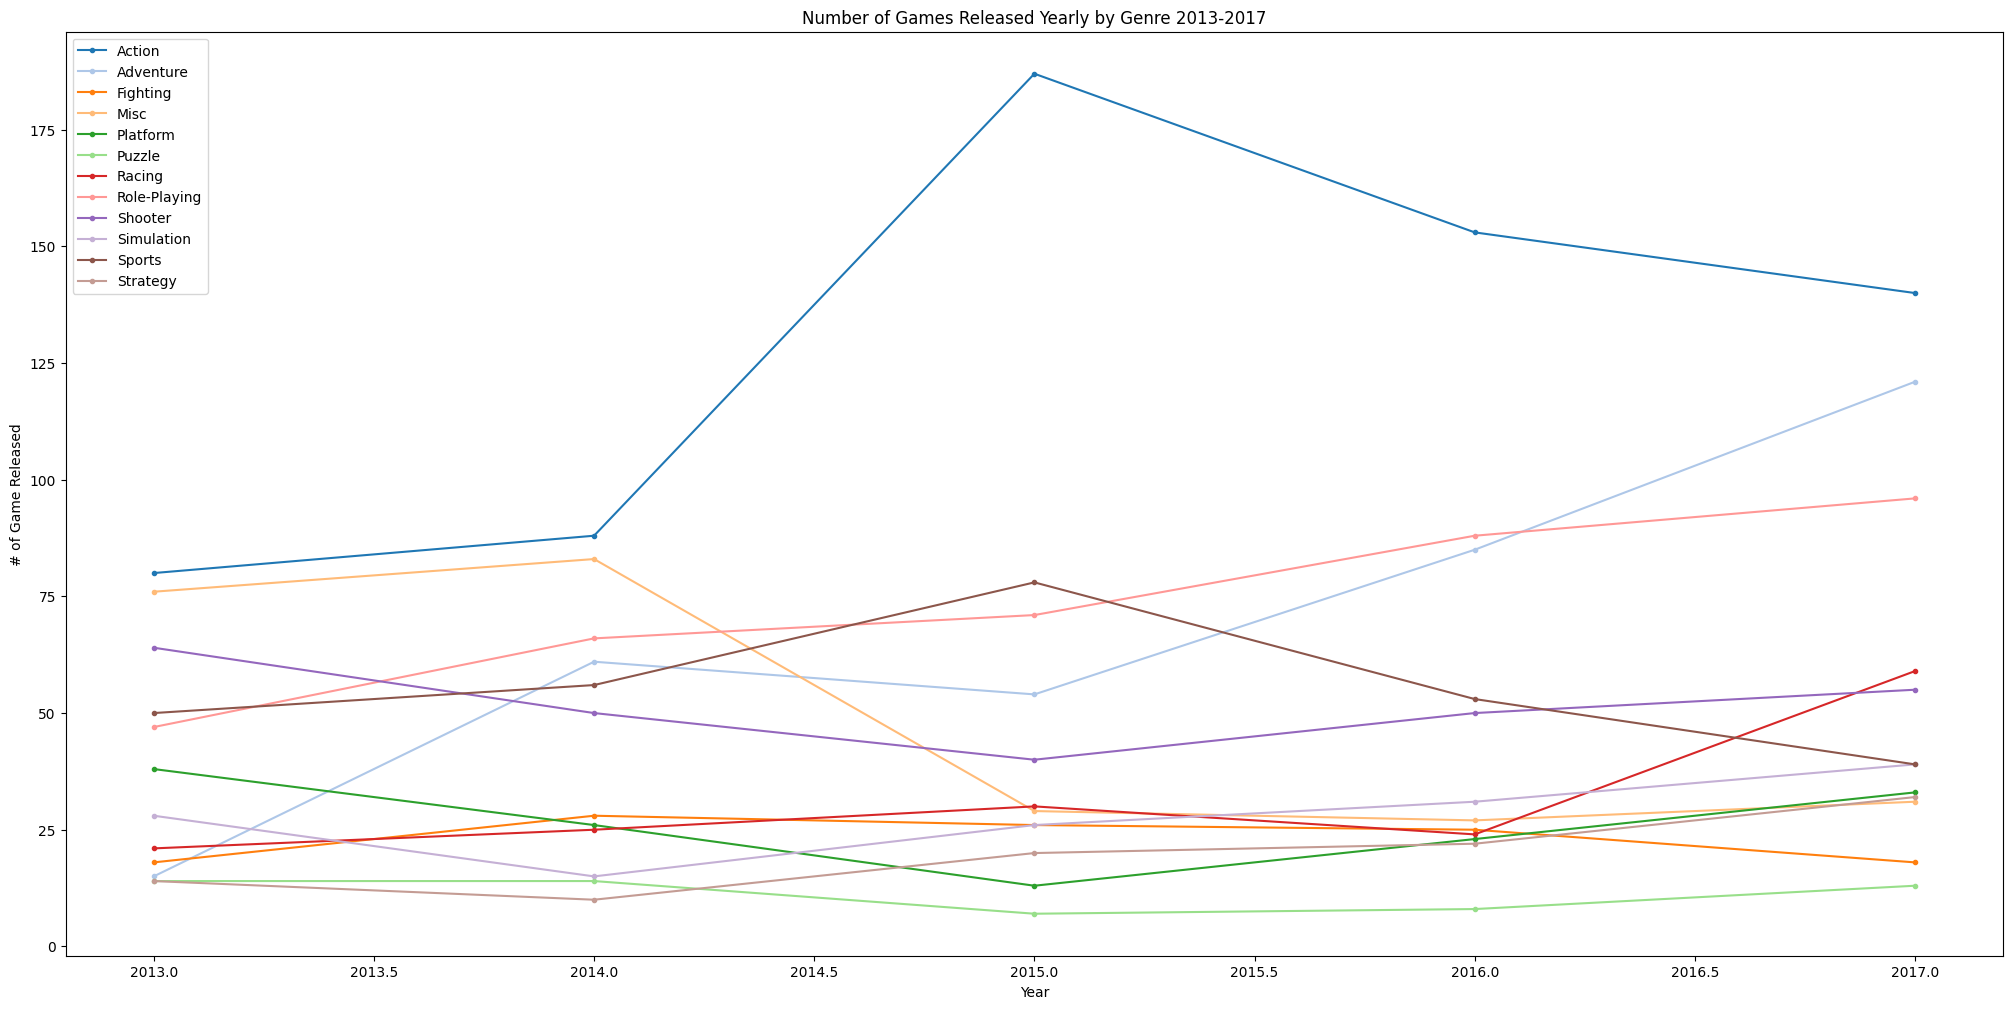

In [81]:
genre_list = ['Action','Adventure','Fighting','Misc','Platform','Puzzle','Racing','Role-Playing','Shooter','Simulation','Sports','Strategy']

genre_yearly_releases_5y = df_5_years.groupby(['Genre','Release_date'],as_index=False,sort=True)['Genre'].size()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for genre in genre_list:
    genre_release_5y = genre_yearly_releases_5y[genre_yearly_releases_5y['Genre'] == genre]
    plt.plot(genre_release_5y['Release_date'], genre_release_5y['size'], label = genre,marker='.',color = cmap(i))
    i = i+1


plt.title('Number of Games Released Yearly by Genre 2013-2017')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend()
plt.show()

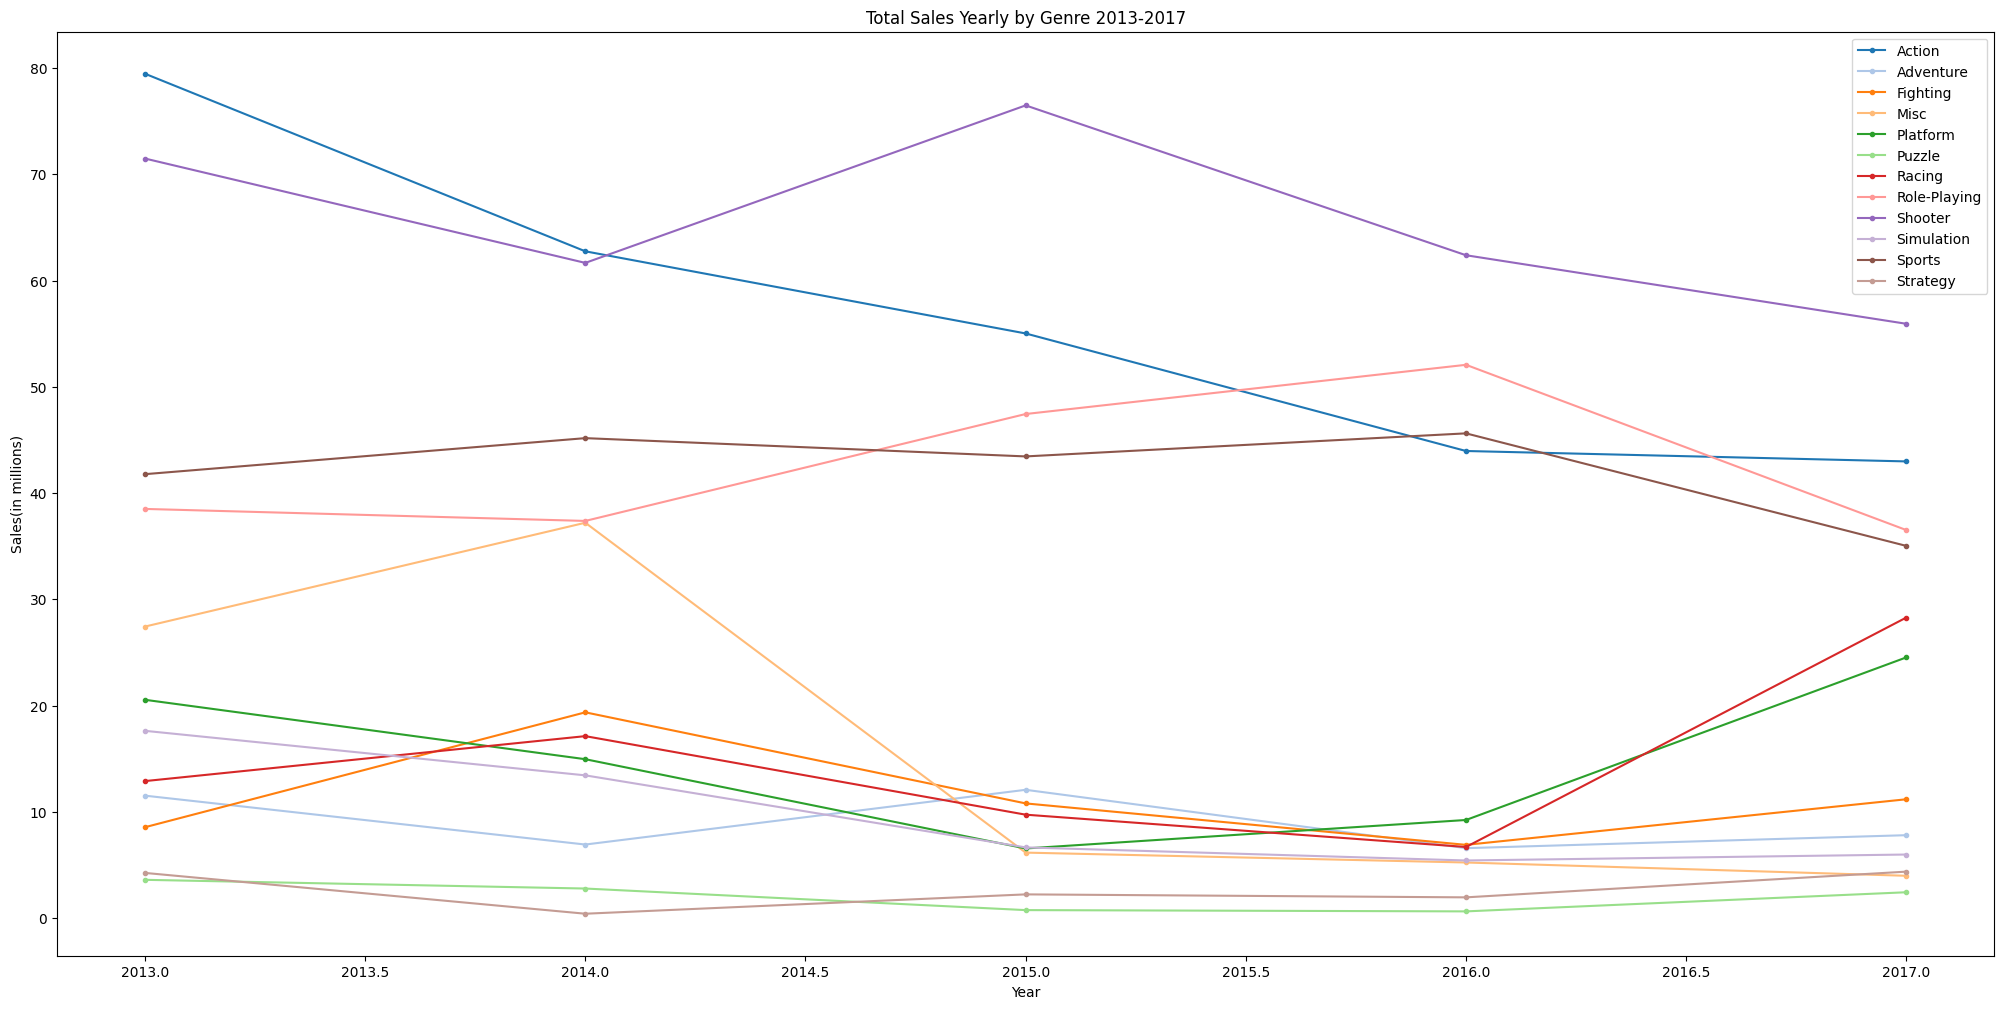

In [82]:
genre_yearly_sales_5y = df_5_years.groupby(['Genre','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for genre in genre_list:
    genre_sales_5y = genre_yearly_sales_5y[genre_yearly_sales_5y['Genre'] == genre]
    plt.plot(genre_sales_5y['Release_date'], genre_sales_5y['Sales_Globe'], label = genre,marker='.',color = cmap(i))
    i = i+1


plt.title('Total Sales Yearly by Genre 2013-2017')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

While almost every genre is falling in sales, the fighting, platform and racing genres are the only onces we see an overall increase in sales for. All other genres have very marginal overall changes or decrease overall.

In [83]:
#Best selling game per genre

idx_genre_5y = df_5_years.groupby(['Genre'])['Sales_Globe'].idxmax()
max_sales_genre_5y = df.loc[idx_genre_5y][['Genre','Name','Sales_Globe']]

max_sales_genre_5y

Genre                                         Name  \
18               Action                           Grand Theft Auto V   
78     Action-Adventure      The Legend of Zelda: Breath of the Wild   
193           Adventure                   Luigi's Mansion: Dark Moon   
6241         Board Game                 Monopoly for Nintendo Switch   
11792         Education            Brain Age: Concentration Training   
94             Fighting                    Super Smash Bros. for 3DS   
907                 MMO  The Elder Scrolls Online: Tamriel Unlimited   
75                 Misc                                    Minecraft   
351               Music                              Just Dance 2014   
694               Party                                   1-2-Switch   
53             Platform                          Super Mario Odyssey   
1347             Puzzle                             Puzzle & Dragons   
44               Racing                          Mario Kart 8 Deluxe   
25         Role-Playing                                  Pokémon X/Y   
32              Shooter                    Call of Duty: Black Ops 3   
62           Simulation                    Animal Crossing: New Leaf   
51               Sports                                      FIFA 18   
648            Strategy              Mario + Rabbids: Kingdom Battle   
9269       Visual Novel      Tears to Tiara II: Heir of the Overlord   

       Sales_Globe  
18           20.32  
78            9.46  
193           5.44  
6241          0.30  
11792         0.09  
94            8.32  
907           2.05  
75            9.82  
351           3.89  
694           2.46  
53           11.71  
1347          1.52  
44           13.05  
25           16.13  
32           15.09  
62           10.90  
51           11.80  
648           2.59  
9269          0.15

Many of the best selling games for each genre from 2013-2017 mirror the best selling games of those genres across all of the data. These titles are just the latest iterations from those series/franchises. This demonstrates the strength of having a long lasting franchise that has enduring popularity and commercial success. Even with the overall decrease in sales theses franchises remain as the most successful for many genres.

**Platform Data**

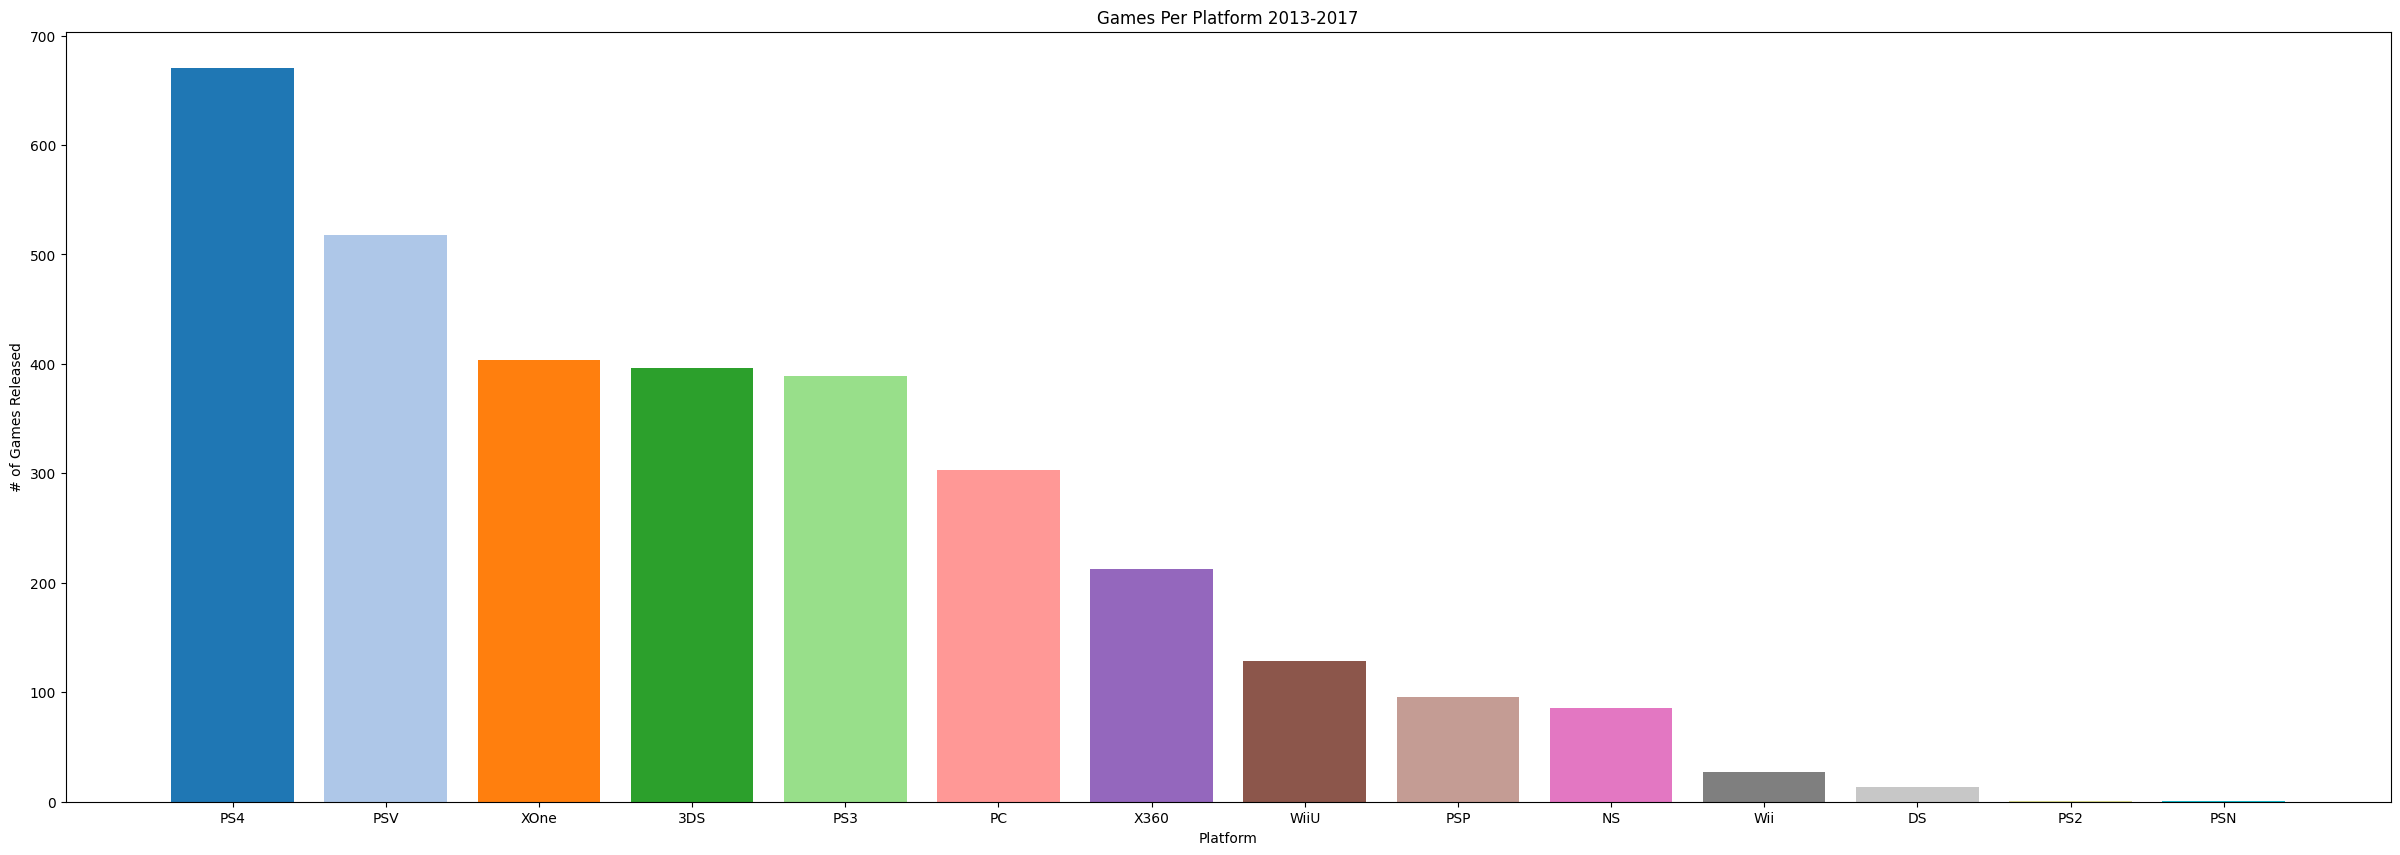

In [84]:
platform_total_releases_5y = df_5_years.groupby(['Platform'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df_5_years['Platform'].unique()))/(len(df_5_years['Platform'].unique()))) 

plt.figure(figsize = (30,10))
plt.bar(platform_total_releases_5y['Platform'],platform_total_releases_5y['Sales_Globe'],color=cs)
plt.title('Games Per Platform 2013-2017')
plt.ylabel('# of Games Released')
plt.xlabel('Platform')
plt.show()

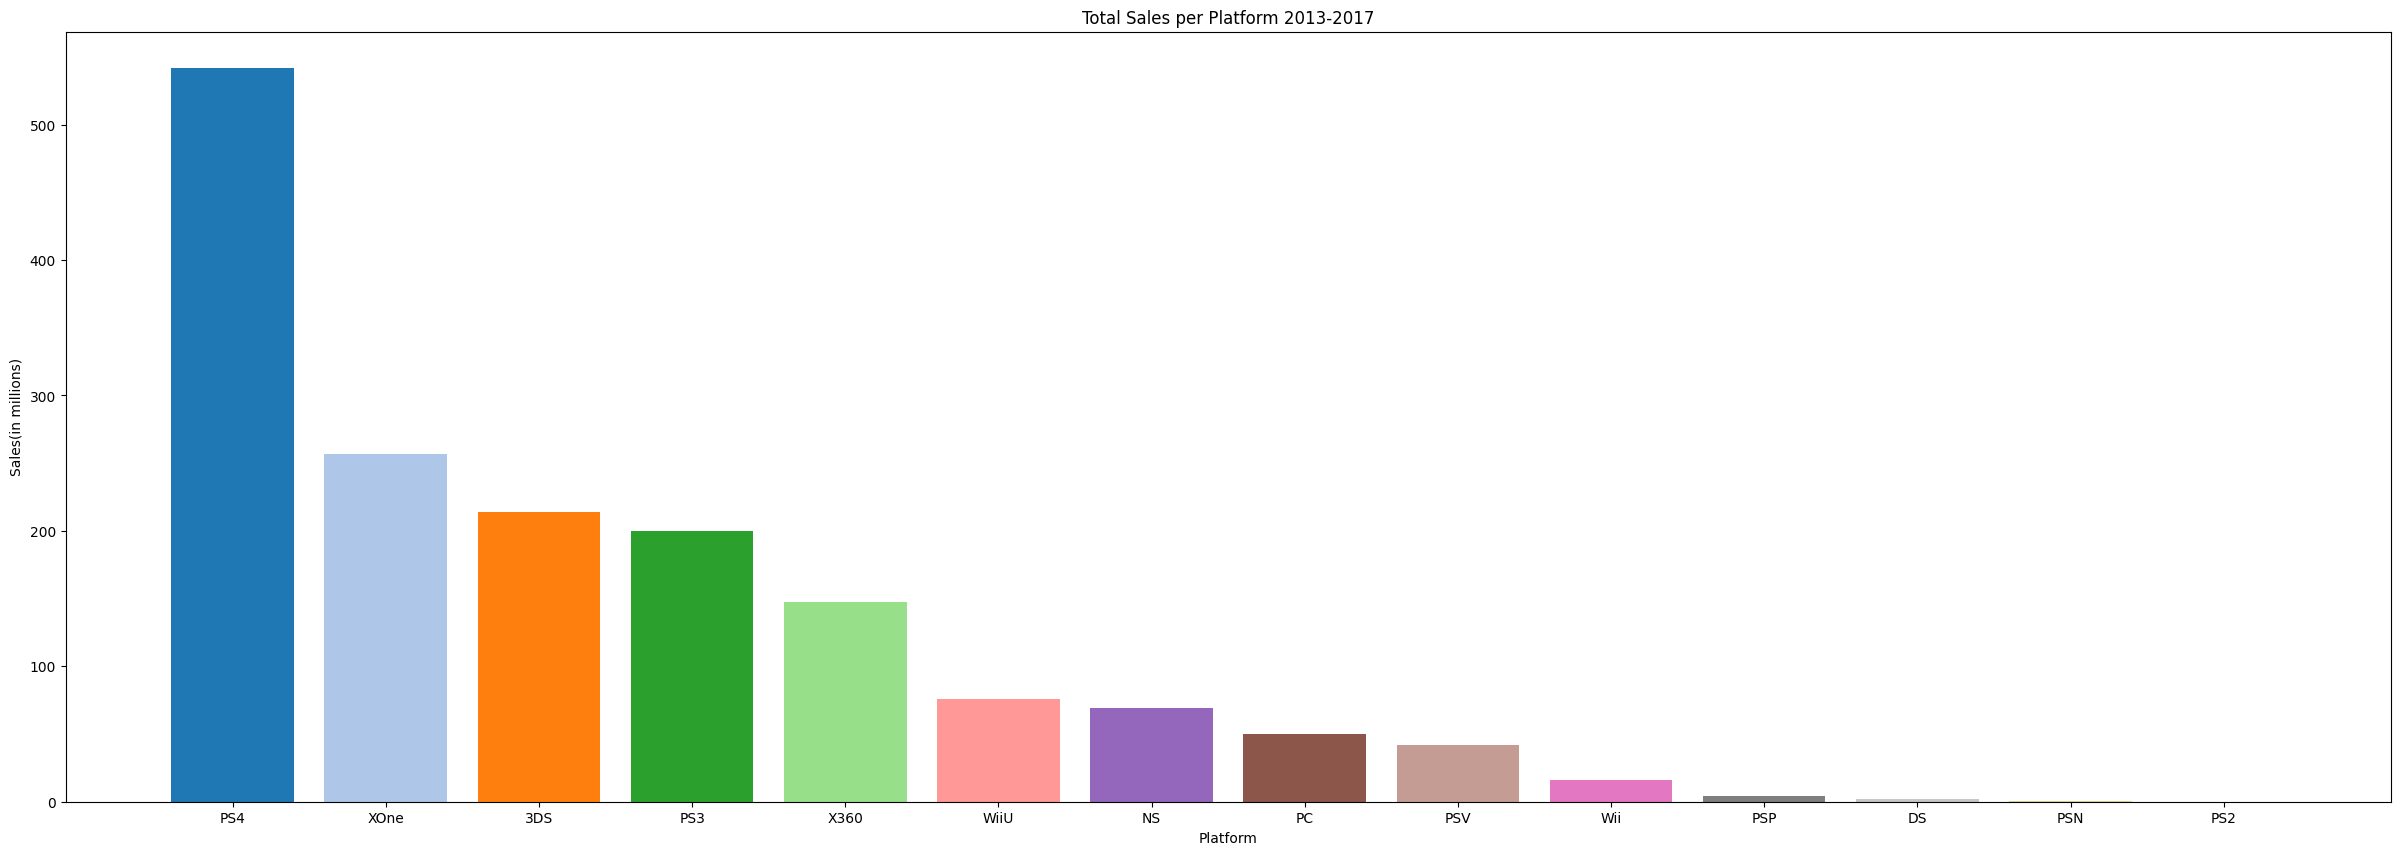

In [85]:
platform_total_sales_5y = df_5_years.groupby(['Platform'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

cs = plt.cm.tab20(np.arange(len(df_5_years['Platform'].unique()))/(len(df_5_years['Platform'].unique())))

plt.figure(figsize =(30,10))
plt.bar(platform_total_sales_5y['Platform'],platform_total_sales_5y['Sales_Globe'],color=cs)
plt.title('Total Sales per Platform 2013-2017')
plt.xlabel('Platform')
plt.ylabel('Sales(in millions)')
plt.show()

The PSV severly under perform in sales considering it is ranked 2nd in catalog size but is ranked 9th in sales. Some of this can be explained by the PSV's lower average game price but such a large drop indicates that games on the PSV do not perfrom well. We also see that PC games seems to be under perfroming in sales. Most other platforms rank similarly between catalog size and sales, with PS4 beings the most succcessful. 

We have virtually no sales for the PSP, PSN, PS2 and DS for this time range so we will drop them from further analysis.

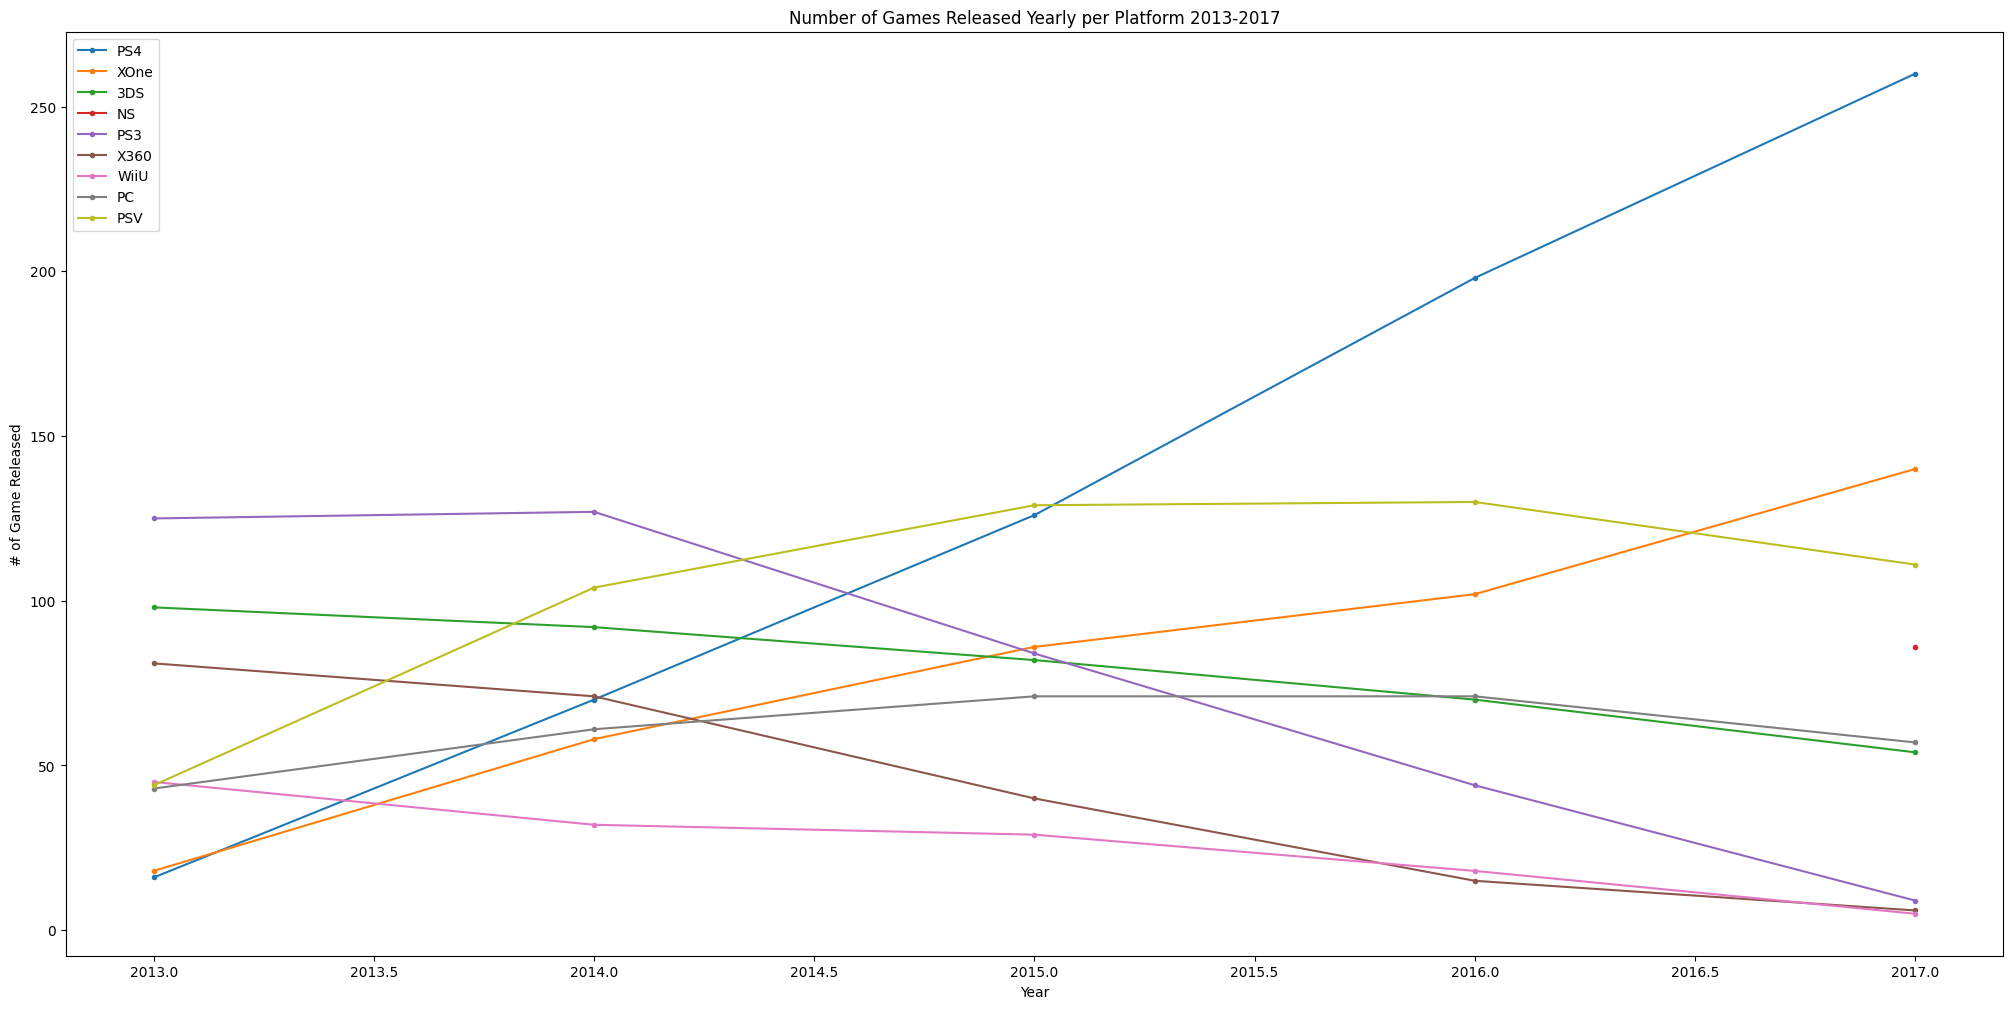

In [86]:
#look at console information
console_list_5y = ['PS4','XOne','3DS','NS','PS3','X360','WiiU','PC','PSV']

console_yearly_releases_5y = df_5_years.groupby(['Platform','Release_date'],as_index=False,sort=True)['Platform'].size()

plt.figure(figsize=(25,12))

for console in console_list_5y:
    console_release_5y = console_yearly_releases_5y[console_yearly_releases_5y['Platform'] == console]
    plt.plot(console_release_5y['Release_date'], console_release_5y['size'], label = console,marker='.')

plt.title('Number of Games Released Yearly per Platform 2013-2017')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend()
plt.show()

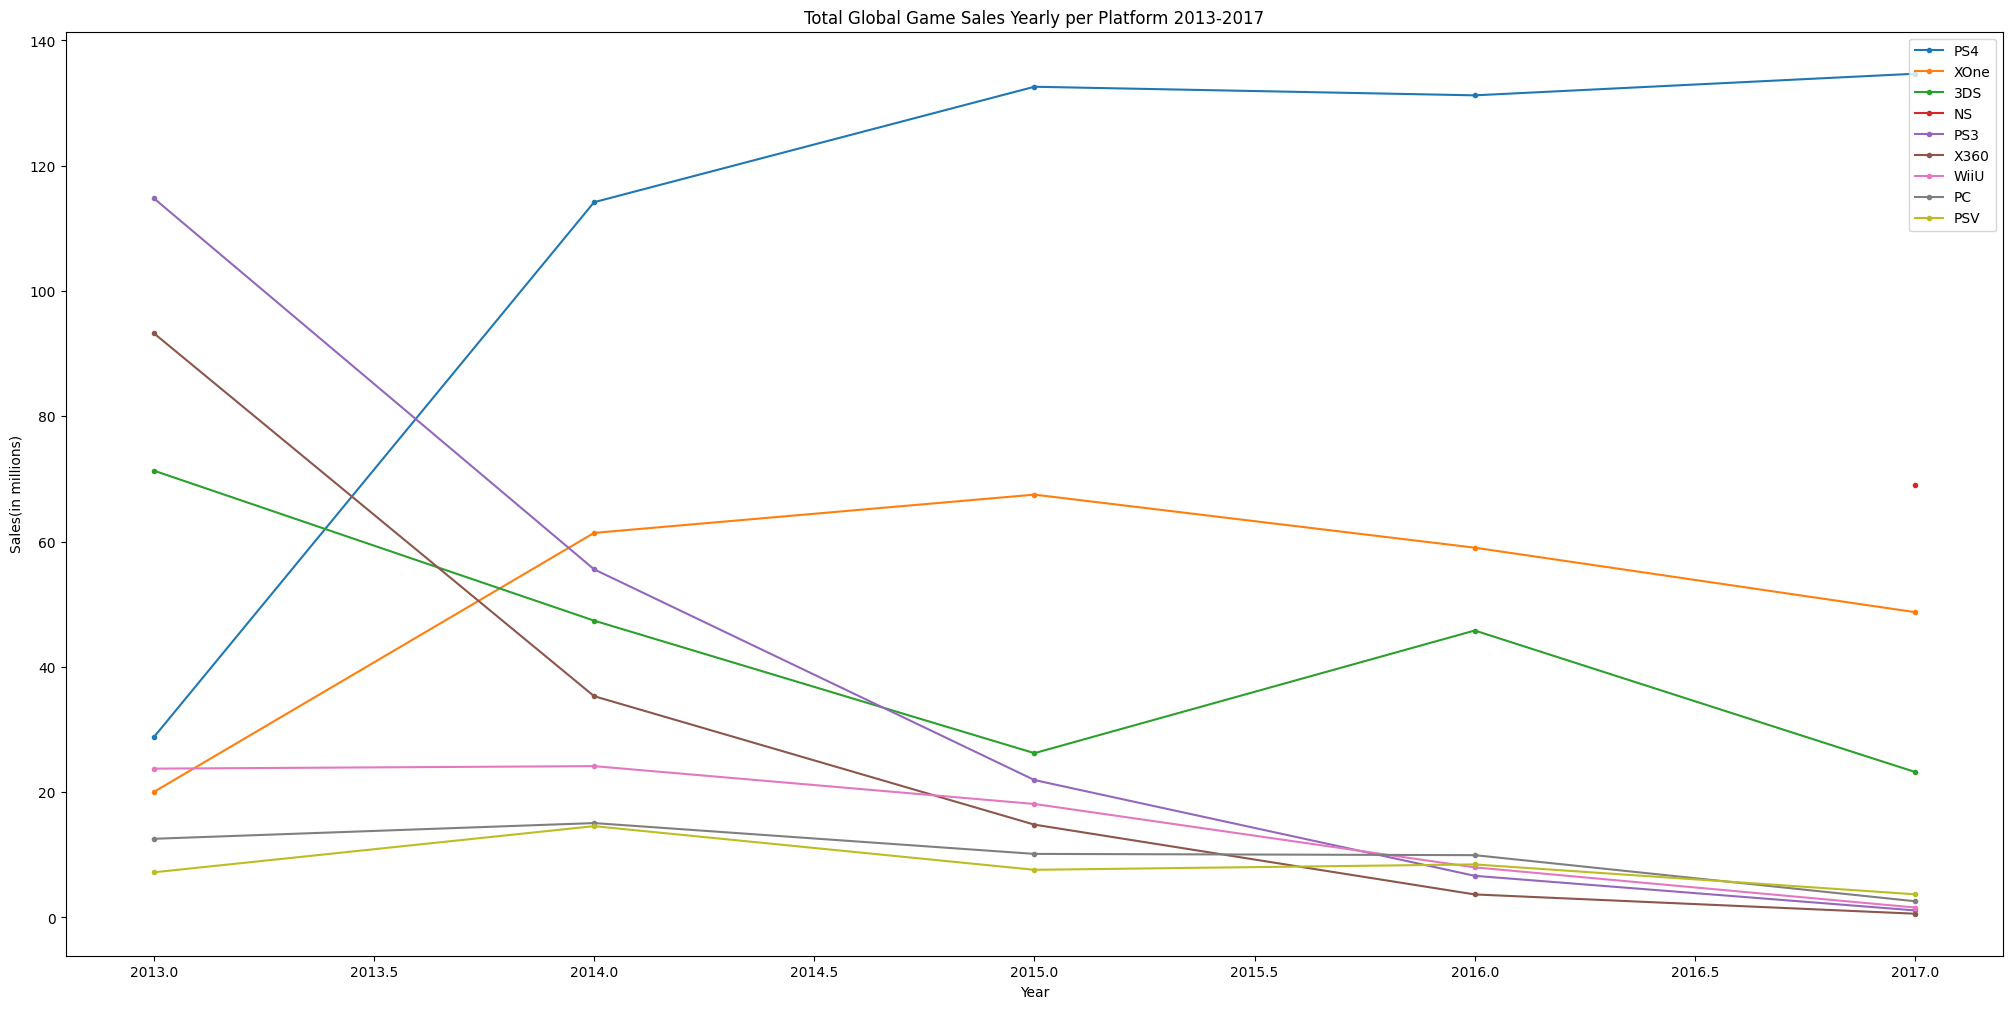

In [87]:
console_yearly_sales_5y = df_5_years.groupby(['Platform','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

plt.figure(figsize=(25,12))

for console in console_list_5y:
    console_sales_5y = console_yearly_sales_5y[console_yearly_sales_5y['Platform'] == console]
    plt.plot(console_sales_5y['Release_date'], console_sales_5y['Sales_Globe'], label = console,marker='.')

plt.title('Total Global Game Sales Yearly per Platform 2013-2017')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

PS4 and XBox One both increase releases in a relatively linear fashion over the years but after 2015 sales for XBox One games starts decreasing and sales for PS4 games begins to plateau. Game sales for all other platforms decrease over this period of time. The XBox360, PS3, WiiU, PSV and 3DS were at the end of their life cycle, so this drop in prices is expected. We also see the emergence of a new platform, the Nintendo Switch. This platforms starts out strong with the 2nd highest overall games sales for 2017 but we only have one years worth of data to evaluate. Here we see what happens as one generation of platforms' time comes to an end and a new generation of platforms take over.

In [88]:
#Genre with most releases per Platform for Top 7 platforms
df_top_7_platforms_5y = df_5_years.loc[df_5_years['Platform'].isin(console_list_5y)]

game_release_per_console_per_genre_5y = df_top_7_platforms_5y.groupby(['Platform','Genre'])['Genre'].count().sort_values().groupby(level=0).tail(1)

game_release_per_console_per_genre_5y

Platform  Genre           
NS        Action               24
WiiU      Action-Adventure     26
X360      Sports               39
PC        Action               48
PS3       Action               75
3DS       Role-Playing         85
XOne      Action               87
PSV       Adventure           148
PS4       Action              154
Name: Genre, dtype: int64

In [89]:
#Genre with most sales per Platform
#Output for this is the total sales of games in that genre in millions
game_sales_per_console_per_genre_5y = df_top_7_platforms_5y.groupby(['Platform','Genre'])['Sales_Globe'].sum().sort_values().groupby(level=0).tail(1)

game_sales_per_console_per_genre_5y

Platform  Genre       
PSV       Role-Playing      9.66
PC        Simulation       12.10
NS        Platform         14.83
WiiU      Platform         14.96
X360      Shooter          39.57
PS3       Action           45.38
XOne      Shooter          92.21
3DS       Role-Playing    102.60
PS4       Shooter         134.72
Name: Sales_Globe, dtype: float64

In [90]:
#best selling games for each console

game_sales_per_console_id_5y = df_5_years.groupby(df_5_years['Platform'],as_index=False,sort=True)['Sales_Globe'].idxmax()

max_game_PS4_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'PS4']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_XOne_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'XOne']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_3DS_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == '3DS']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_NS_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'NS']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PS3_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'PS3']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_X360_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'X360']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_WiiU_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'WiiU']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PC_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'PC']['Sales_Globe']][['Name','Genre','Sales_Globe']])
max_game_PSV_5y = np.array(df_5_years.loc[game_sales_per_console_id_5y[game_sales_per_console_id_5y['Platform'] == 'PSV']['Sales_Globe']][['Name','Genre','Sales_Globe']])

max_games_name_5y = [max_game_PS4_5y[0][0],max_game_XOne_5y[0][0],max_game_3DS_5y[0][0],max_game_NS_5y[0][0],max_game_PS3_5y[0][0],max_game_X360_5y[0][0],max_game_WiiU_5y[0][0],max_game_PC_5y[0][0],max_game_PSV_5y[0][0]]
max_games_genre_5y = [max_game_PS4_5y[0][1],max_game_XOne_5y[0][1],max_game_3DS_5y[0][1],max_game_NS_5y[0][1],max_game_PS3_5y[0][1],max_game_X360_5y[0][1],max_game_WiiU_5y[0][1],max_game_PC_5y[0][1],max_game_PSV_5y[0][1]]
max_games_sales_5y = [max_game_PS4_5y[0][2],max_game_XOne_5y[0][2],max_game_3DS_5y[0][2],max_game_NS_5y[0][2],max_game_PS3_5y[0][2],max_game_X360_5y[0][2],max_game_WiiU_5y[0][2],max_game_PC_5y[0][2],max_game_PSV_5y[0][2]]

#set up dataframe
most_sales_per_console_5y = pd.DataFrame(data = {
    'Console' : console_list_5y,
    'Name' : max_games_name_5y,
    'Genre' : max_games_genre_5y,
    'Sales(million)' : max_games_sales_5y
})

most_sales_per_console_5y

Console                 Name         Genre  Sales(million)
0     PS4   Grand Theft Auto V        Action           19.39
1    XOne   Grand Theft Auto V        Action            8.72
2     3DS          Pokémon X/Y  Role-Playing           16.13
3      NS  Mario Kart 8 Deluxe        Racing           13.05
4     PS3   Grand Theft Auto V        Action           20.32
5    X360   Grand Theft Auto V        Action           15.86
6    WiiU         Mario Kart 8        Racing            7.69
7      PC           The Sims 4    Simulation            4.10
8     PSV            Minecraft          Misc            2.47

Further proof that fast-paced games are among the best peforming games per platform. We also once again see the strength of a popular franchise that continues to perform well. All of these games, except for Minecraft, comes from an already successful franchise.

**Publisher Data**

Once again we will focus on the top 10 publishers.

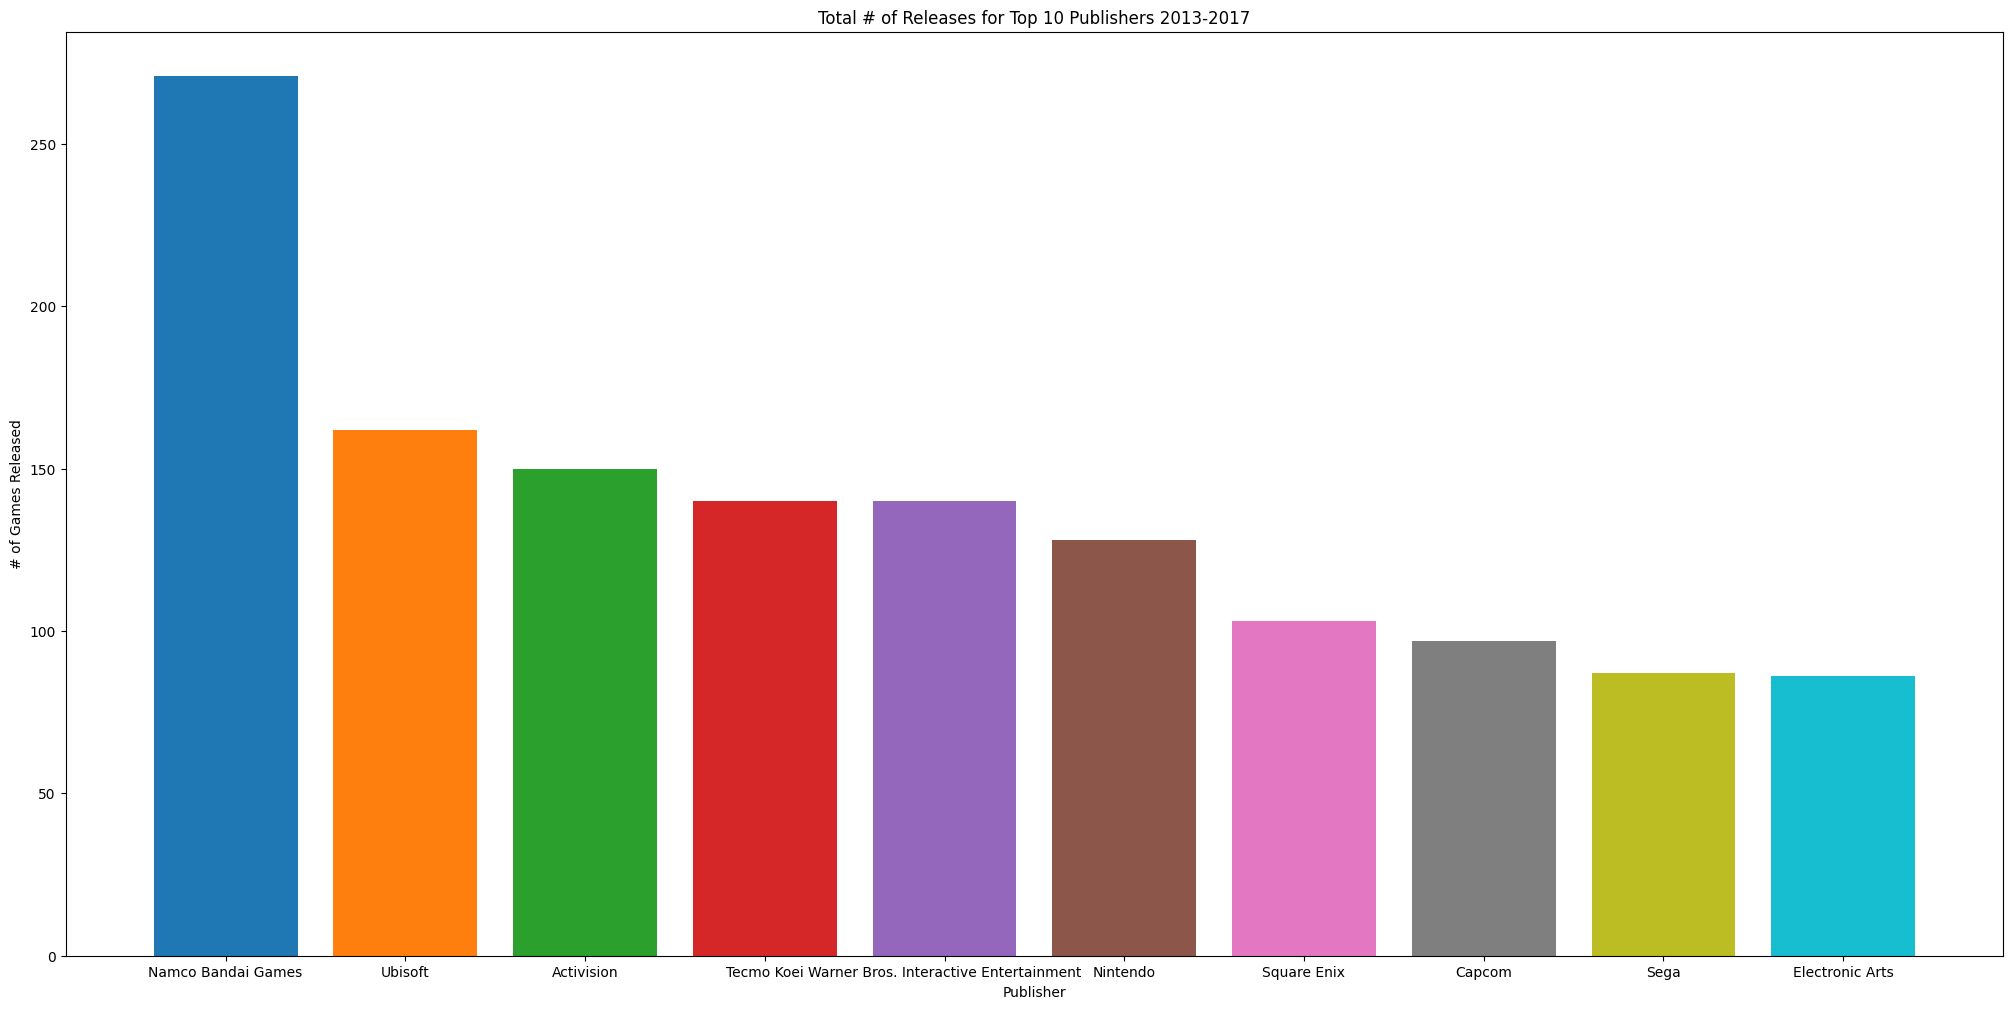

In [91]:
publisher_total_releases_5y = df_5_years.groupby(['Publisher'],as_index=False,sort=True)['Sales_Globe'].count().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 publishers
top_10_publishers_releases_5y = pd.DataFrame(publisher_total_releases_5y[:10])

#The rest of the publishers
other_publishers_releases_5y = pd.DataFrame(publisher_total_releases_5y[10:])

#Add all other publisher info together and put under name 'Other'
top_10_publishers_others_releases_5y = top_10_publishers_releases_5y.copy()
top_10_publishers_others_releases_5y.loc[len(top_10_publishers_others_releases_5y.index)] = ['Others',other_publishers_releases_5y['Sales_Globe'].sum()]

cs = plt.cm.tab20(np.arange(len(top_10_publishers_releases_5y['Publisher'].unique()))/(len(top_10_publishers_releases_5y['Publisher'].unique())))

plt.figure(figsize =(25,12))
plt.bar(top_10_publishers_releases_5y['Publisher'],top_10_publishers_releases_5y['Sales_Globe'],color=cs)
plt.title('Total # of Releases for Top 10 Publishers 2013-2017')
plt.xlabel('Publisher')
plt.ylabel('# of Games Released')
plt.show()


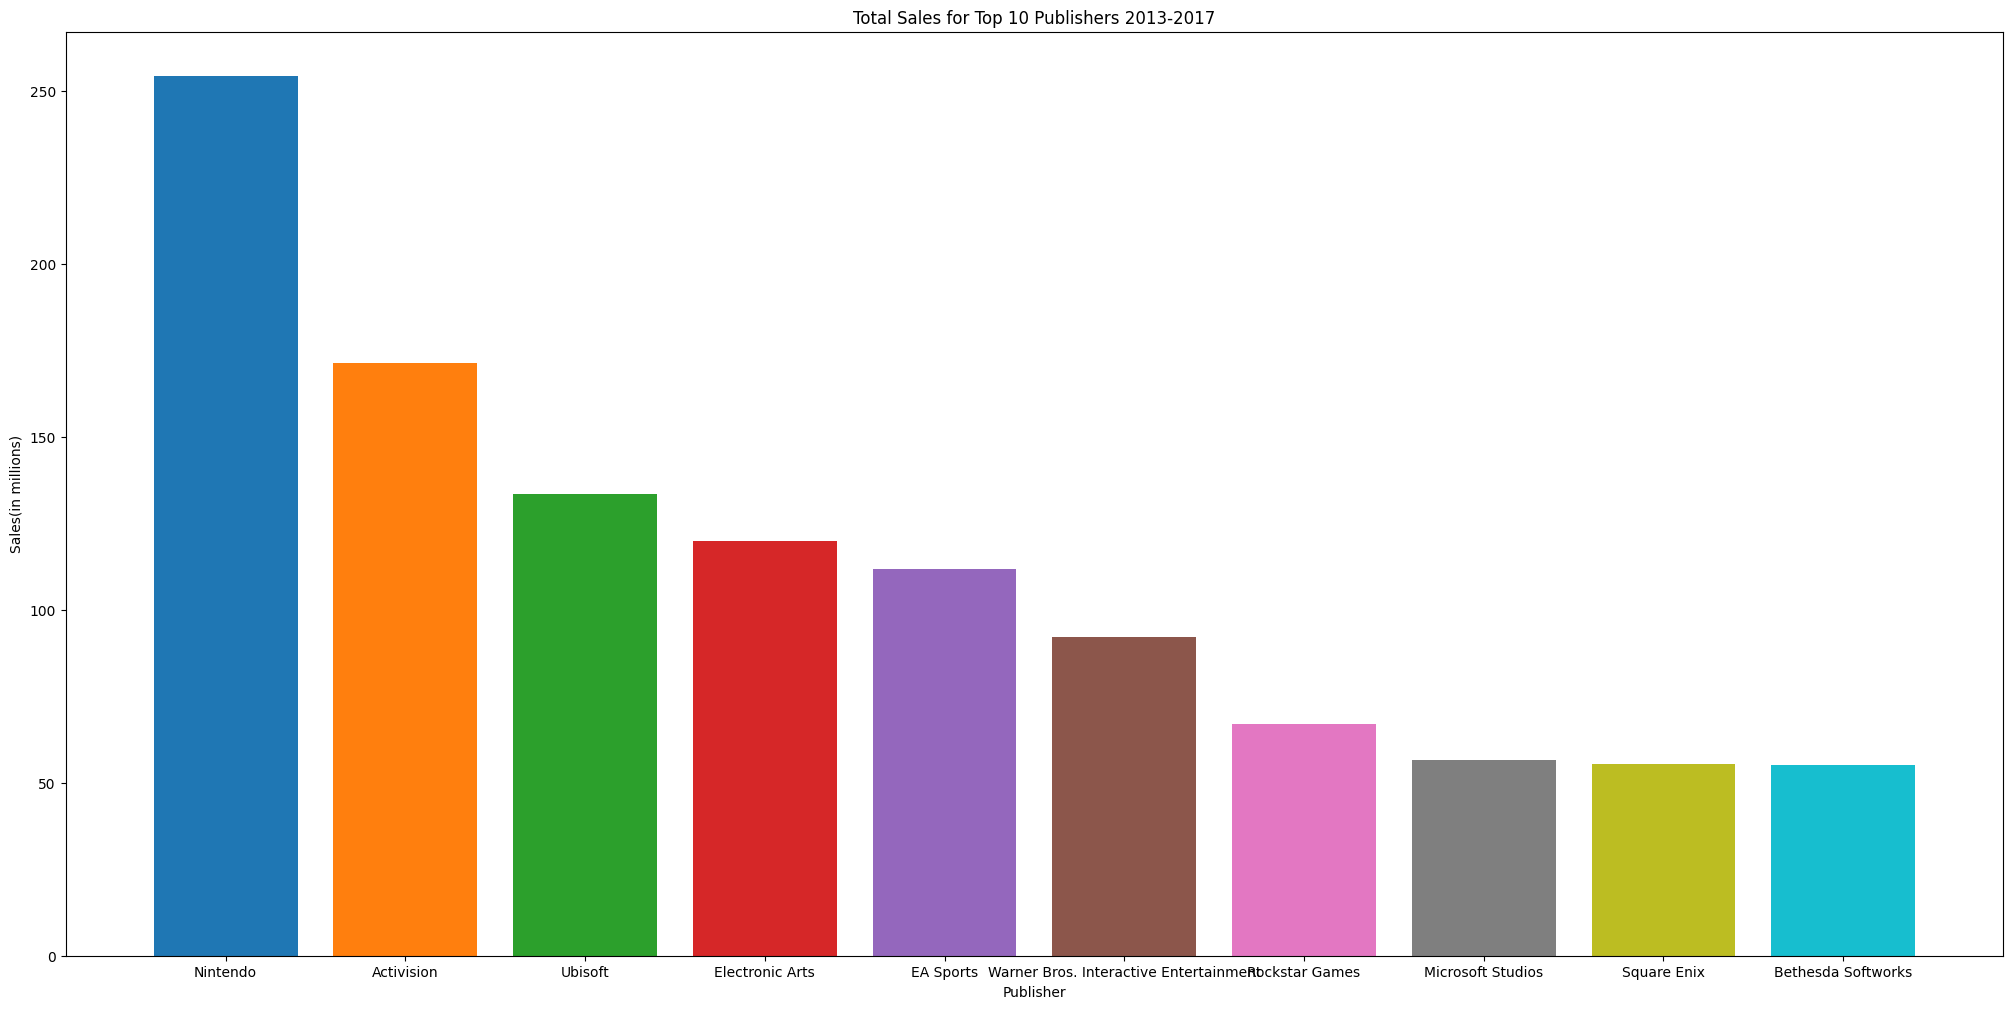

In [92]:
publisher_total_sales_5y = df_5_years.groupby(['Publisher'],as_index=False,sort=True)['Sales_Globe'].sum().sort_values('Sales_Globe',ascending=False)

#Isolate top 10 publishers
top_10_publishers_sales_5y = pd.DataFrame(publisher_total_sales_5y[:10])

#The rest of the publishers
other_publishers_sales_5y = pd.DataFrame(publisher_total_sales_5y[10:])

#Add all other publisher info together and put under name 'Other'
top_10_publishers_others_sales_5y = top_10_publishers_sales_5y.copy()
top_10_publishers_others_sales_5y.loc[len(top_10_publishers_others_sales_5y.index)] = ['Others',other_publishers_sales_5y['Sales_Globe'].sum()]

cs = plt.cm.tab20(np.arange(len(top_10_publishers_sales_5y['Publisher'].unique()))/(len(top_10_publishers_sales_5y['Publisher'].unique())))

plt.figure(figsize =(25,12))
plt.bar(top_10_publishers_sales_5y['Publisher'],top_10_publishers_sales_5y['Sales_Globe'],color=cs)
plt.title('Total Sales for Top 10 Publishers 2013-2017')
plt.xlabel('Publisher')
plt.ylabel('Sales(in millions)')
plt.show()

Nintendo is still the best performing publisher during this 5 year window, with Activision coming in at 2nd. Both out perform other publishers that released more games.

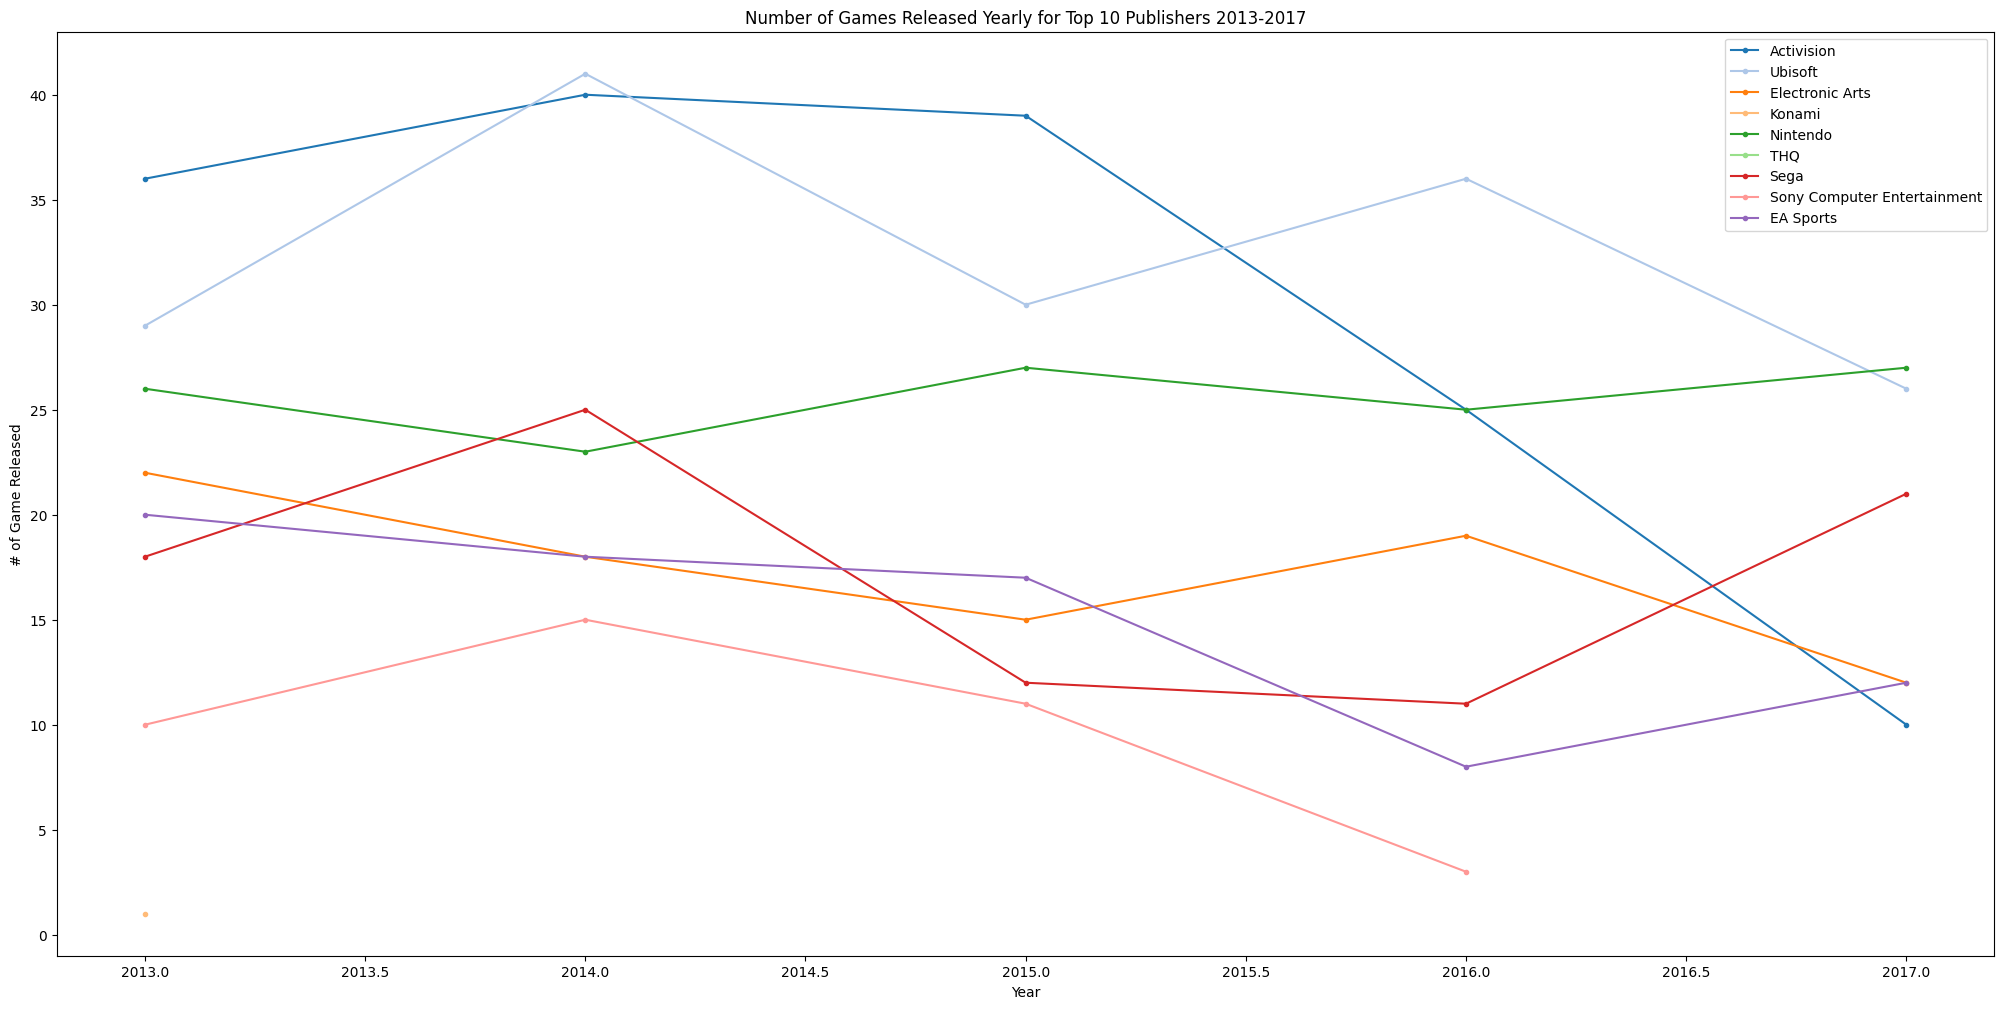

In [93]:
publisher_list_releases_5y = top_10_publishers_releases_5y['Publisher'].unique()[:-1]

publisher_yearly_releases_5y = df_5_years.groupby(['Publisher','Release_date'],as_index=False,sort=True)['Publisher'].size()

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

plt.figure(figsize=(25,12))

for publisher in publisher_list_releases:
    publisher_release_5y = publisher_yearly_releases_5y[publisher_yearly_releases_5y['Publisher'] == publisher]
    plt.plot(publisher_release_5y['Release_date'], publisher_release_5y['size'], label = publisher,marker='.',color = cmap(i))
    i = i+1


plt.title('Number of Games Released Yearly for Top 10 Publishers 2013-2017')
plt.xlabel('Year')
plt.ylabel('# of Game Released')
plt.legend()
plt.show()

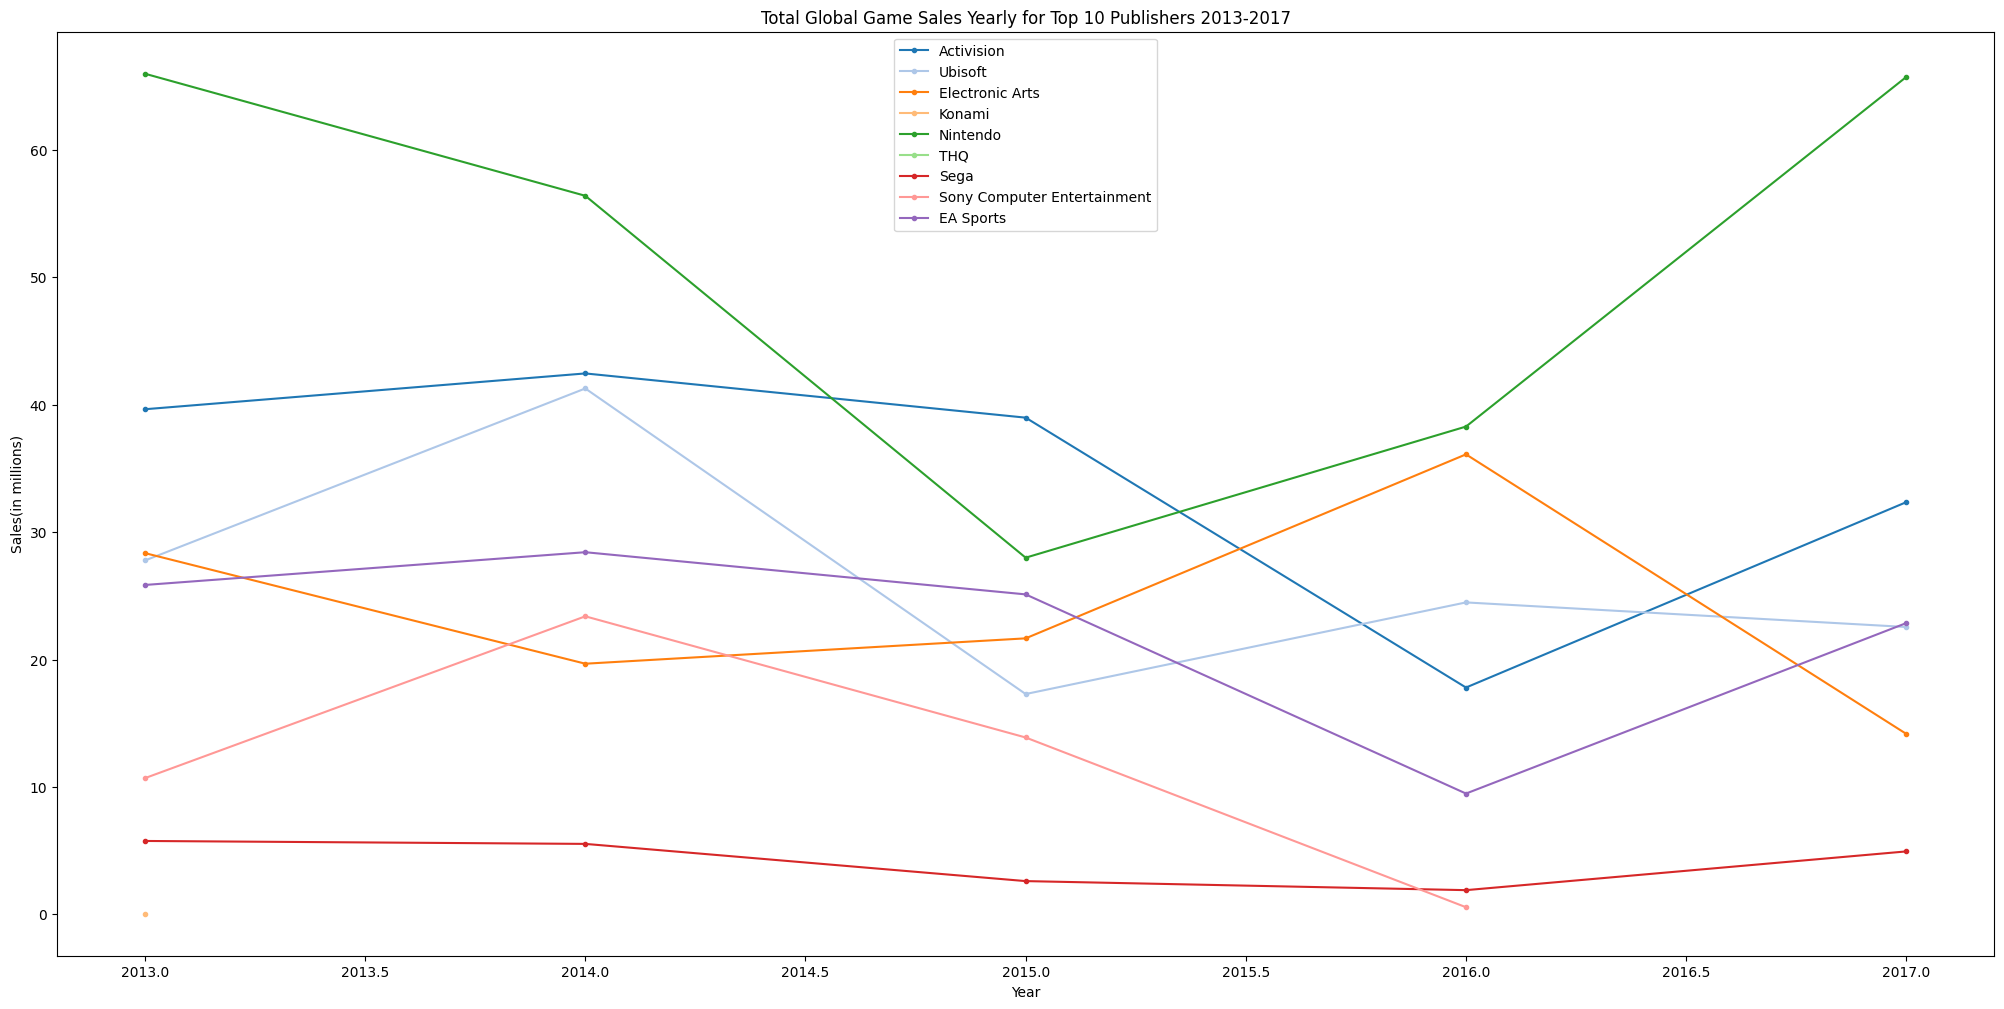

In [94]:
publisher_list_sales_5y = top_10_publishers_sales_5y['Publisher'].unique()[:-1]

publisher_yearly_sales_5y = df_5_years.groupby(['Publisher','Release_date'],as_index=False,sort=True)['Sales_Globe'].sum()

plt.figure(figsize=(25,12))

#set colors for graph since we have > 10 lines to plot
cmap=plt.get_cmap('tab20')
i=0

for publisher in publisher_list_releases:
    publisher_sales_5y = publisher_yearly_sales_5y[publisher_yearly_sales_5y['Publisher'] == publisher]
    plt.plot(publisher_sales_5y['Release_date'], publisher_sales_5y['Sales_Globe'], label = publisher,marker='.',color = cmap(i))
    i = i + 1

plt.title('Total Global Game Sales Yearly for Top 10 Publishers 2013-2017')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

All of the top publishers experience a drop in sales around 2015-2016, but Nintendo, Activsion and EA Sports have bounced back and show positive growth in the last year.

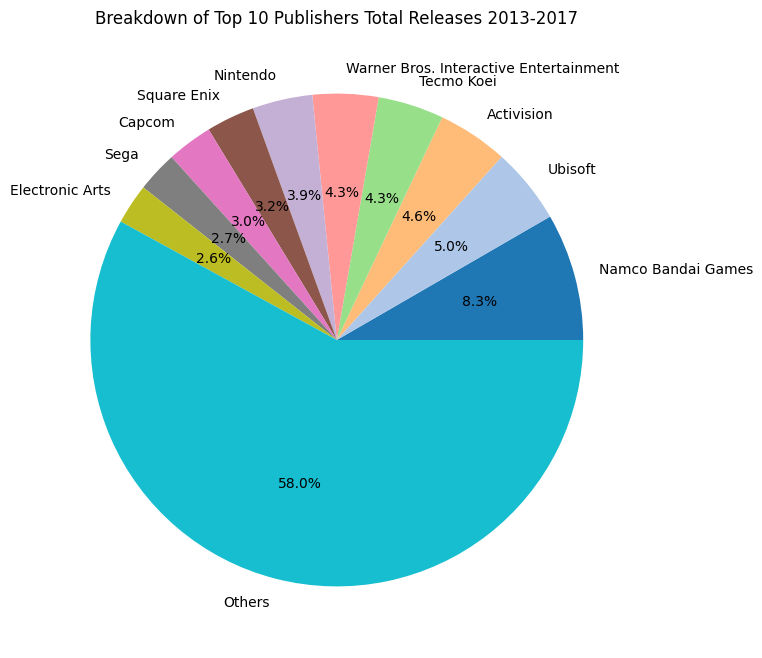

In [95]:
#Breakdown of average contributions of different publishers for releases pie graph

cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(8,8))
plt.title('Breakdown of Top 10 Publishers Total Releases 2013-2017')
plt.pie(top_10_publishers_others_releases_5y['Sales_Globe'],labels = top_10_publishers_others_releases_5y['Publisher'],autopct='%1.1f%%',colors = cs)
plt.show()

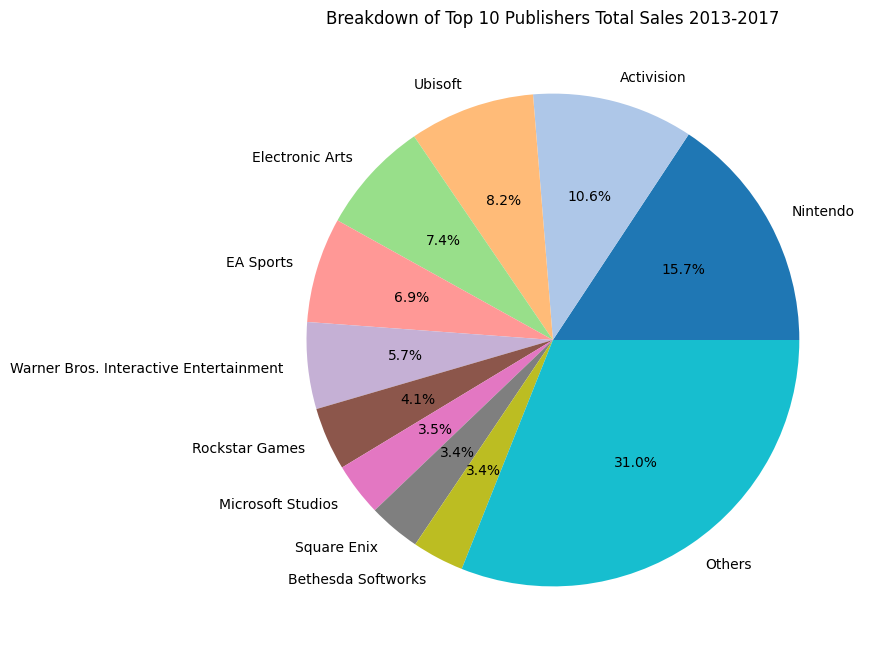

In [96]:
#Breakdown of average contributions of different publishers for sales pie graph

cs = plt.cm.tab20(np.arange(11)/11)

plt.figure(figsize=(8,8))
plt.title('Breakdown of Top 10 Publishers Total Sales 2013-2017')
plt.pie(top_10_publishers_others_sales_5y['Sales_Globe'],labels = top_10_publishers_others_sales_5y['Publisher'],autopct='%1.1f%%', colors = cs)
plt.show()

Publishers outside the top 10 now represent a much larger amount of overall releases but actually represent slightly less in overall sales. Nintendo is still the top publisher in terms of sales per title during this 5 year period.

**Regional Data**

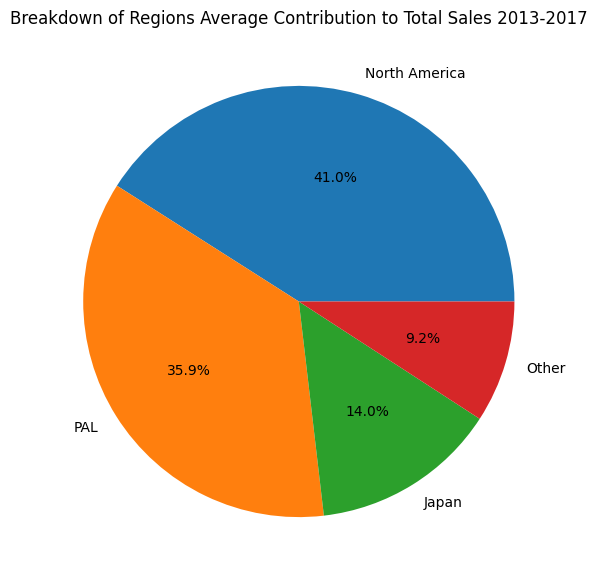

In [97]:
#look at regional information
#Breakdown of average contributions of different markets
avg_sales_5y = [np.mean(df_5_years['Sales_NA']),np.mean(df_5_years['Sales_PAL']),np.mean(df_5_years['Sales_JP']),np.mean(df_5_years['Sales_Other'])]
avg_labels = ['North America','PAL','Japan','Other']

plt.figure(figsize=(7,7))
plt.title('Breakdown of Regions Average Contribution to Total Sales 2013-2017')
plt.pie(avg_sales_5y,labels = avg_labels,autopct='%1.1f%%')
plt.show()

The regional sales distributions druing this period of time is very similar to our overall data with North America as the largest contributor with the PAL region coming in 2nd. Japan has significantly decreased in contribution with the PAL region being the largest benifactor. Again we should keep in mind that we are missing a large amount of regional sales data and that this make have an affect on our analysis of these distributions.

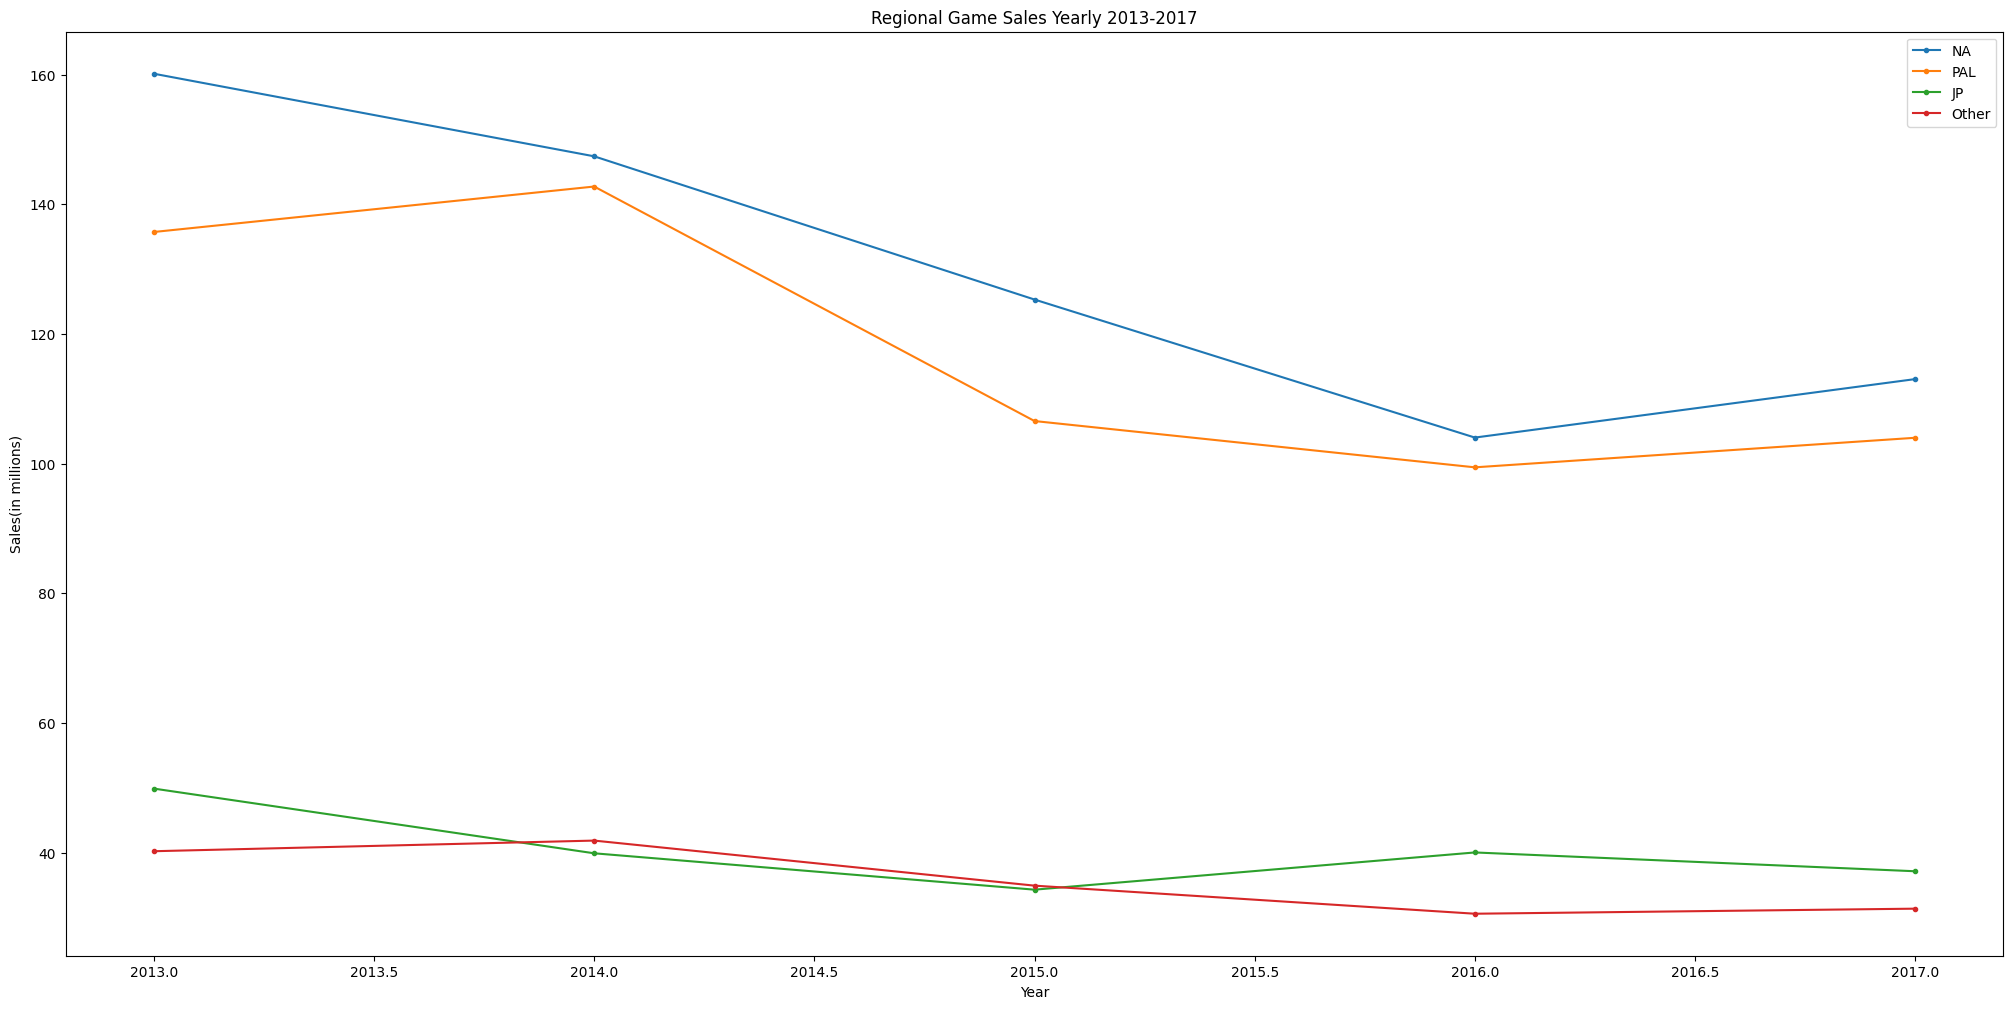

In [98]:
#yearly sales per region
NA_yearly_sales_5y = df_5_years.groupby(['Release_date'],as_index=False,sort=True)['Sales_NA'].sum().sort_values('Release_date')
PAL_yearly_sales_5y = df_5_years.groupby(['Release_date'],as_index=False,sort=True)['Sales_PAL'].sum().sort_values('Release_date')
JP_yearly_sales_5y = df_5_years.groupby(['Release_date'],as_index=False,sort=True)['Sales_JP'].sum().sort_values('Release_date')
Other_yearly_sales_5y = df_5_years.groupby(['Release_date'],as_index=False,sort=True)['Sales_Other'].sum().sort_values('Release_date')

plt.figure(figsize=(25,12))
plt.title('Regional Game Sales Yearly 2013-2017')
plt.plot(NA_yearly_sales_5y['Release_date'],NA_yearly_sales_5y['Sales_NA'], label = 'NA', marker='.')
plt.plot(PAL_yearly_sales_5y['Release_date'],PAL_yearly_sales_5y['Sales_PAL'], label = 'PAL', marker='.')
plt.plot(JP_yearly_sales_5y['Release_date'],JP_yearly_sales_5y['Sales_JP'], label = 'JP', marker='.')
plt.plot(Other_yearly_sales_5y['Release_date'],Other_yearly_sales_5y['Sales_Other'], label = 'Other', marker='.')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

Sales in all regions have decreased, but the North American and PAL regions show positive growth in the last year.

In [99]:
#Best selling game per region

best_NA_id_5y = df_5_years['Sales_NA'].idxmax()
max_sales_NA_5y = df_5_years.loc[best_NA_id_5y][['Sales_NA','Name','Genre']]
best_EU_id_5y = df_5_years['Sales_PAL'].idxmax()
max_sales_EU_5y = df_5_years.loc[best_EU_id_5y][['Sales_PAL','Name','Genre']]
best_JP_id_5y = df_5_years['Sales_JP'].idxmax()
max_sales_JP_5y = df_5_years.loc[best_JP_id_5y][['Sales_JP','Name','Genre']]
best_Other_id_5y = df_5_years['Sales_Other'].idxmax()
max_sales_other_5y = df_5_years.loc[best_Other_id_5y][['Sales_Other','Name','Genre']]

#set up data
max_regions = ['North America','PAL','Japan','Other']
max_names_5y = [max_sales_NA_5y[1],max_sales_EU_5y[1],max_sales_JP_5y[1],max_sales_other_5y[1]]
max_genre_5y = [max_sales_NA_5y[2],max_sales_EU_5y[2],max_sales_JP_5y[2],max_sales_other_5y[2]]
max_sales_5y = [max_sales_NA_5y[0],max_sales_EU_5y[0],max_sales_JP_5y[0],max_sales_other_5y[0]]

#set up dataframe
most_sales_per_region_5y = pd.DataFrame(data = {
    'Region' : max_regions,
    'Name' : max_names_5y,
    'Genre' : max_genre_5y,
    'Sales(millions)' : max_sales_5y
})

most_sales_per_region_5y

C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\2092525086.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_names_5y = [max_sales_NA_5y[1],max_sales_EU_5y[1],max_sales_JP_5y[1],max_sales_other_5y[1]]
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\2092525086.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_genre_5y = [max_sales_NA_5y[2],max_sales_EU_5y[2],max_sales_JP_5y[2],max_sales_other_5y[2]]
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\2092525086.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

Region                       Name       Genre  Sales(millions)
0  North America         Grand Theft Auto V      Action             9.06
1            PAL         Grand Theft Auto V      Action             9.85
2          Japan  Animal Crossing: New Leaf  Simulation             4.90
3          Other         Grand Theft Auto V      Action             3.12

# Machine Learning Model

In [100]:
col_drop = ['Rank', 'Name']

df_model = df_5_years.drop(col_drop, axis = 1)

df_model.head()

Publisher       Developer Platform  Release_date         Genre  \
18  Rockstar Games  Rockstar North      PS3        2013.0        Action   
20  Rockstar Games  Rockstar North      PS4        2014.0        Action   
25        Nintendo      Game Freak      3DS        2013.0  Role-Playing   
26  Rockstar Games  Rockstar North     X360        2013.0        Action   
31        Nintendo      Game Freak      3DS        2016.0  Role-Playing   

    Sales_NA  Sales_PAL  Sales_JP  Sales_Other  Sales_Globe  
18      6.37       9.85      0.99         3.12        20.32  
20      6.06       9.71      0.60         3.02        19.39  
25      5.68       5.06      4.40         0.99        16.13  
26      9.06       5.33      0.06         1.42        15.86  
31      6.02       4.34      3.82         0.99        15.17

In [101]:
#check null values
print("data :\n")
print(df_model.isnull().sum())
print('Total null values : ',df_5_years.isnull().sum().sum())

data :

Publisher          0
Developer          0
Platform           0
Release_date       0
Genre              0
Sales_NA        1341
Sales_PAL       1276
Sales_JP        1518
Sales_Other      899
Sales_Globe        0
dtype: int64
Total null values :  5034


In [102]:
df_model = df_model.dropna()

In [103]:
#check null values
print("data :\n")
print(df_model.isnull().sum())

print('Total null values : ',df_model.isnull().sum().sum())

data :

Publisher       0
Developer       0
Platform        0
Release_date    0
Genre           0
Sales_NA        0
Sales_PAL       0
Sales_JP        0
Sales_Other     0
Sales_Globe     0
dtype: int64
Total null values :  0


In [104]:
df_model

Publisher             Developer Platform  Release_date  \
18         Rockstar Games        Rockstar North      PS3        2013.0   
20         Rockstar Games        Rockstar North      PS4        2014.0   
25               Nintendo            Game Freak      3DS        2013.0   
26         Rockstar Games        Rockstar North     X360        2013.0   
31               Nintendo            Game Freak      3DS        2016.0   
...                   ...                   ...      ...           ...   
14132         NIS America        Kadokawa Games      PS3        2014.0   
14467         NIS America        Kadokawa Games      PSV        2017.0   
14576         Aksys Games            Examu Inc.      PSV        2014.0   
15835         Aksys Games  Bergsala Lightweight      PSV        2017.0   
16737  Namco Bandai Games         Delta Factory      3DS        2014.0   

              Genre  Sales_NA  Sales_PAL  Sales_JP  Sales_Other  Sales_Globe  
18           Action      6.37       9.85      0.99         3.12        20.32  
20           Action      6.06       9.71      0.60         3.02        19.39  
25     Role-Playing      5.68       5.06      4.40         0.99        16.13  
26           Action      9.06       5.33      0.06         1.42        15.86  
31     Role-Playing      6.02       4.34      3.82         0.99        15.17  
...             ...       ...        ...       ...          ...          ...  
14132  Role-Playing      0.03       0.01      0.01         0.01         0.05  
14467  Role-Playing      0.01       0.00      0.03         0.00         0.05  
14576      Fighting      0.02       0.00      0.02         0.01         0.04  
15835        Action      0.01       0.00      0.01         0.00         0.03  
16737        Action      0.01       0.01      0.00         0.00         0.02  

[686 rows x 10 columns]

In [105]:
#Convert our regional sales into percentage of total sales
df_model.shape[0]

for i in range(df_model.shape[0]):
    row = df_model.iloc[i,:]
    row['Sales_NA'] = row['Sales_NA']/row['Sales_Globe']
    row['Sales_PAL'] = row['Sales_PAL']/row['Sales_Globe']
    row['Sales_JP'] = row['Sales_JP']/row['Sales_Globe']
    row['Sales_Other'] = row['Sales_Other']/row['Sales_Globe']
    df_model.iloc[i,:] = row


C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\1711134748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Sales_NA'] = row['Sales_NA']/row['Sales_Globe']
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\1711134748.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Sales_PAL'] = row['Sales_PAL']/row['Sales_Globe']
C:\Users\Monado\AppData\Local\Temp\ipykernel_31996\1711134748.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

The current regional sales data is not suitable for inclusion in our model. This is because these figures sum up to the global sales, creating a direct relationship that can lead to overfitting. Additionally,  we typically wouldn't have access to only regional sales without knowing the total sales in real world applications. However, it is reasonable to estimate the proportion of sales expected from various regions. By converting regional sales data to a percentage of total sales, we can retain valuable regional insights without risking overfitting.

In [106]:
X = df_model[['Platform','Genre','Release_date','Sales_NA', 'Sales_PAL', 'Sales_JP', 'Sales_Other']]

y = df_model['Sales_Globe']

X


Platform         Genre  Release_date  Sales_NA  Sales_PAL  Sales_JP  \
18         PS3        Action        2013.0  0.313484   0.484744  0.048720   
20         PS4        Action        2014.0  0.312532   0.500774  0.030944   
25         3DS  Role-Playing        2013.0  0.352139   0.313701  0.272784   
26        X360        Action        2013.0  0.571248   0.336066  0.003783   
31         3DS  Role-Playing        2016.0  0.396836   0.286091  0.251813   
...        ...           ...           ...       ...        ...       ...   
14132      PS3  Role-Playing        2014.0  0.600000   0.200000  0.200000   
14467      PSV  Role-Playing        2017.0  0.200000   0.000000  0.600000   
14576      PSV      Fighting        2014.0  0.500000   0.000000  0.500000   
15835      PSV        Action        2017.0  0.333333   0.000000  0.333333   
16737      3DS        Action        2014.0  0.500000   0.500000  0.000000   

       Sales_Other  
18        0.153543  
20        0.155750  
25        0.061376  
26        0.089533  
31        0.065260  
...            ...  
14132     0.200000  
14467     0.000000  
14576     0.250000  
15835     0.000000  
16737     0.000000  

[686 rows x 7 columns]

In [107]:
# #Encoding for Platform column
# ct_e = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse= False), [0])], remainder='passthrough')
# X = pd.DataFrame(ct_e.fit_transform(X))
# X = X.drop([9], axis = 1) #drop last column to avoid multicollinearity

# #Encoding for Genre column
# ct_e = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse= False), [9])], remainder='passthrough')
# X = pd.DataFrame(ct_e.fit_transform(X))
# X = X.drop([26], axis = 1) #drop last column to avoid multicollinearity

In [108]:
X

Platform         Genre  Release_date  Sales_NA  Sales_PAL  Sales_JP  \
18         PS3        Action        2013.0  0.313484   0.484744  0.048720   
20         PS4        Action        2014.0  0.312532   0.500774  0.030944   
25         3DS  Role-Playing        2013.0  0.352139   0.313701  0.272784   
26        X360        Action        2013.0  0.571248   0.336066  0.003783   
31         3DS  Role-Playing        2016.0  0.396836   0.286091  0.251813   
...        ...           ...           ...       ...        ...       ...   
14132      PS3  Role-Playing        2014.0  0.600000   0.200000  0.200000   
14467      PSV  Role-Playing        2017.0  0.200000   0.000000  0.600000   
14576      PSV      Fighting        2014.0  0.500000   0.000000  0.500000   
15835      PSV        Action        2017.0  0.333333   0.000000  0.333333   
16737      3DS        Action        2014.0  0.500000   0.500000  0.000000   

       Sales_Other  
18        0.153543  
20        0.155750  
25        0.061376  
26        0.089533  
31        0.065260  
...            ...  
14132     0.200000  
14467     0.000000  
14576     0.250000  
15835     0.000000  
16737     0.000000  

[686 rows x 7 columns]

In [109]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['Platform','Genre'])

encoder.fit(X,y)

X = encoder.transform(X)


In [110]:
#Drop one column from both encoded categories to avoid multicollinearity
X = X.drop(['Platform_10','Genre_18'],axis=1)

In [111]:
X

Platform_1  Platform_2  Platform_3  Platform_4  Platform_5  Platform_6  \
18              1           0           0           0           0           0   
20              0           1           0           0           0           0   
25              0           0           1           0           0           0   
26              0           0           0           1           0           0   
31              0           0           1           0           0           0   
...           ...         ...         ...         ...         ...         ...   
14132           1           0           0           0           0           0   
14467           0           0           0           0           0           0   
14576           0           0           0           0           0           0   
15835           0           0           0           0           0           0   
16737           0           0           1           0           0           0   

       Platform_7  Platform_8  Platform_9  Genre_1  ...  Genre_13  Genre_14  \
18              0           0           0        1  ...         0         0   
20              0           0           0        1  ...         0         0   
25              0           0           0        0  ...         0         0   
26              0           0           0        1  ...         0         0   
31              0           0           0        0  ...         0         0   
...           ...         ...         ...      ...  ...       ...       ...   
14132           0           0           0        0  ...         0         0   
14467           0           1           0        0  ...         0         0   
14576           0           1           0        0  ...         0         0   
15835           0           1           0        1  ...         0         0   
16737           0           0           0        1  ...         0         0   

       Genre_15  Genre_16  Genre_17  Release_date  Sales_NA  Sales_PAL  \
18            0         0         0        2013.0  0.313484   0.484744   
20            0         0         0        2014.0  0.312532   0.500774   
25            0         0         0        2013.0  0.352139   0.313701   
26            0         0         0        2013.0  0.571248   0.336066   
31            0         0         0        2016.0  0.396836   0.286091   
...         ...       ...       ...           ...       ...        ...   
14132         0         0         0        2014.0  0.600000   0.200000   
14467         0         0         0        2017.0  0.200000   0.000000   
14576         0         0         0        2014.0  0.500000   0.000000   
15835         0         0         0        2017.0  0.333333   0.000000   
16737         0         0         0        2014.0  0.500000   0.500000   

       Sales_JP  Sales_Other  
18     0.048720     0.153543  
20     0.030944     0.155750  
25     0.272784     0.061376  
26     0.003783     0.089533  
31     0.251813     0.065260  
...         ...          ...  
14132  0.200000     0.200000  
14467  0.600000     0.000000  
14576  0.500000     0.250000  
15835  0.333333     0.000000  
16737  0.000000     0.000000  

[686 rows x 31 columns]

In [112]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [113]:
#Feature Scaling
sc = StandardScaler()
X_train.iloc[:, 26:] = sc.fit_transform(X_train.iloc[:, 26:])
X_test.iloc[:, 26:] = sc.transform(X_test.iloc[:, 26:])

In [114]:
# #MLR dont need feature scaling
# regressor = LinearRegression()
#acc = .127
#r2 = 0.07

#Polynomial regression dont need feature scaling
# regressor_p = PolynomialFeatures(degree = 4)
# X_poly = regressor_p.fit_transform(X)
# regressor = LinearRegression()
# X = X_poly
#acc w/ scaling = 
#acc w/o scaling = 

#SVR
# regressor = SVR(kernel = 'rbf')
# acc = 0.111
# r2 = 0.044

#Decision Tree dont need feature scaling
# regressor = DecisionTreeRegressor(random_state = 0)
# acc = 1
# r2 = 0.044
##THIS MAY BE THE BEST MODEL

# #Random Forest dont need feature scaling
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
# acc = 0.831
# r2 = 0.167

#XGBRegressor
# bp = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample' :1}
# regressor = XGBRegressor(n_estimators = bp['n_estimators'], max_depth = bp['max_depth'],
#                       subsample = bp['subsample'], learning_rate = bp['learning_rate'], random_state = 100)
# acc = 0.831
# r2 = 0.167

regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [115]:
y_pred = regressor.predict(X_test)

In [116]:
y_test = np.array(y_test)

In [117]:
#Metric used to determine effectiveness of the model
r2 = r2_score(y_test,y_pred)
print('R-squared for model = ',r2)

R-squared for model =  0.11943439395731892


R-squared is a common metric used when determining the performance of a regression model. My R2 value shows that this model still has a lot of room for improvement. 

In [118]:
#k-fold Cross validation
accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10,scoring='r2')
print(accuracies)
print('Average R-squared =',accuracies.mean())
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[-0.18963669  0.12015225 -0.02534402  0.44427568  0.22469569 -0.22416891
  0.00750146  0.12136141 -0.56654275  0.42937214]
Average R-squared = 0.034166627153063824
Standard Deviation: 29.28 %


In [ ]:
# # Define the objective function
# def objective(trial):
#     C = trail.suggest_int('C', 0.25, 0.5, 0.75, 1)
#     kernel = trial.suggest_categorical('kernel', ['linear','poly','sigmoid','precomputed','rbf'])
#     gamma = trial.suggest_int('gamma',0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
#     decision_function_shape = trial.suggest_categorical('decision_function_shape',['ovo','ovr'])
    
#     max_depth = trial.suggest_int('max_depth', 5, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

#     model = SVC(
#         C = C,
#         kernel = kernel,
#         gamma = gamma,
#         decision_function_shape = decision_function_shape,
#         random_state=42,
#     )

#     # Use cross-validation to evaluate the model
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
#     return score

# # Create a study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best parameters
# best_params = study.best_params
# print("Best Parameters:", best_params)

In [119]:
## This cell is used to help determine which parameters lead to the best overall model performance

# parameters = {
#     'n_estimators': [300, 500, 1000],
#     'max_depth' : [5, 7, 10],
#     'subsample' : [0.5, 0.7, 1],
#     'learning_rate' : [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(estimator = regressor,
#                            param_grid = parameters,
#                            scoring = 'r2',
#                            cv = 10,
#                            n_jobs = -1)
# grid_search.fit(X, y)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Best Accuracy:",best_accuracy)
# print("Best Parameters:", best_parameters)

In [120]:
#Undo Standardization for the year column
X_test.iloc[:, 26:] = sc.inverse_transform(X_test.iloc[:, 26:])

In [121]:
results = {
    'Year' : X_test.iloc[:,26],
    'Predicted_Sales' : y_pred,
    'Actual_Sales' : y_test
}

df_results = pd.DataFrame(results)

In [122]:
yearly_total_sales_predicted = df_results.groupby(['Year'],as_index=False)['Predicted_Sales'].sum()
yearly_total_sales_inputs = df_results.groupby(['Year'],as_index=False)['Actual_Sales'].sum()

In [123]:
yearly_total_sales_predicted

Year  Predicted_Sales
0  2013.0           90.352
1  2014.0           94.490
2  2015.0           45.843
3  2016.0           60.433
4  2017.0           74.630

In [124]:
yearly_total_sales_inputs

Year  Actual_Sales
0  2013.0         82.06
1  2014.0        102.07
2  2015.0         39.44
3  2016.0         50.28
4  2017.0         80.80

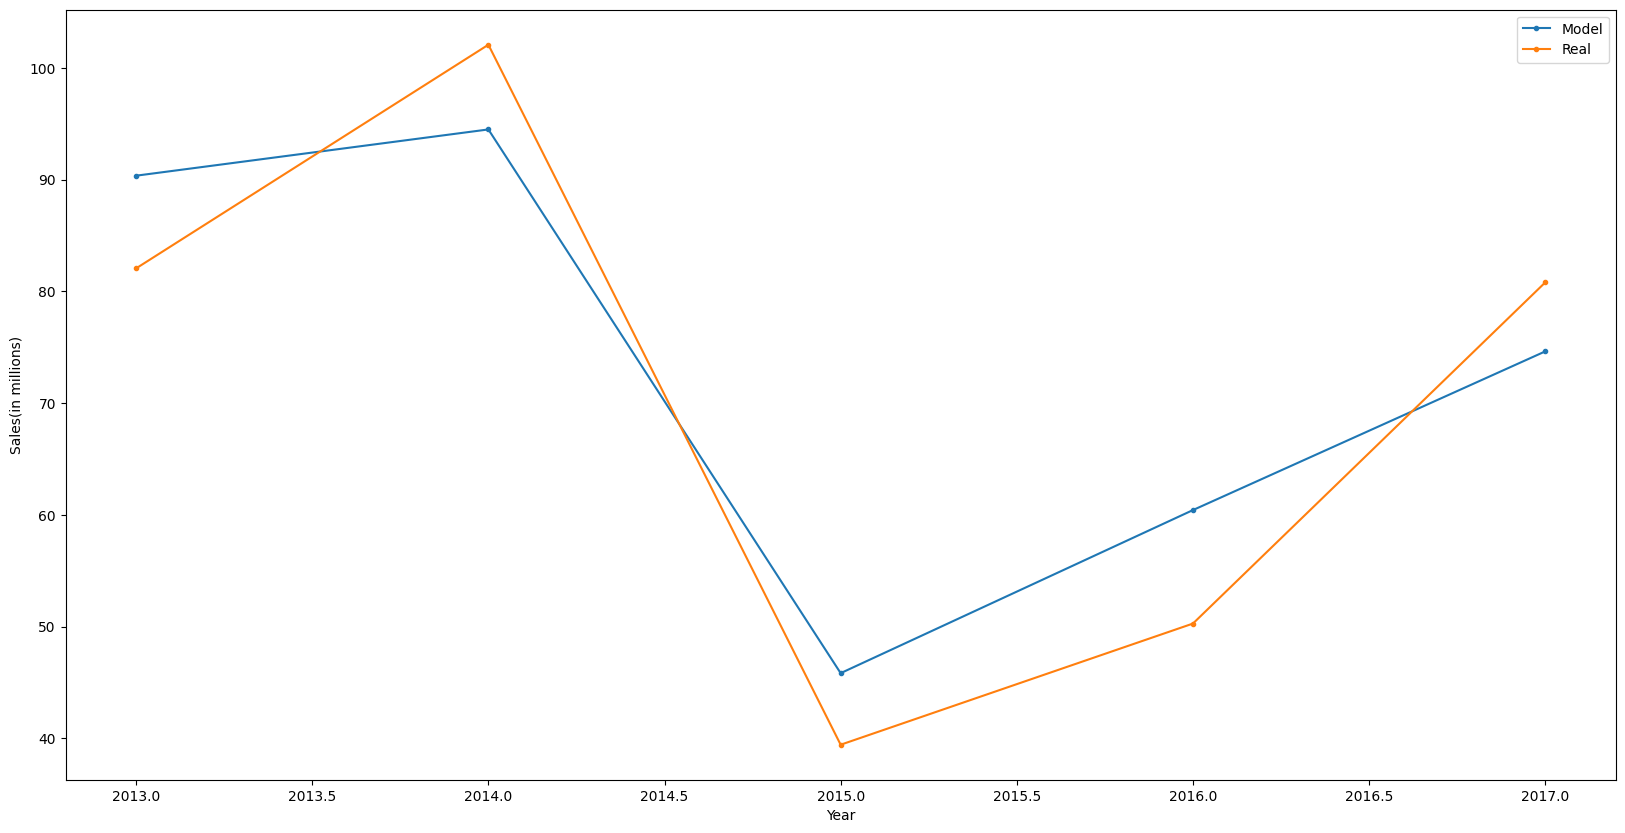

In [125]:
plt.figure(figsize=(20,10))
plt.plot(yearly_total_sales_predicted['Year'],yearly_total_sales_predicted['Predicted_Sales'],marker='.',label='Model')
plt.plot(yearly_total_sales_inputs['Year'],yearly_total_sales_inputs['Actual_Sales'],marker='.',label='Real')
plt.xlabel('Year')
plt.ylabel('Sales(in millions)')
plt.legend()
plt.show()

Even though the R-squared score for this model is relatively low, the model is still successfully able to capture some of the key feautres of the original data as demonstrated in the above graph. 